**리더보드**<p>
* 평가 산식 : RMSE

<br>

**데이터 설명**

1. FIFA_train.csv / FIFA_test.csv<p>
 id : 선수 고유의 아이디<P>
 name : 이름<P>
 age : 나이<P>
 continent : 선수들의 국적이 포함되어 있는 대륙입니다<P>
 contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다<P>
 position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등<P>
 prefer_foot : 선수가 선호하는 발입니다. ex) 오른발<P>
 reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수<P>
 stat_overall : 선수의 현재 능력치 입니다.<P>
 stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.<P>
 stat_skill_moves : 선수의 개인기 능력치 입니다.<P>
 value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다.<P>

<br>

2. submission.csv (제출 파일 형식)<p>
  id : 선수 고유의 아이디<p>
  value : 예측된 선수 이적 시장 가격을 기입 <p>

  <br>
  <br>

 # 1. 패키지 불러오기

In [2]:
# 설치 완료후 런타임 재시작해주세요
!pip install pycaret[full]
!pip install jinja2
!pip install lightgbm
!pip install xgboost

In [3]:
# numpy 다운그레이드
!pip install numpy==1.20

In [4]:
# 나눔 폰트 설치하기
# 설치 후 런타임 다시 시작하기 권장
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import numpy as np
import pandas as pd
import copy

import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, metrics, utils, losses, optimizers

# ML
#from pycaret import regression
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection


# 시각화(visualization) 도구
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as plb
import seaborn as sns

# 경고 제어
import warnings
warnings.filterwarnings(action='ignore') # 경고창 끄기

In [ ]:
# matplotlib에 한글 폰트 적용 시키는 작업

# 브라우저에서 바로 그려지도록하는 명령어 적용
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# 2. 데이터 불러오기

In [5]:
# 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 작업경로 변경 (seonghcoi)
%cd '/content/drive/MyDrive/groom/semi-3/fifa_pay_prediction/03_work_code/ukseongchoi'

/content/drive/MyDrive/groom/semi-3/fifa_pay_prediction/03_work_code/ukseongchoi


In [ ]:
# 작업경로 변경
%cd '/content/drive/MyDrive/My Colab Notebooks/교육과정/[구름] ICT 이노베이션 인공지능과정/[구름] 인공지능 장기과정/11_Semi-project 3/fifa-pay-prediction/'

/content/drive/.shortcut-targets-by-id/1IJHHKV-eQ7jnxf5qiJRCE2FRWdgST5Vf/My Colab Notebooks/교육과정/[구름] ICT 이노베이션 인공지능과정/[구름] 인공지능 장기과정/11_Semi-project 3/fifa-pay-prediction


In [6]:
train = pd.read_csv("00_original_data/FIFA_train.csv")
test = pd.read_csv("00_original_data/FIFA_test.csv")
submission = pd.read_csv("00_original_data/submission.csv")

In [3]:
# tarin 데이터
train.head(5)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [4]:
# test 데이터
test.head(5)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


In [5]:
# submission 데이터
submission.head(5)

,id,value
0,1,0
1,2,0
2,4,0
3,5,0
4,6,0


# 3. 데이터 분석

Train 연속형(숫자형) 데이터 열의
상관관계 분석을 통해서 선수 가치에 많은 영향을 줄 수 있는 데이터를 찾을 수 있음.
상대적으로 선수의 명성도와 현재 능력치와 앞으로의 발전 정도가 상관관계가 높은 평이었으나, 이것만 보기에는 애매한 감이 있음.
의외로 나이에 대한 가치 기대값이 낮은 것을 알 수 있음
축구구단도 이윤을 추구해야하는 축구사업이기 때문에 이름값과 그에 맞는 현재 폼이 선수 가치에 많은 영향을 주지 않았나 생각이 듬.

In [7]:
# 결측치 등을 파악하기 위한, 데이터의 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [ ]:
# 데이터의 통계값을 추출하여 데이터의 성질 파악하기

# 수치형 데이터의 통계값 추출
train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [ ]:
# 범주형 데이터의 통계값 추출
train.describe(include='O')

,name,continent,contract_until,position,prefer_foot
count,8932,8932,8932,8932,8932
unique,8932,5,17,4,2
top,L. Messi,europe,2019,MF,right
freq,1,5322,2366,3428,6837


### 시각화를 통하여 데이터의 상관관계 알아보기

* 이적료 예측이 우리가 해결하고자 하는 문제이므로, 이적료를 기준으로 전체 데이터에 대한 추세를 확인해본다.

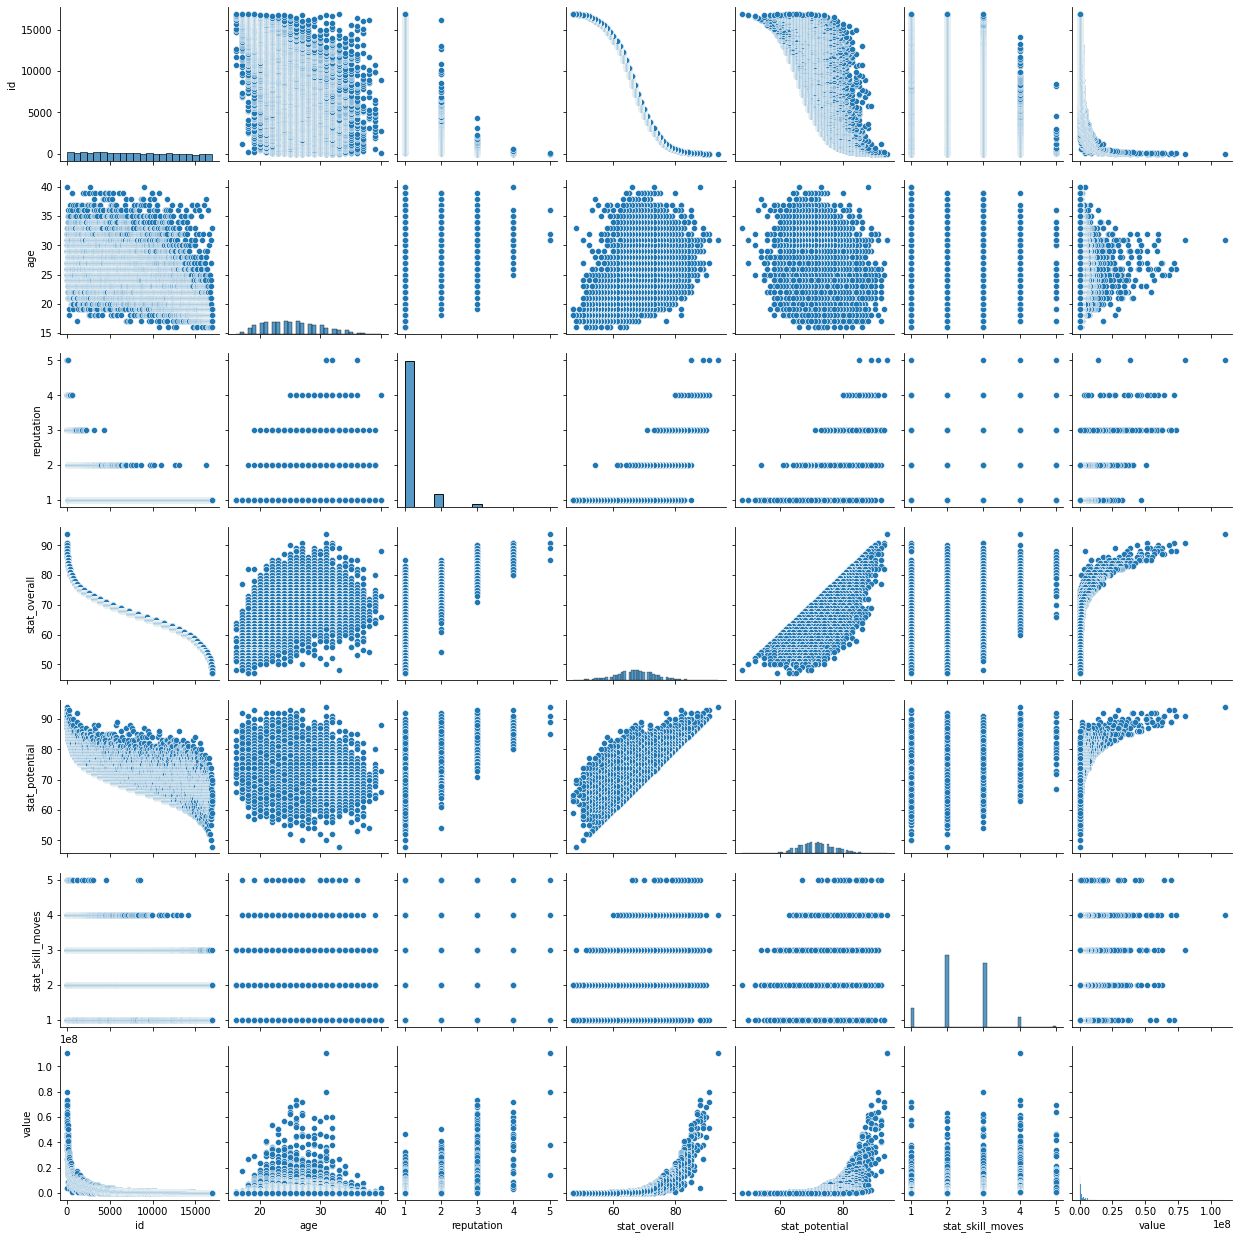

In [ ]:
# 독립변수와 종속변수의 관계를 스캐터플롯(scatter plot)으로 살펴보기
sns.pairplot(train)
plt.show()

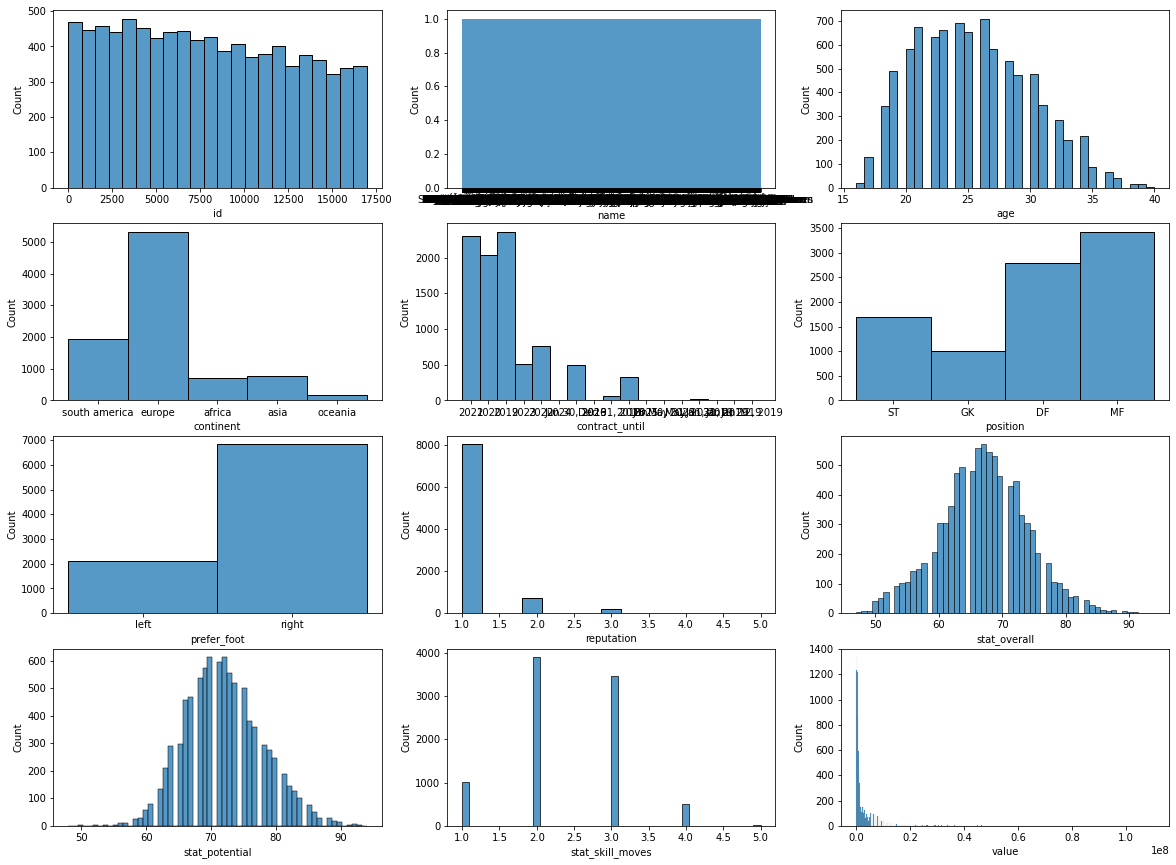

In [ ]:
# 데이터를 골라서 자세히 확인해보기

f, axes = plt.subplots(4,3 , figsize=(20,15))
axes = axes.flatten()
for col, ax in zip(train.columns, axes):
    sns.histplot(data=train, x=col, ax=ax)
plt.show()

In [ ]:
# corr = NA/null 값을 제외한 열의 쌍별 상관 계산
train.corr().style.background_gradient(cmap='Blues_r')

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
id,1.000000,-0.475785,-0.423739,-0.972374,-0.630199,-0.402455,-0.544280
age,-0.475785,1.000000,0.263468,0.467345,-0.231303,0.039362,0.087319
reputation,-0.423739,0.263468,1.000000,0.521389,0.399183,0.196582,0.665982
stat_overall,-0.972374,0.467345,0.521389,1.000000,0.665453,0.400164,0.658444
stat_potential,-0.630199,-0.231303,0.399183,0.665453,1.000000,0.332578,0.611907
stat_skill_moves,-0.402455,0.039362,0.196582,0.400164,0.332578,1.000000,0.298500
value,-0.544280,0.087319,0.665982,0.658444,0.611907,0.298500,1.000000


* train 데이터를 분석해 봤을 때 현재폼과 포텐셜이 가장 높은 상관 관계를 보인다.



#### 이적 시장 가격

[Text(0.5, 1.0, '이적료_로그스케일 박스플롯')]

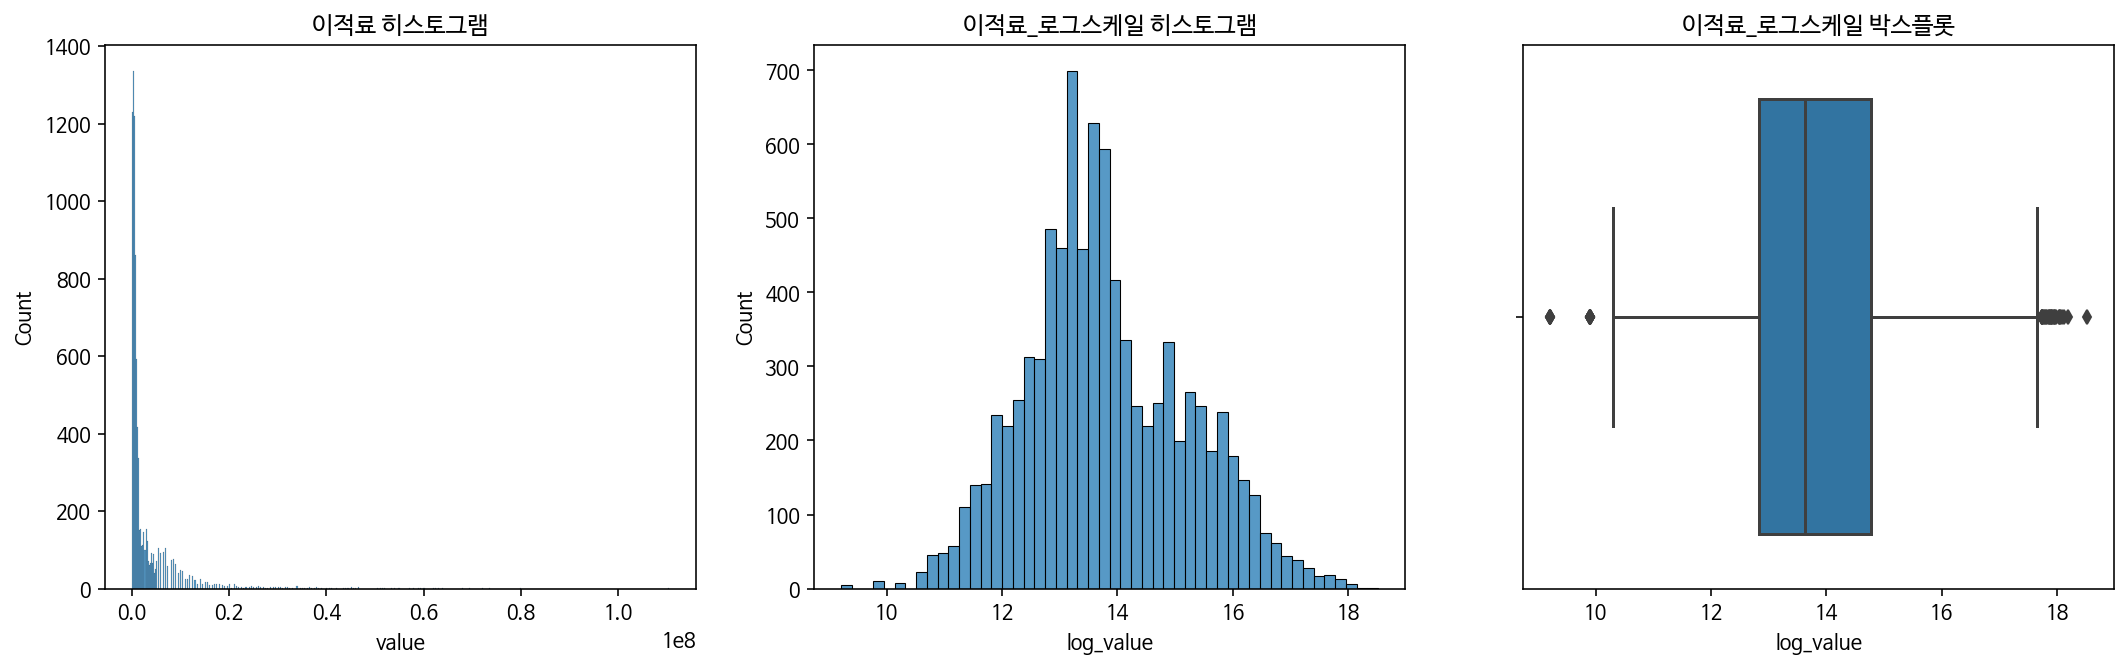

In [ ]:
# 도화지 그리기
fig, axes = plt.subplots(1,3)
fig.set_size_inches(18,5)

# 이적료에 log 적용
train["log_value"] = np.log(train["value"])

sns.histplot(x="value", data=train, ax=axes[0])
axes[0].set(title = "이적료 히스토그램")
sns.histplot(x="log_value", data=train, ax=axes[1])
axes[1].set(title = "이적료_로그스케일 히스토그램")
sns.boxplot(x="log_value", data=train, ax=axes[2])
axes[2].set(title = "이적료_로그스케일 박스플롯")

* 이적 시장 가격의 편차가 매우 크기 때문에 log scale을 적용시킴
* 분석을 진행할때 log scale의 value도 target으로 시도해보면 좋을 것 같음
* log scale 후에도 이상치 발견, log scale 기준 10~18까지 데이터만 사용하면 좋을 것 같음

#### 나이별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '나이'), Text(0.5, 1.0, '나이별 이적료')]

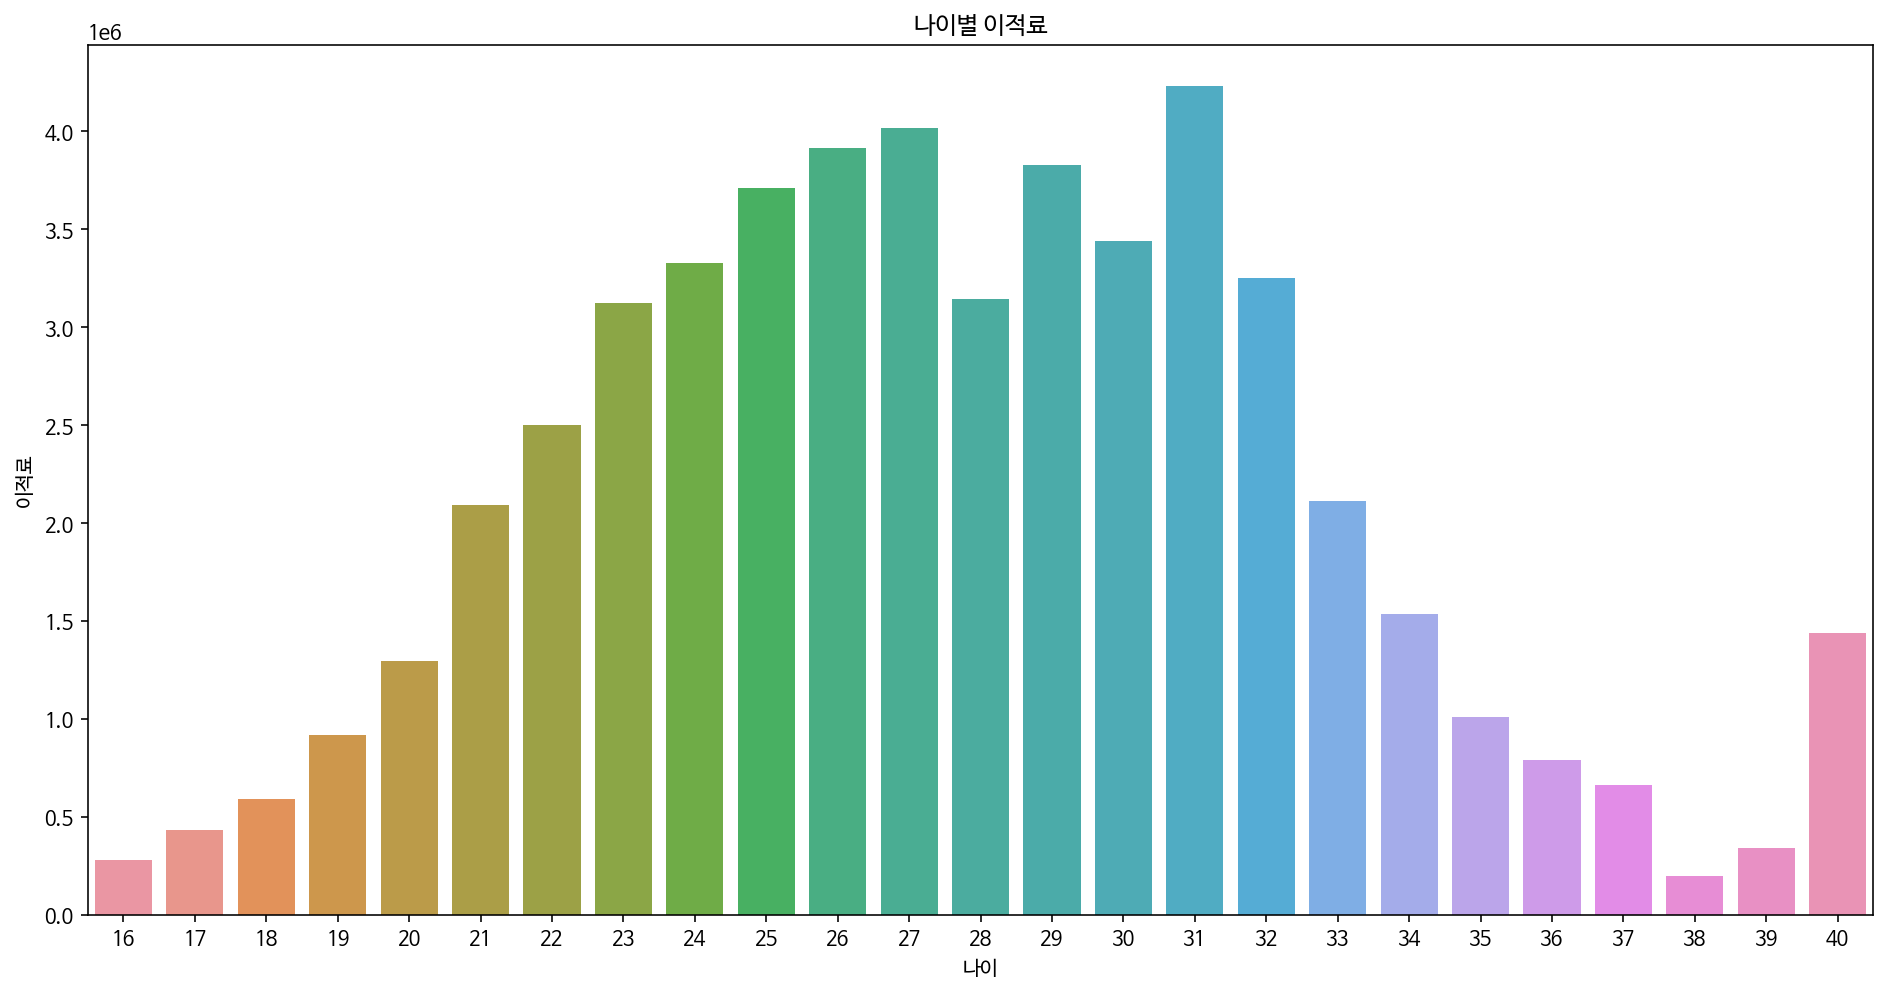

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 나이별 이적료
group_age_value = train.groupby("age")["value"].mean()
group_age_value = group_age_value.reset_index() # 순서가 섞인 인덱스를 다시 처음부터 재배열 해서 저장

# 나이별 이적료 막대 그래프
sns.barplot(x="age", y="value", data=group_age_value)

# 설정
axe.set(title = "나이별 이적료",
      xlabel="나이",
      ylabel="이적료")

#### 계약 기간별 이적료

In [ ]:
# 시각화를 위한 임시 전처리

# train 원본 데이터를 변형하지 않게 하기위해 복사함
temporary_train = train.copy()

# 계약 연도에 월, 일 값이 붙어 있는 데이터를 전처리한 뒤,
# 계약 연도를 object -> int 로 변환
def func(string:object) -> int:
    string = string[-4:] # 계약연도가 제일 끝에 있거나 단독으로 쓰이고 있어 뒤에서 4번째부터 가지고 옴
    return int(string)

temporary_train['contract_until'] = temporary_train['contract_until'].apply(func)

[Text(0, 0.5, '이적료'), Text(0.5, 0, '계약 기간'), Text(0.5, 1.0, '계약 기간별 이적료')]

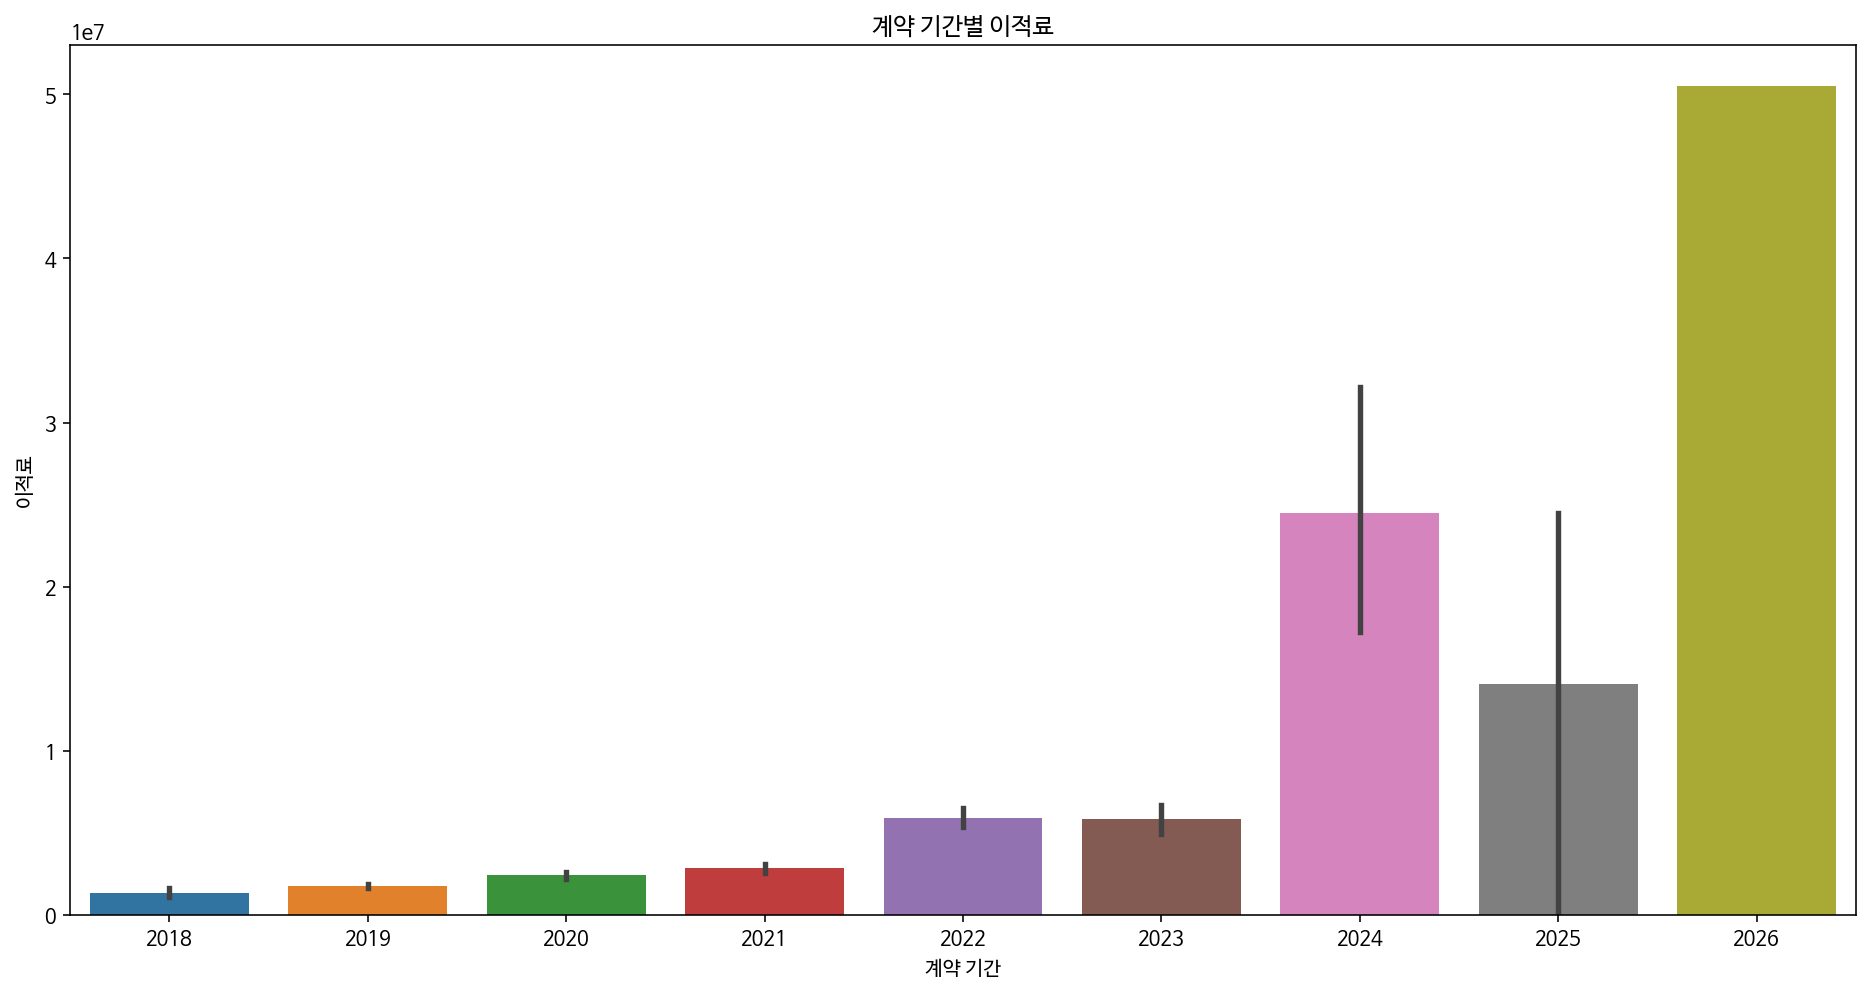

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 계약 기간별 이적료 막대 그래프
sns.barplot(x="contract_until", y="value", data=temporary_train)

# 설정
axe.set(title = "계약 기간별 이적료",
      xlabel="계약 기간",
      ylabel="이적료")

#### 유명도별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '유명도'), Text(0.5, 1.0, '유명도별 이적료')]

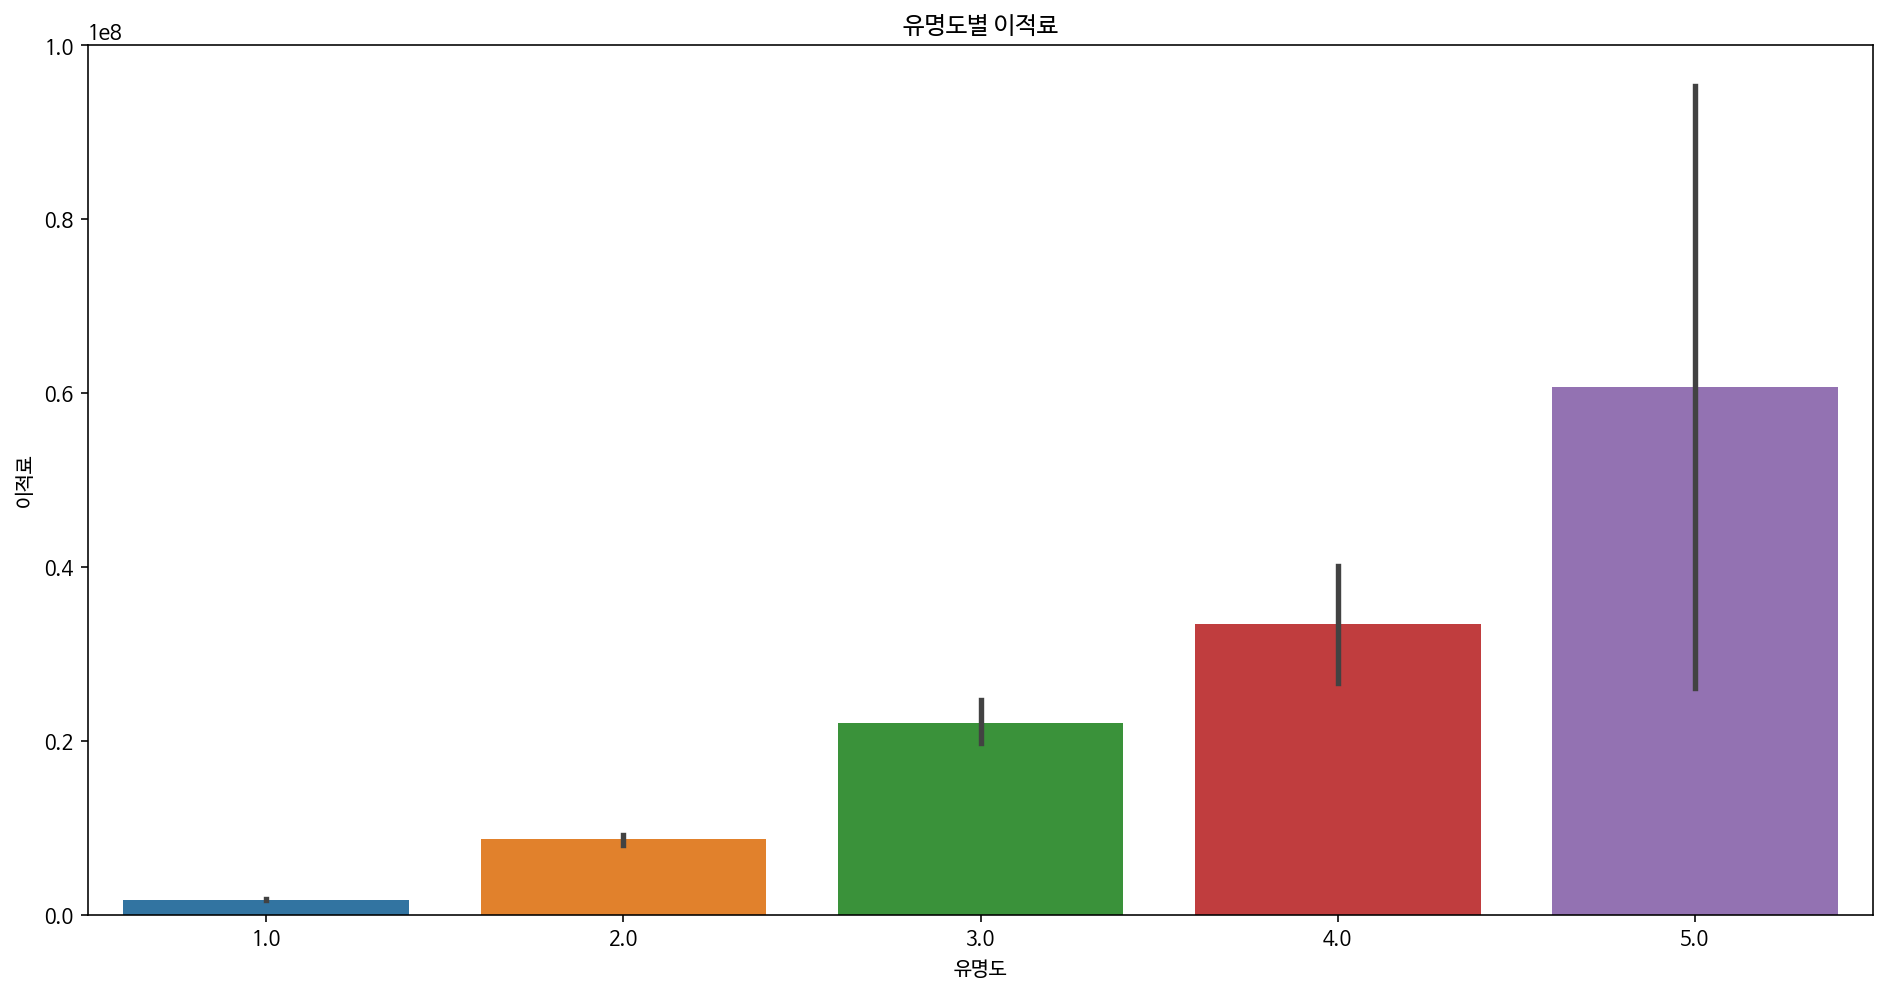

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 유명도별 이적료 막대 그래프
sns.barplot(x="reputation", y="value", data=train)

# 설정
axe.set(title = "유명도별 이적료",
      xlabel="유명도",
      ylabel="이적료")

#### 현재 능력치별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '현재 능력치'), Text(0.5, 1.0, '현재 능력치별 이적료')]

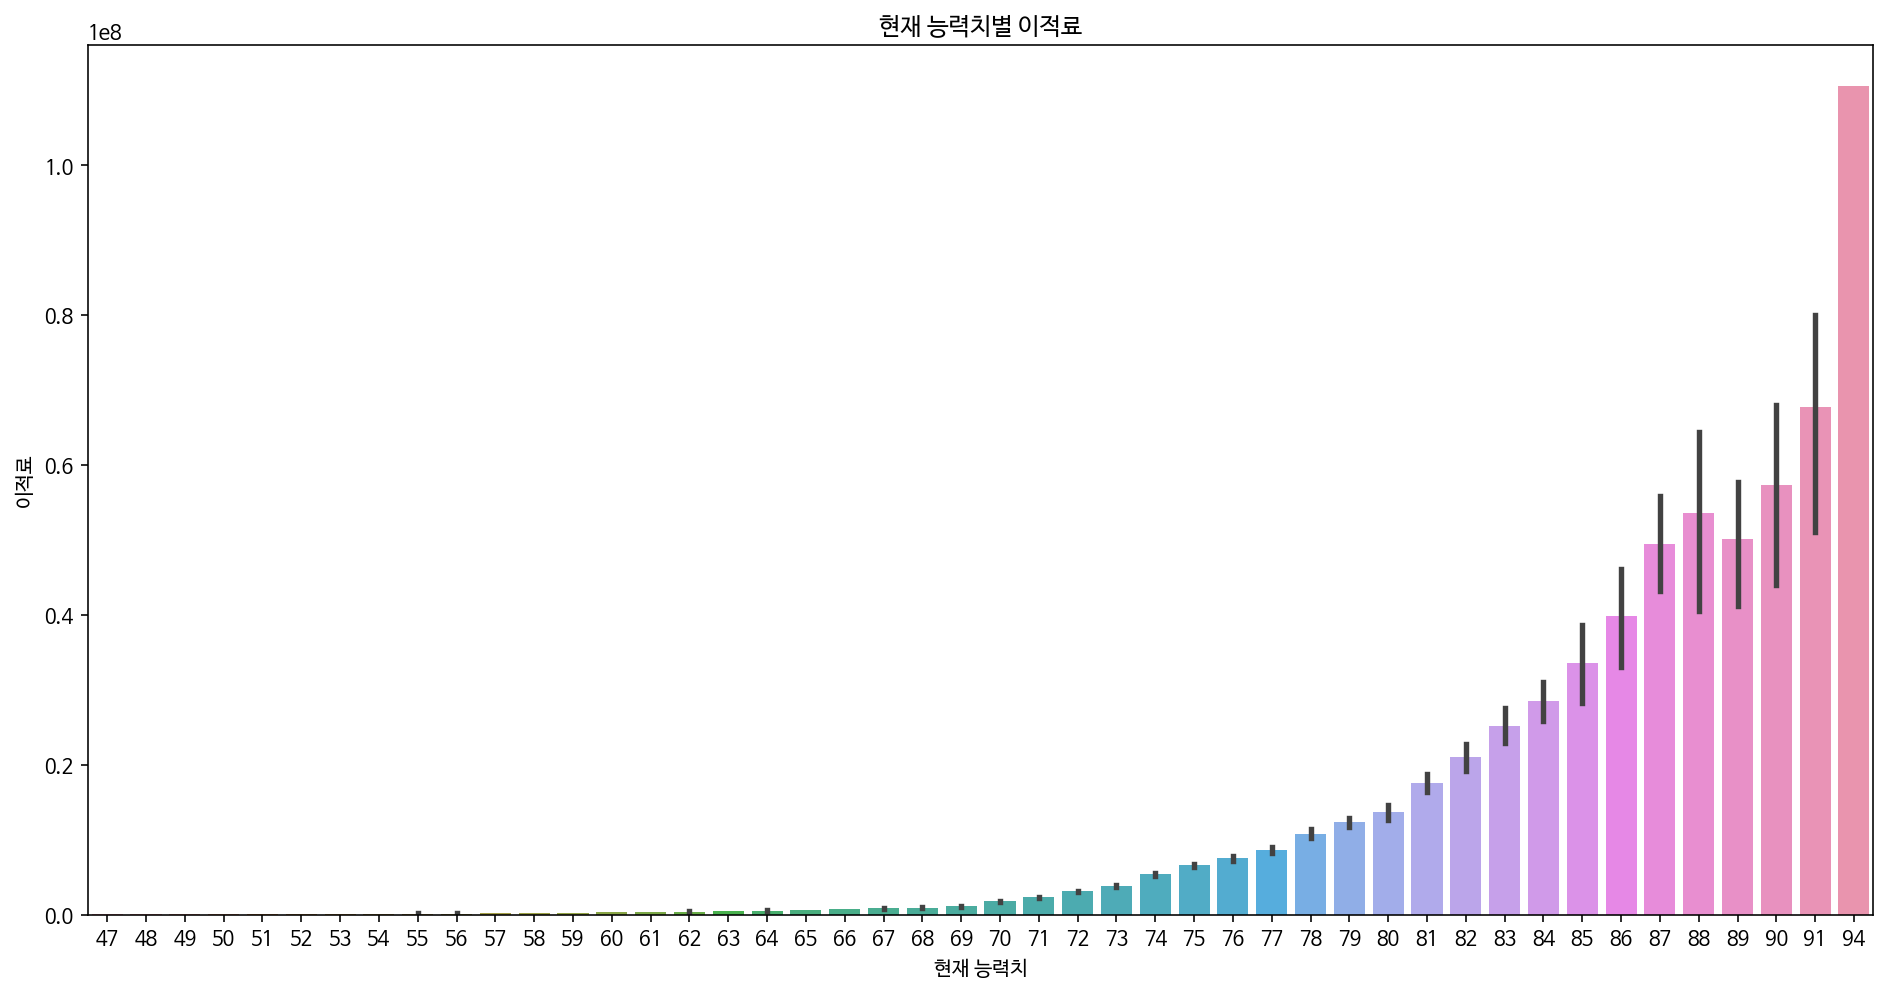

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 현재 능력치별 이적료 막대 그래프
sns.barplot(x="stat_overall", y="value", data=train)

# 설정
axe.set(title = "현재 능력치별 이적료",
      xlabel="현재 능력치",
      ylabel="이적료")

#### 발전 가능성별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '발전 가능성'), Text(0.5, 1.0, '발전 가능성별 이적료')]

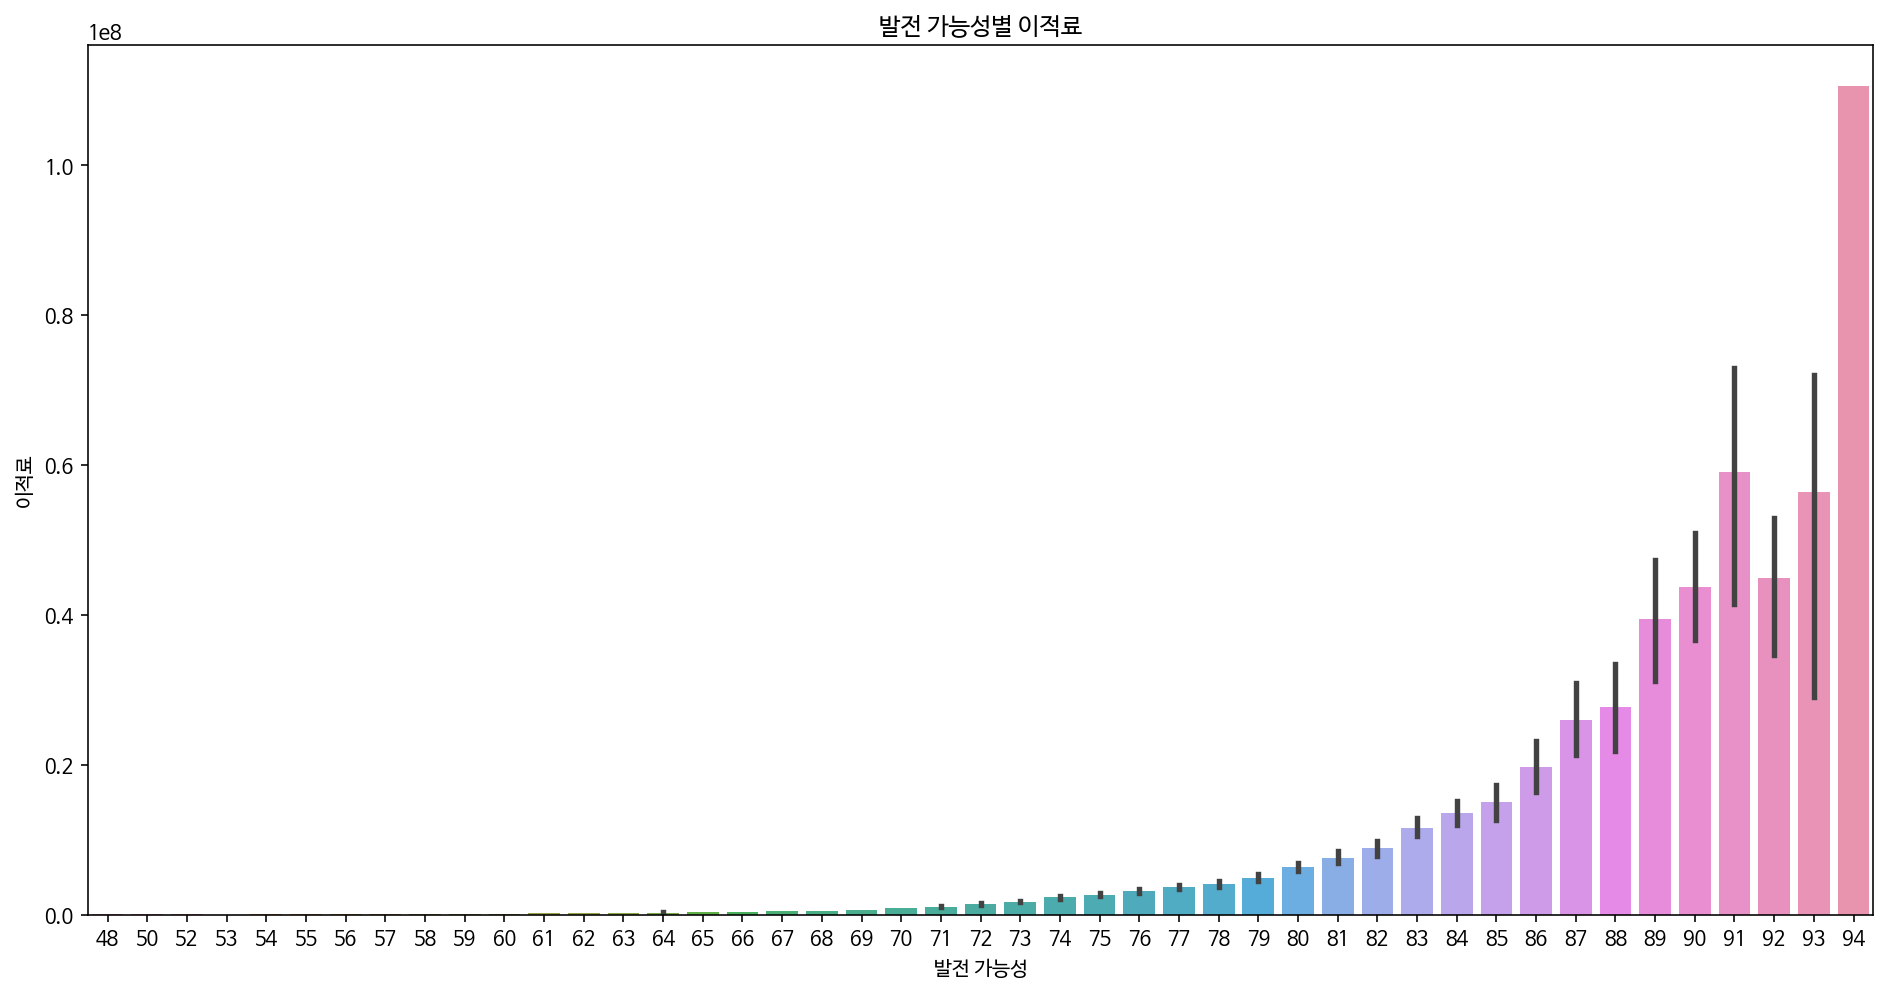

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 발전 가능성별 이적료 막대 그래프
sns.barplot(x="stat_potential", y="value", data=train)

# 설정
axe.set(title = "발전 가능성별 이적료",
      xlabel="발전 가능성",
      ylabel="이적료")

#### 개인 능력치별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '개인 능력치'), Text(0.5, 1.0, '개인 능력치별 이적료')]

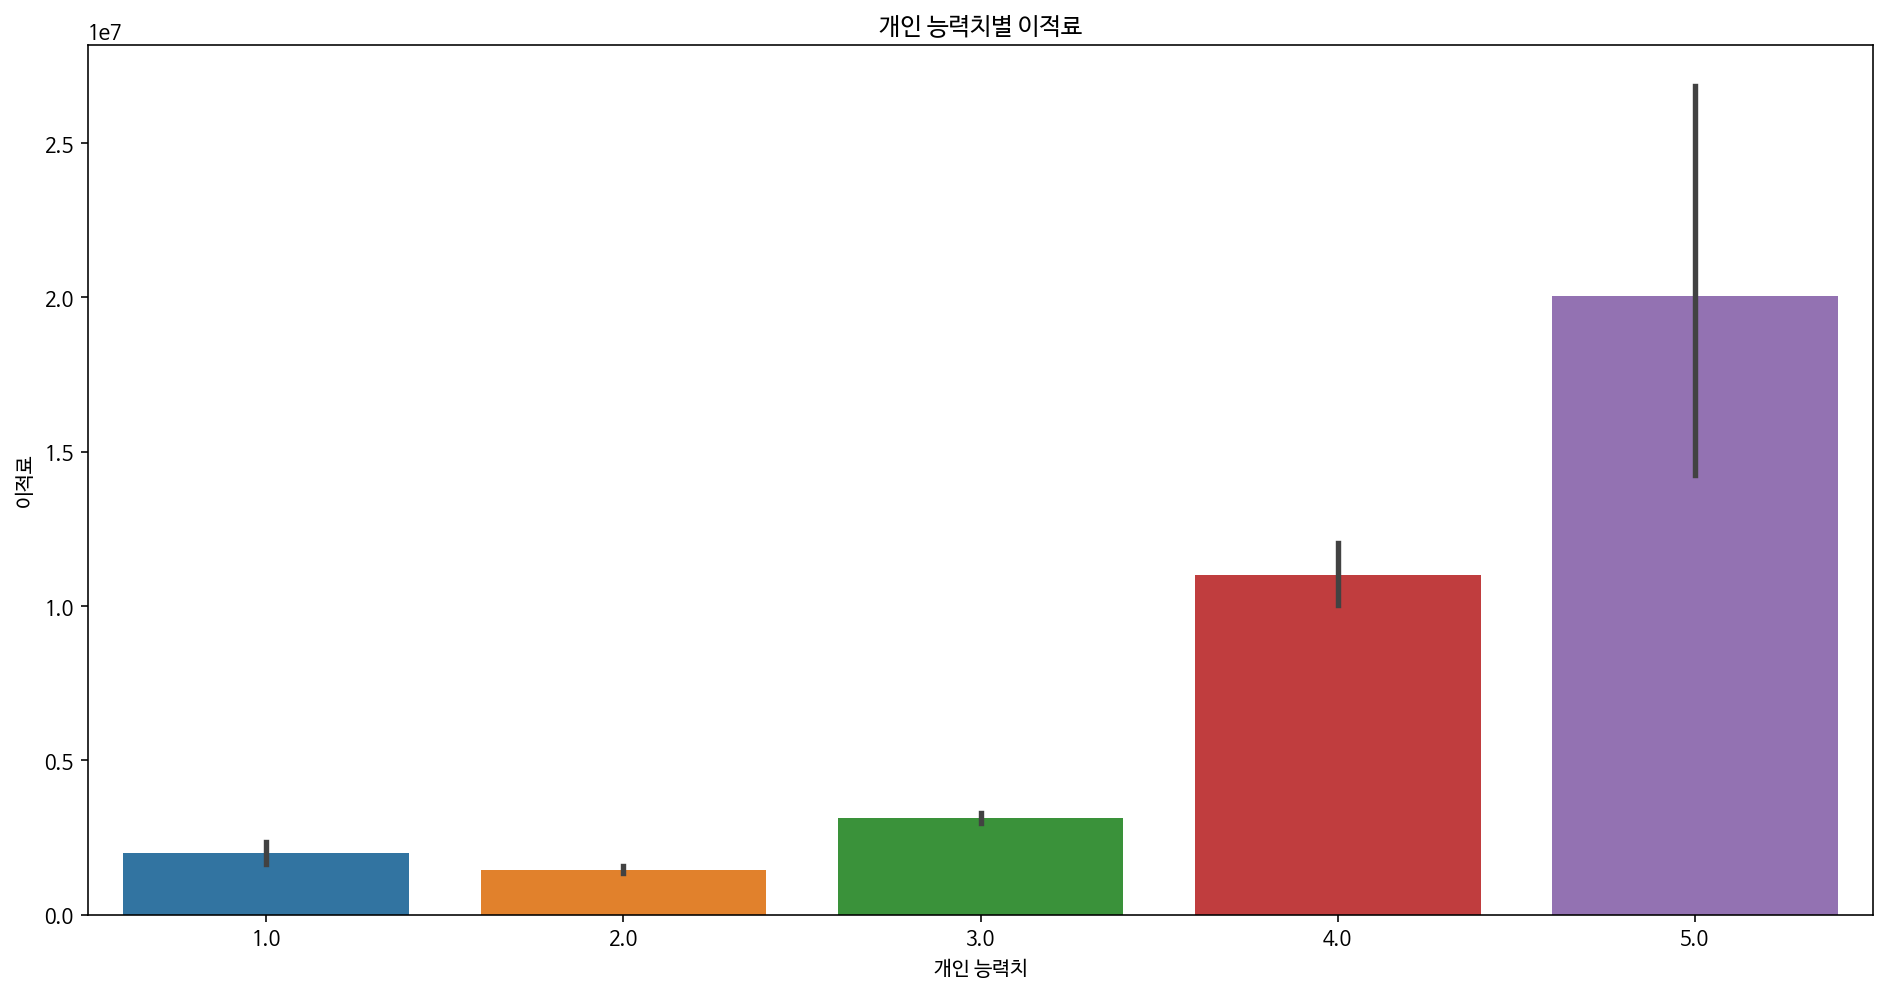

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 개인 능력치별 이적료 막대 그래프
sns.barplot(x="stat_skill_moves", y="value", data=train)

# 설정
axe.set(title = "개인 능력치별 이적료",
      xlabel="개인 능력치",
      ylabel="이적료")

#### 국적별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '국적'), Text(0.5, 1.0, '국적별 이적료')]

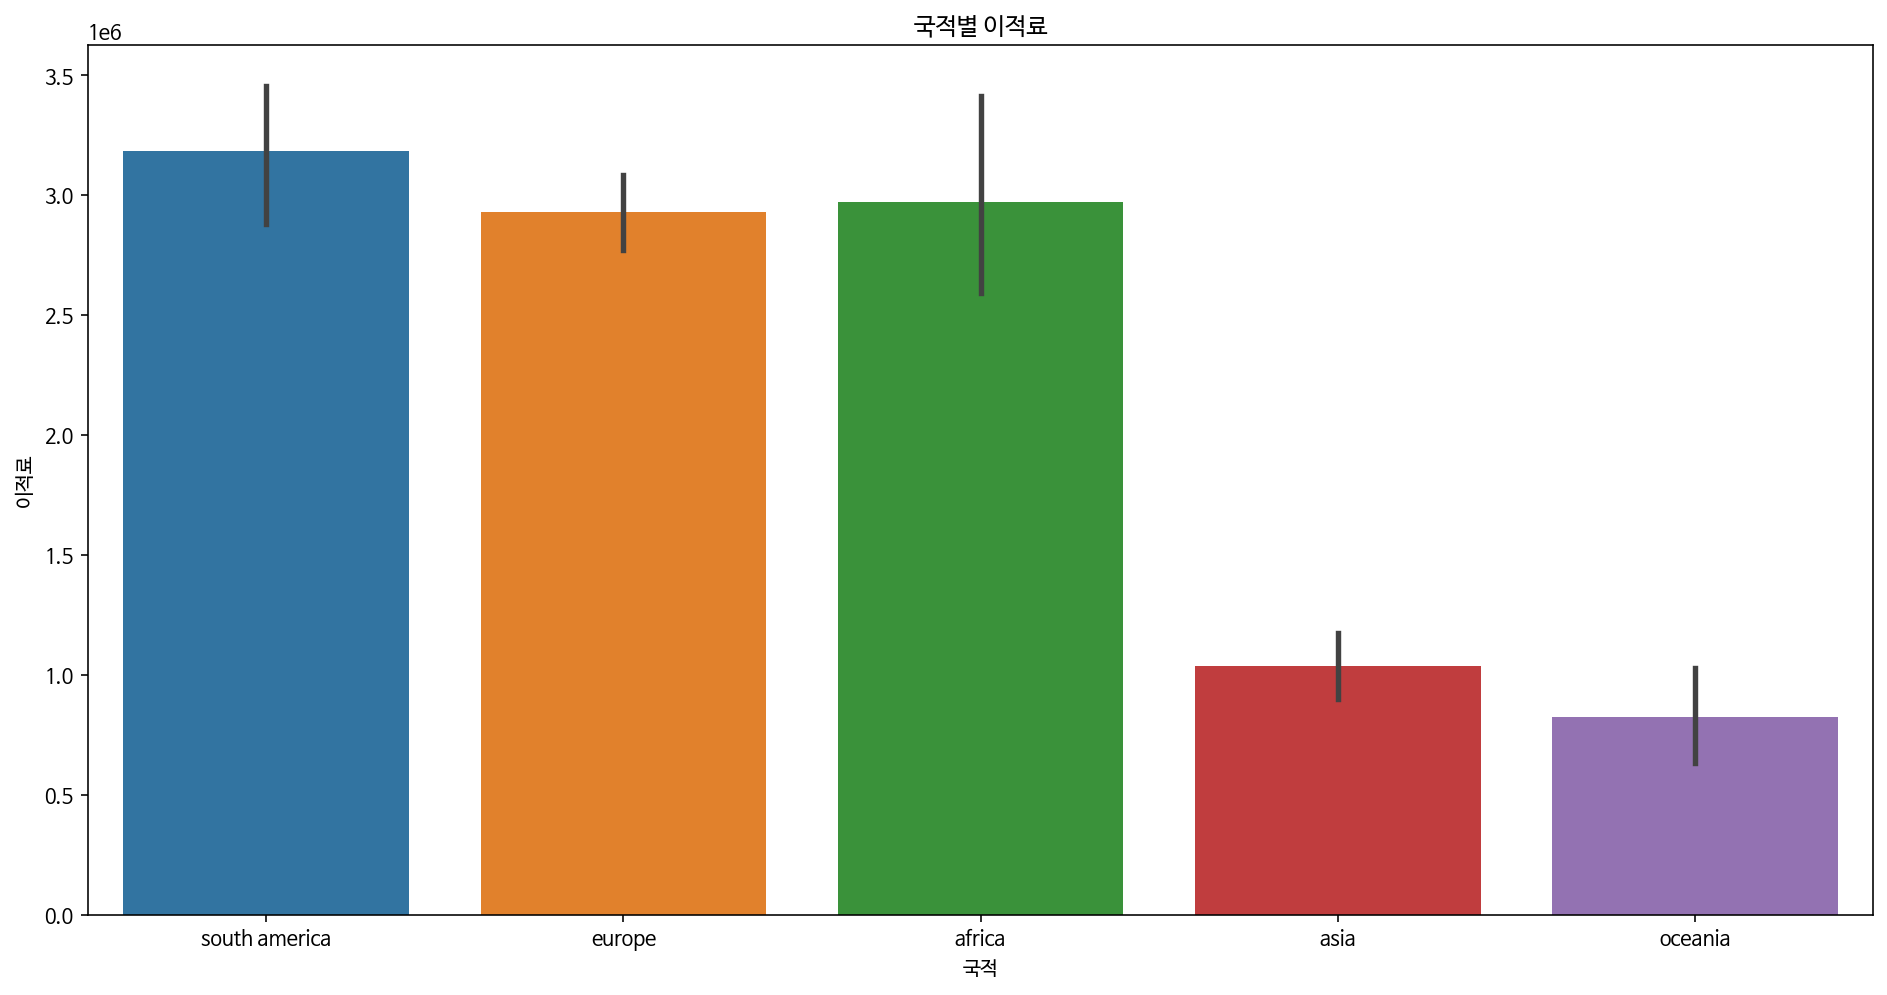

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 국적별 이적료 막대 그래프
sns.barplot(x="continent", y="value", data=train)

# 설정
axe.set(title = "국적별 이적료",
      xlabel="국적",
      ylabel="이적료")

#### 포지션별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '포지션'), Text(0.5, 1.0, '포지션별 이적료')]

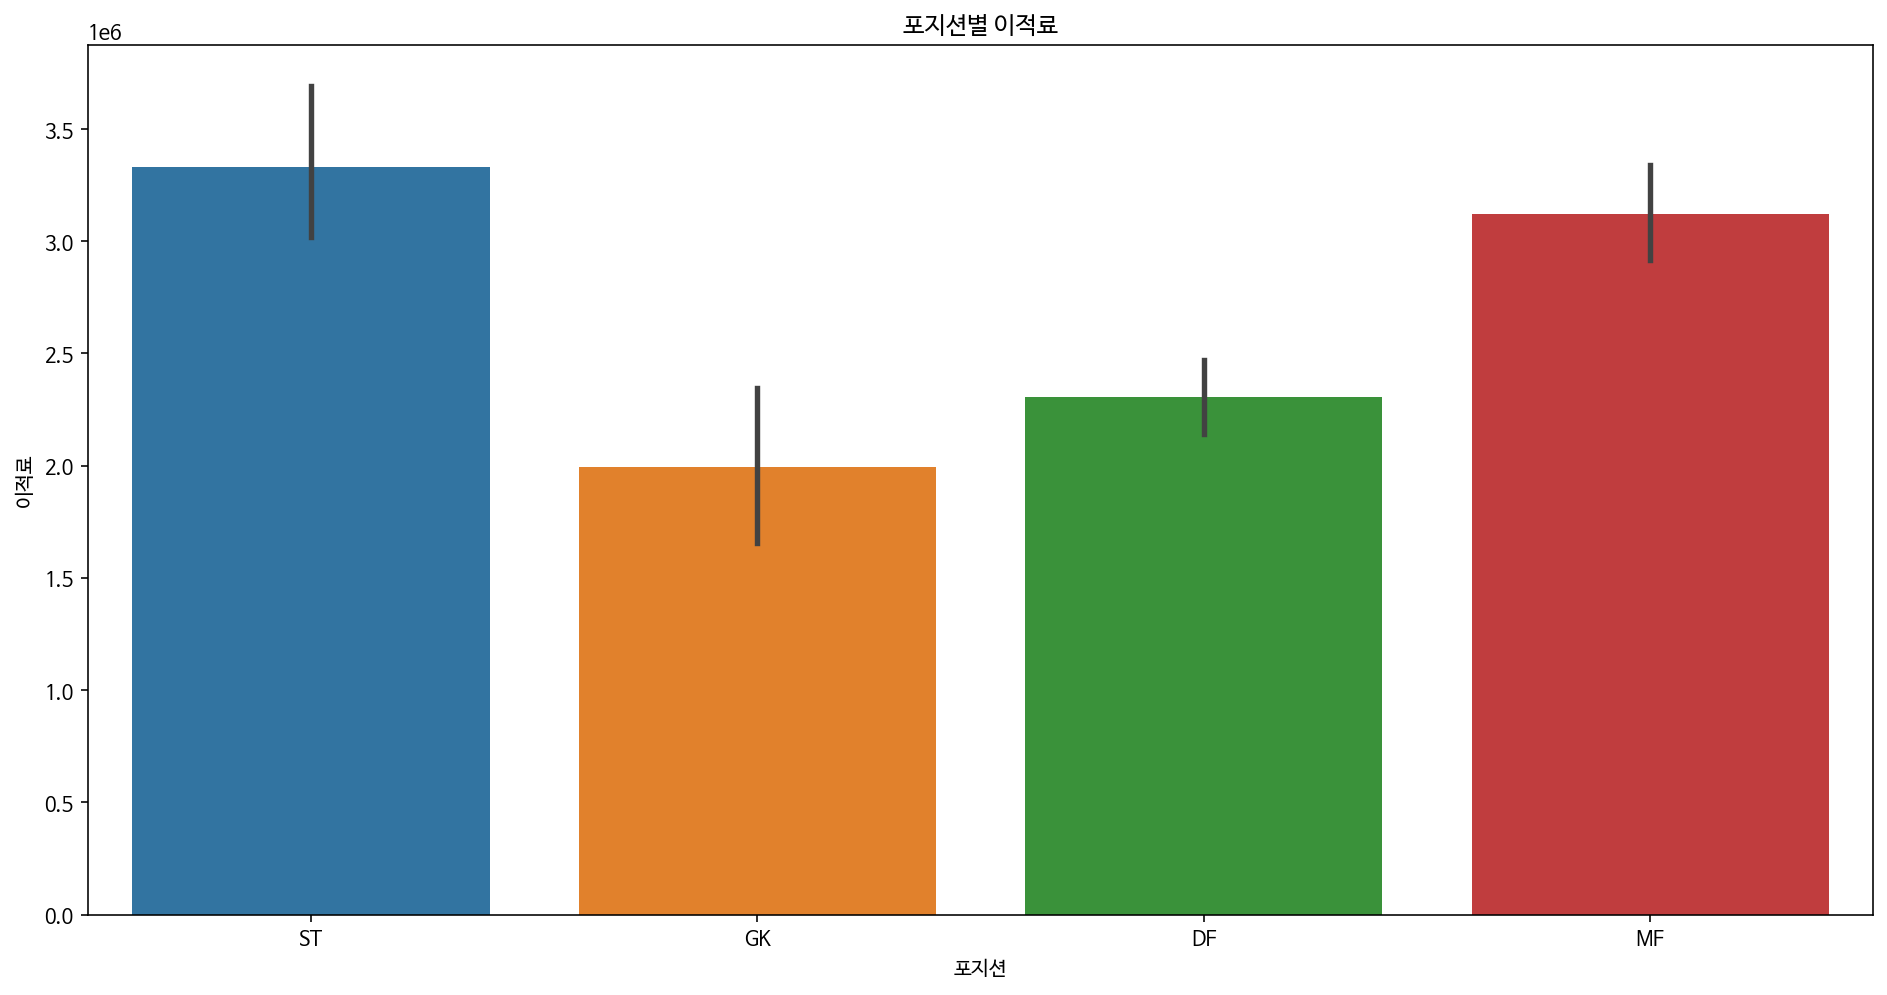

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 포지션별 이적료 막대 그래프
sns.barplot(x="position", y="value", data=train)

# 설정
axe.set(title = "포지션별 이적료",
      xlabel="포지션",
      ylabel="이적료")

#### 선호하는 발별 이적료

[Text(0, 0.5, '이적료'), Text(0.5, 0, '선호하는 발'), Text(0.5, 1.0, '선호하는 발별 이적료')]

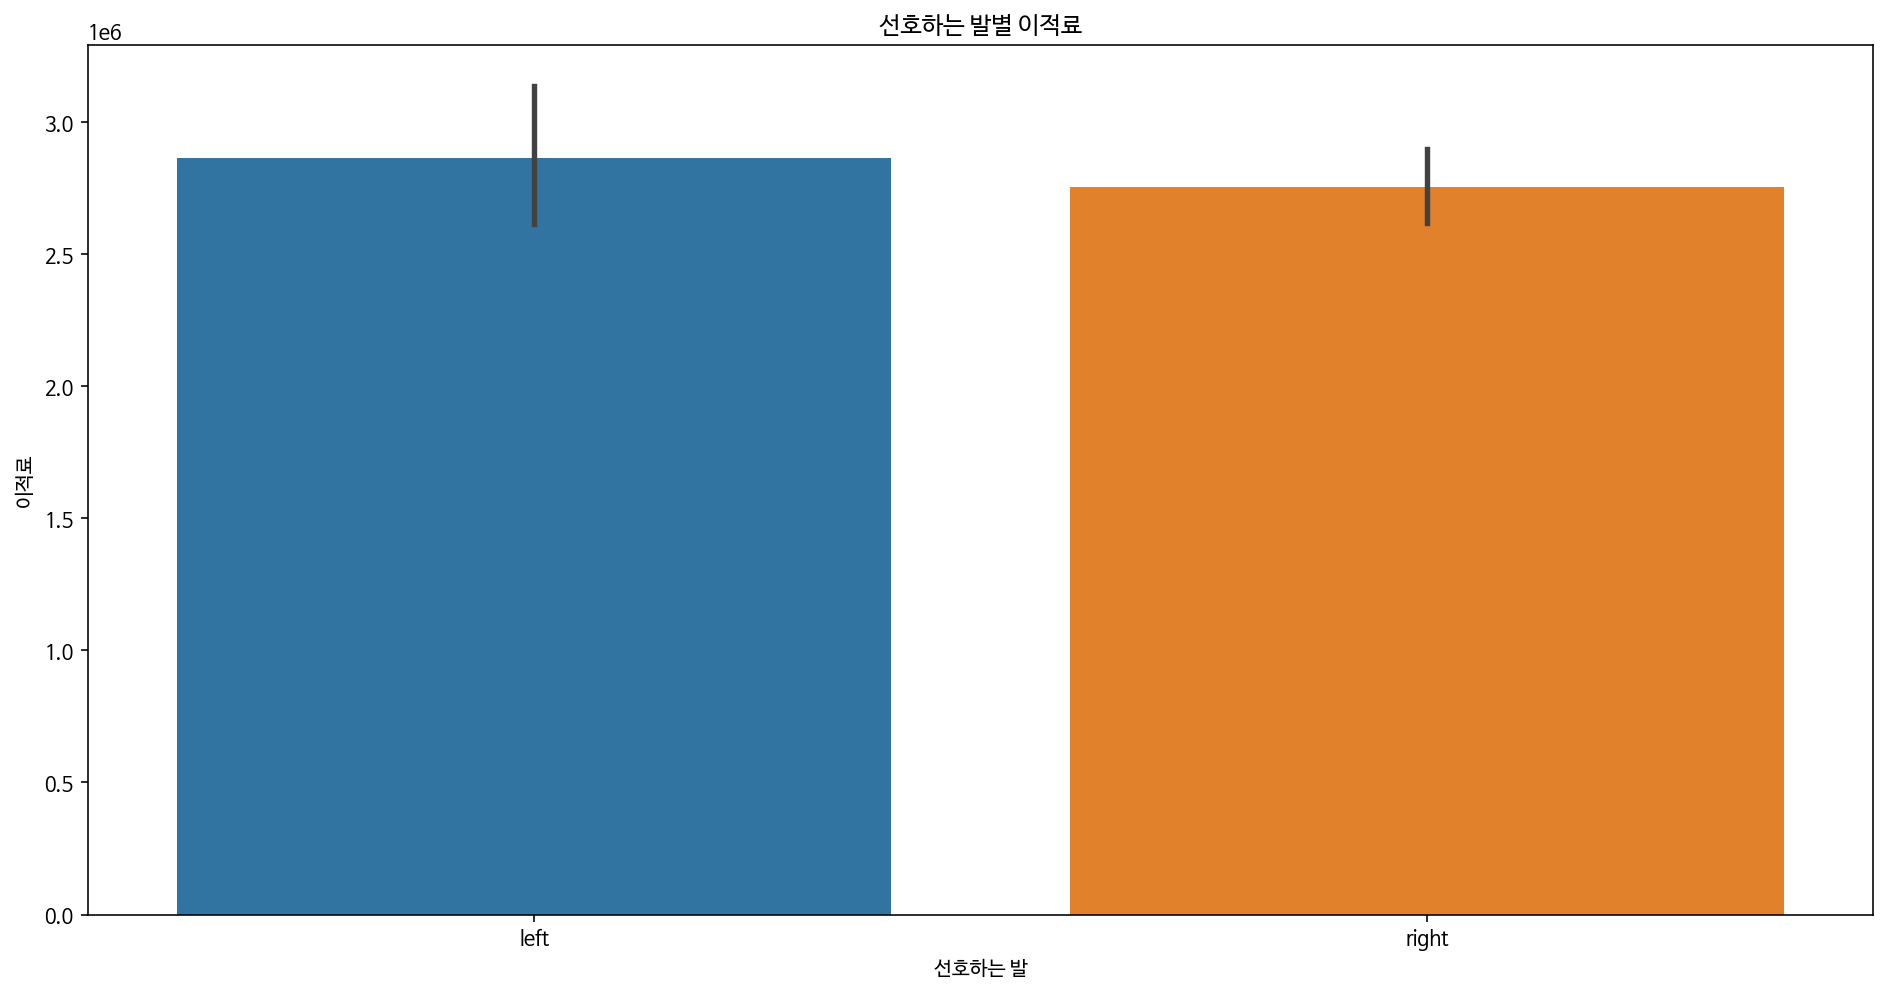

In [ ]:
# 도화지 그리기
fig, axe = plt.subplots()
fig.set_size_inches(16,8)

# 선호하는 발별 이적료 막대 그래프
sns.barplot(x="prefer_foot", y="value", data=train)

# 설정
axe.set(title = "선호하는 발별 이적료",
      xlabel="선호하는 발",
      ylabel="이적료")

# 4. 데이터 전처리

In [7]:
# 필요하지 않는 feature 값 제거
train.drop(['id', 'name'], axis = 1, inplace = True)
test.drop(['id', 'name'], axis = 1, inplace = True)

In [8]:
# 학습 데이터(x data)와 타겟 데이터(y data)로 나누기

y_train = train['value'] # 타겟 데이터
x_train = train.copy() # 학습 데이터

#타겟 생성 후 필요없는 열제거
del x_train['value']

In [9]:
# 카테고리 값 확인
print(x_train['continent'].unique())
print(x_train['position'].unique())
print(x_train['prefer_foot'].unique())

['south america' 'europe' 'africa' 'asia' 'oceania']
['ST' 'GK' 'DF' 'MF']
['left' 'right']


In [10]:
# categorical data를 담고있는 Series는 특수 메서드인 cat 속성이 있다.
# 이를 통해 catagories 와 codes 나 categorical 메서드 등에 쉽게 접근할 수 있다.
# 하지만 시리즈에 바로 categories나 codes를 사용하면 에러가 발생하는데 이때 이용하는 것이 cat 속성이다.

x_train['continent']=x_train['continent'].astype('category').cat.codes
test['continent'] = test['continent'].astype('category').cat.codes

x_train['position'] = x_train['position'].astype('category').cat.codes
test['position'] = test['position'].astype('category').cat.codes

x_train['prefer_foot'] = x_train['prefer_foot'].astype('category').cat.codes
test['prefer_foot'] = test['prefer_foot'].astype('category').cat.codes

In [11]:
# 계약 연도에 월, 일 값이 붙어 있는 데이터를 전처리한 뒤,
# 계약 연도에서 object -> int 로 변환
def func(string:object) -> int:
    string = string[-4:] # 계약연도가 제일 끝에 있거나 단독으로 쓰이고 있어 뒤에서 4번째부터 가지고 옴.
    return int(string)

x_train['contract_until'] = x_train['contract_until'].apply(func)
test['contract_until'] = test['contract_until'].apply(func)

In [12]:
new_train_future = pd.DataFrame(x_train['age'] * x_train['stat_overall'] * x_train['stat_potential'],columns=['inner_product'])
new_test_future = pd.DataFrame(test['age'] * test['stat_overall'] * test['stat_potential'],columns=['inner_product'])

In [13]:
x_train = pd.concat([x_train,new_train_future],axis = 1)
test = pd.concat([test,new_test_future],axis = 1)

In [14]:
# y train 확인
y_train

0       110500000.0
1        72000000.0
2        80000000.0
3        51000000.0
4        68000000.0
           ...     
8927        60000.0
8928        40000.0
8929        50000.0
8930        50000.0
8931        60000.0
Name: value, Length: 8932, dtype: float64

In [15]:
# x train 확인
x_train

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,inner_product
0,31,4,2021,3,0,5.0,94,94,4.0,273916
1,27,2,2020,1,1,4.0,91,93,1.0,228501
2,31,4,2021,3,1,5.0,91,91,3.0,256711
3,32,2,2020,0,1,4.0,91,91,3.0,264992
4,25,2,2021,1,1,3.0,90,93,1.0,209250
...,...,...,...,...,...,...,...,...,...,...
8927,18,0,2019,2,1,1.0,48,63,3.0,54432
8928,19,2,2020,0,1,1.0,47,59,2.0,52687
8929,18,4,2021,0,1,1.0,47,64,2.0,54144
8930,18,2,2021,1,1,1.0,47,65,1.0,54990


#### feature 형태 분석해보기


* 어떤 데이터로 볼 것인지, 확실한 부분
  * continent : 카테고리컬
  * position: 카테고리컬
  * stat_overall : 뉴메리컬
  * stat_potential : 뉴메리컬

* 관련없는 데이터일 가능성이 크므로, 포함되었을 경우와 포함되지 않았을 경우의 예측값 비교해보기
  * prefer_foot : 카테고리컬

* 모두 적용해보기
  * reputation : 뉴메리컬, 카테고리컬
  * contract_until : 뉴메리컬, 카테고리컬
  * age : 뉴메리컬, 카테고리컬
  * stat_skill_moves : 뉴메리컬 카테고리컬

In [16]:
x_train.keys()

Index(['age', 'continent', 'contract_until', 'position', 'prefer_foot',
       'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves',
       'inner_product'],
      dtype='object')

In [17]:
# 조합찾기 

from itertools import combinations 

arr = ['reputation' , 'stat_skill_moves']
categorics = []
for i in range(len(arr)+1):
    categorics = categorics + list(combinations(arr,i))

for k in range(len(categorics)):
    categorics[k] = list(categorics[k])

numerics = []
for i in range(len(categorics)):
    remove_set = list(categorics[i])
    numerics.append([i for i in arr if i not in remove_set])

categorical_base = ['continent', 'position']
numerical_base = ['stat_overall', 'stat_potential','contract_until', 'age','inner_product']

for k in range(len(categorics)):
    
    categorics[k] = categorical_base + categorics[k]
    numerics[k] = numerical_base + numerics[k]

In [18]:
categorics

[['continent', 'position'],
 ['continent', 'position', 'reputation'],
 ['continent', 'position', 'stat_skill_moves'],
 ['continent', 'position', 'reputation', 'stat_skill_moves']]

In [19]:
# 찾은 조합을 통한 Dataframe list
new_df = x_train.copy()
pd_list = []
for j in range(len(categorics)):
  new_df = x_train.copy()

  for categori_name in categorics[j]:


    num = len(new_df[categori_name].unique())
    make_name =[]
    for i in range(num):
      
      make_name.append(categori_name + str(i))

    en_df = pd.get_dummies(new_df[categori_name])

    en_df.columns = make_name


    del new_df[categori_name]

    new_df = pd.concat([new_df , en_df], axis=1 )

  pd_list.append(new_df)

In [20]:
# 확인

a='''
카테고리로 해석할 열들에 대한 info 입니다.
pd_list[0] == {}
pd_list[1] == {}
pd_list[2] == {}
pd_list[3] == {}
'''.format(categorics[0],categorics[1],categorics[2],categorics[3])


print(a)


카테고리로 해석할 열들에 대한 info 입니다.
pd_list[0] == ['continent', 'position']
pd_list[1] == ['continent', 'position', 'reputation']
pd_list[2] == ['continent', 'position', 'stat_skill_moves']
pd_list[3] == ['continent', 'position', 'reputation', 'stat_skill_moves']



In [16]:
# 딥 러닝에 사용할 데이터 셋
# x_train = pd_list[0]

In [ ]:
# 선호하는 발 사용 여부 -> 선택사항

# for i in range(4):
#     del pd_list[0]['prefer_foot']
#     del pd_list[1]['prefer_foot']
#     del pd_list[2]['prefer_foot']
#     del pd_list[3]['prefer_foot']

#x_train = pd_list[0]

In [ ]:
# # Training & Test set 으로 나눠주기
# x_train = pd_list[2] # 인덱스 선택 가능
# x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=42) # -> 아래 딥러닝 부분에 추가함

In [ ]:
# # 데이터 셋 나누는 작업을 했을 경우 머신러닝을 위해 돌려줘야 하는 코드
# new_train = pd.concat([x_train, y_train], axis = 1)

# 5. 모델 구현 및 적용

### ML

In [ ]:
# 새로운 칼럼을 추가함. (위에 데이터 전처리에 넣을것.)
train['stat_poa'] = train['stat_potential'] * train['stat_overall'] * train['age']
train['stat_poa']

0       273916
1       228501
2       256711
3       264992
4       209250
         ...  
8927     54432
8928     52687
8929     54144
8930     54990
8931     56259
Name: stat_poa, Length: 8932, dtype: int64

In [ ]:
# 원본데이터 copy
minmax_data = train.copy()

minmax_features = ['reputation', 'stat_overall', 'stat_potential', 'stat_poa']
minmax_transformer = MinMaxScaler() # StandardScaler() # RobustScaler()

minmax_data[minmax_features] = minmax_transformer.fit_transform(minmax_data[minmax_features])

In [ ]:
# pycaret setup
model = regression.setup(data=new_train, 
              target='value', 
              session_id=42) # Random seed 

,Description,Value
0,session_id,42
1,Target,value
2,Original Data,"(7145, 17)"
3,Missing Values,False
4,Numeric Features,15
5,Categorical Features,1
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5001, 23)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='value',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
              

In [ ]:
# top RMSE
top_5_models = regression.compare_models(sort='RMSE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.494650e+05,4.152872e+11,5.969425e+05,9.884000e-01,0.1641,0.0768,1.742
gbr,Gradient Boosting Regressor,2.357594e+05,5.883233e+11,7.335664e+05,9.825000e-01,0.2913,0.1978,0.214
lightgbm,Light Gradient Boosting Machine,1.738628e+05,6.358810e+11,7.416199e+05,9.824000e-01,0.1284,0.0789,0.163
xgboost,Extreme Gradient Boosting,1.708678e+05,7.468197e+11,7.662553e+05,9.784000e-01,0.1234,0.0671,0.318
et,Extra Trees Regressor,1.871835e+05,7.592578e+11,8.207052e+05,9.784000e-01,0.1098,0.0596,0.821
rf,Random Forest Regressor,1.942102e+05,7.973534e+11,8.508558e+05,9.771000e-01,0.1049,0.0610,0.889
dt,Decision Tree Regressor,2.553601e+05,1.524593e+12,1.177912e+06,9.532000e-01,0.1480,0.0731,0.022
ada,AdaBoost Regressor,1.831562e+06,4.646755e+12,2.148666e+06,8.461000e-01,1.5980,5.2741,0.132
lr,Linear Regression,1.732384e+06,1.033056e+13,3.185170e+06,6.754000e-01,1.2799,4.4215,0.421
llar,Lasso Least Angle Regression,1.732383e+06,1.033067e+13,3.185173e+06,6.754000e-01,1.2801,4.4214,0.019


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 2
INFO:logs:[<catboost.core.CatBoostRegressor object at 0x7f68e66d1ad0>, GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False), LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
          

In [ ]:
#모델 블렌딩
blended5 = regression.blend_models(top_5_models, 10, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,145500.0375,1.832169e+11,4.280385e+05,0.9941,0.0931,0.0608
1,160274.5496,6.043737e+11,7.774147e+05,0.9791,0.1429,0.0756
2,139742.5973,2.149777e+11,4.636569e+05,0.9906,0.1364,0.0704
3,131059.6985,2.463202e+11,4.963065e+05,0.9907,0.1128,0.0697
4,161057.6928,5.626485e+11,7.500990e+05,0.9856,0.1111,0.0692
5,136948.5829,2.664567e+11,5.161944e+05,0.9902,0.1595,0.0943
6,202376.8624,7.185251e+11,8.476586e+05,0.9845,0.1415,0.0761
7,235768.2213,1.896520e+12,1.377142e+06,0.9613,0.1294,0.0755
8,157690.5011,4.546688e+11,6.742913e+05,0.9813,0.1322,0.0746


INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 3
INFO:logs:VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f68ddbfc350>),
                            ('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                         

In [ ]:
# 블렌딩 한 모델 성능평가
regression.predict_model(blended5)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f68ddbfc350>),
                            ('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,162130.0521,9.586495e+11,979106.4597,0.9752,0.1443,0.0836


,age,reputation,stat_overall,stat_potential,stat_skill_moves,stat_poa,continent_africa,continent_asia,continent_europe,continent_oceania,...,contract_until_weekday_0,contract_until_weekday_1,contract_until_weekday_2,contract_until_weekday_3,contract_until_weekday_4,contract_until_weekday_5,contract_until_weekday_6,contract_until_is_month_start_1,value,Label
0,29.0,0.00,0.425532,0.413043,2.0,0.306837,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,600000.0,6.210405e+05
1,24.0,0.00,0.425532,0.478261,3.0,0.238822,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,975000.0,9.334577e+05
2,37.0,0.00,0.531915,0.521739,1.0,0.544713,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,210000.0,3.726894e+05
3,25.0,0.00,0.425532,0.478261,2.0,0.256925,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,800000.0,7.950605e+05
4,22.0,0.00,0.531915,0.673913,3.0,0.287364,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4400000.0,4.126935e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,27.0,0.00,0.468085,0.456522,3.0,0.300530,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1100000.0,1.062641e+06
2676,29.0,0.25,0.531915,0.521739,3.0,0.384634,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3100000.0,3.026154e+06
2677,24.0,0.00,0.382979,0.434783,2.0,0.213809,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,675000.0,6.433455e+05
2678,20.0,0.00,0.276596,0.478261,3.0,0.128582,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,325000.0,3.548162e+05


In [ ]:
# 블렌딩 할때 모델 3개만
blended3 = regression.blend_models(top_5_models[:3], 10, optimize='RMSE')
regression.predict_model(blended3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,151978.1316,1.770082e+11,4.207234e+05,0.9943,0.1238,0.0784
1,164706.2508,4.504650e+11,6.711669e+05,0.9844,0.1884,0.1024
2,145331.4909,2.045724e+11,4.522968e+05,0.9910,0.1691,0.0913
3,143685.2372,2.752720e+11,5.246637e+05,0.9896,0.1452,0.0910
4,162277.2900,4.941848e+11,7.029828e+05,0.9874,0.2503,0.0911
5,151920.7933,3.079427e+11,5.549258e+05,0.9887,0.2048,0.1308
6,226308.1517,8.601776e+11,9.274576e+05,0.9814,0.1519,0.1019
7,238139.8508,1.559848e+12,1.248939e+06,0.9682,0.1872,0.0926
8,157232.9584,3.575626e+11,5.979654e+05,0.9853,0.1867,0.0975


INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 5
INFO:logs:VotingRegressor(estimators=[('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f68e689d110>),
                            ('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                         

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,174545.6356,1.104226e+12,1.050822e+06,0.9714,0.2012,0.1132


,age,reputation,stat_overall,stat_potential,stat_skill_moves,stat_poa,continent_africa,continent_asia,continent_europe,continent_oceania,...,contract_until_weekday_0,contract_until_weekday_1,contract_until_weekday_2,contract_until_weekday_3,contract_until_weekday_4,contract_until_weekday_5,contract_until_weekday_6,contract_until_is_month_start_1,value,Label
0,29.0,0.00,0.425532,0.413043,2.0,0.306837,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,600000.0,6.311035e+05
1,24.0,0.00,0.425532,0.478261,3.0,0.238822,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,975000.0,9.229252e+05
2,37.0,0.00,0.531915,0.521739,1.0,0.544713,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,210000.0,4.753970e+05
3,25.0,0.00,0.425532,0.478261,2.0,0.256925,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,800000.0,7.818086e+05
4,22.0,0.00,0.531915,0.673913,3.0,0.287364,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4400000.0,4.117462e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,27.0,0.00,0.468085,0.456522,3.0,0.300530,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1100000.0,1.106745e+06
2676,29.0,0.25,0.531915,0.521739,3.0,0.384634,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3100000.0,3.099196e+06
2677,24.0,0.00,0.382979,0.434783,2.0,0.213809,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,675000.0,6.183056e+05
2678,20.0,0.00,0.276596,0.478261,3.0,0.128582,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,325000.0,3.749101e+05


#### Catboost

pycaret 진행 결과 가장 에러가 적었기에 따로 생성

In [ ]:
# model make catboost

ctb = regression.create_model('catboost')
ctb_tuned = regression.tune_model(ctb, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,211591.0555,1.653361e+11,4.066154e+05,0.9907,0.5153,0.2561
1,296026.8446,6.463652e+11,8.039684e+05,0.9831,0.3409,0.2437
2,-0.0000,-0.000000e+00,-0.000000e+00,0.0000,-0.0000,-0.0000
3,267538.6038,4.945550e+11,7.032461e+05,0.9732,0.4178,0.2692
4,241302.1737,2.510856e+11,5.010845e+05,0.9920,0.4747,0.2098
5,330468.1709,1.550103e+12,1.245031e+06,0.9662,0.4052,0.2283
6,243810.6322,2.053668e+11,4.531741e+05,0.9871,0.4564,0.3345
7,319389.2086,2.003226e+12,1.415354e+06,0.9616,0.4405,0.2631
8,250247.2770,2.574575e+11,5.074027e+05,0.9908,0.4350,0.2775


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:<catboost.core.CatBoostRegressor object at 0x7f68d0822510>
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
# 결과 모델 점수

ctb_tuned.get_best_score()

{'learn': {'RMSE': 396002.4036923326}}

In [ ]:
#모델 학습과정에서 Dataset 열 들의 중요도를 확인
for i in range(len(ctb_tuned.feature_names_)):
  print(ctb_tuned.feature_names_[i], ctb_tuned.feature_importances_[i])

age 4.246129303993447
prefer_foot 0.005580035133622566
reputation 0.06937725559132979
stat_overall 83.2787894413274
stat_potential 10.762287341783303
stat_skill_moves 1.1102414441693813
continent0 0.0
continent1 0.0
continent2 0.0
continent3 0.0
continent4 0.0
position0 0.16239945473154924
position1 0.0
position2 0.021734739770029373
position3 0.3279331107346239
contract_until_2018 0.0
contract_until_2019 0.015371457299718236
contract_until_2020 0.0
contract_until_2021 0.0
contract_until_2022 0.0
contract_until_2023 0.0
contract_until_2024 0.0
contract_until_2025 0.00015641546558049674


### DL

In [21]:
x_train = pd_list[0] # 인덱스 선택 가능

try:
    del x_train['inner_product']
except:
    pass

In [23]:
# Training & Test set 으로 나눠주기
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=42) # -> 아래 딥러닝 부분에 추가함

In [24]:
input_dim_num = len(x_train.iloc[0])

In [27]:
#Sequential
model_origin = models.Sequential(name='model_origin')


model_origin.add(layers.Dense(input_dim=input_dim_num, units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_origin.add(layers.Dense(units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_origin.add(layers.Dense(units=input_dim_num*2, activation='relu',
                       kernel_initializer = initializers.he_uniform()))

model_origin.add(layers.Dense(units=1, activation=None))


model_origin.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_squared_error,
              metrics=['mean_squared_error']) 

# summary
model_origin.summary()

Model: "model_origin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


In [28]:
# model fitting
model_name = model_origin.name

#make check point
callback_check = tf.keras.callbacks.ModelCheckpoint( 
    filepath = '02_predictive_data/checkpoint/'+ model_name + '.h5', # 모델 저장 경로, ex) '{epoch:02d}-{val_loss:.5f}.h5'
    monitor = 'loss', # 'loss', 'val_loss', 'accuracy', etc.
    verbose = 0, # 0 or 1
    save_best_only = False, # True 오차가 줄어줄때 마다 저장
    save_weights_only = False, # True 오차가 적은 가중치를 저장
    mode = 'auto', # 'auto', 'min', 'max'
    save_freq = 'epoch', # 'epoch' or integer(== # of batches) 
    #save_freq = 5 * batch_size # == saves the model's weights every 5 epochs (variable 'batch_size' should be set already)
)


history_origin = model_origin.fit(x_train, y_train,
                                  batch_size = 100,  #default batch_size = 32
                                  epochs = 10000,
                                  callbacks = [callback_check])

Epoch 1/10000
72/72 [==============================] - 1s 2ms/step - loss: 38756010688512.0000 - mean_squared_error: 38756010688512.0000
Epoch 2/10000
72/72 [==============================] - 0s 1ms/step - loss: 38640122068992.0000 - mean_squared_error: 38640122068992.0000
Epoch 3/10000
72/72 [==============================] - 0s 1ms/step - loss: 38121265692672.0000 - mean_squared_error: 38121269886976.0000
Epoch 4/10000
72/72 [==============================] - 0s 1ms/step - loss: 36641683013632.0000 - mean_squared_error: 36641683013632.0000
Epoch 5/10000
72/72 [==============================] - 0s 1ms/step - loss: 34088301887488.0000 - mean_squared_error: 34088301887488.0000
Epoch 6/10000
72/72 [==============================] - 0s 1ms/step - loss: 31907257516032.0000 - mean_squared_error: 31907257516032.0000
Epoch 7/10000
72/72 [==============================] - 0s 1ms/step - loss: 31282402689024.0000 - mean_squared_error: 31282402689024.0000
Epoch 8/10000
72/72 [====================

72/72 [==============================] - 0s 1ms/step - loss: 30984193966080.0000 - mean_squared_error: 30984193966080.0000
Epoch 61/10000
72/72 [==============================] - 0s 1ms/step - loss: 30980647682048.0000 - mean_squared_error: 30980647682048.0000
Epoch 62/10000
72/72 [==============================] - 0s 1ms/step - loss: 30979347447808.0000 - mean_squared_error: 30979347447808.0000
Epoch 63/10000
72/72 [==============================] - 0s 1ms/step - loss: 30969205620736.0000 - mean_squared_error: 30969205620736.0000
Epoch 64/10000
72/72 [==============================] - 0s 1ms/step - loss: 30963373441024.0000 - mean_squared_error: 30963373441024.0000
Epoch 65/10000
72/72 [==============================] - 0s 1ms/step - loss: 30957568524288.0000 - mean_squared_error: 30957568524288.0000
Epoch 66/10000
72/72 [==============================] - 0s 1ms/step - loss: 30951497269248.0000 - mean_squared_error: 30951497269248.0000
Epoch 67/10000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 30074225033216.0000 - mean_squared_error: 30074225033216.0000
Epoch 120/10000
72/72 [==============================] - 0s 1ms/step - loss: 30024667234304.0000 - mean_squared_error: 30024667234304.0000
Epoch 121/10000
72/72 [==============================] - 0s 1ms/step - loss: 29966181859328.0000 - mean_squared_error: 29966181859328.0000
Epoch 122/10000
72/72 [==============================] - 0s 1ms/step - loss: 29909338554368.0000 - mean_squared_error: 29909338554368.0000
Epoch 123/10000
72/72 [==============================] - 0s 1ms/step - loss: 29836368150528.0000 - mean_squared_error: 29836368150528.0000
Epoch 124/10000
72/72 [==============================] - 0s 1ms/step - loss: 29759918571520.0000 - mean_squared_error: 29759918571520.0000
Epoch 125/10000
72/72 [==============================] - 0s 1ms/step - loss: 29681082433536.0000 - mean_squared_error: 29681082433536.0000
Epoch 126/10000
72/72 [====================

72/72 [==============================] - 0s 1ms/step - loss: 5407620726784.0000 - mean_squared_error: 5407620726784.0000
Epoch 179/10000
72/72 [==============================] - 0s 1ms/step - loss: 5262261354496.0000 - mean_squared_error: 5262260830208.0000
Epoch 180/10000
72/72 [==============================] - 0s 1ms/step - loss: 5164540362752.0000 - mean_squared_error: 5164540362752.0000
Epoch 181/10000
72/72 [==============================] - 0s 1ms/step - loss: 5079928668160.0000 - mean_squared_error: 5079928668160.0000
Epoch 182/10000
72/72 [==============================] - 0s 1ms/step - loss: 4941102972928.0000 - mean_squared_error: 4941102972928.0000
Epoch 183/10000
72/72 [==============================] - 0s 1ms/step - loss: 4863362596864.0000 - mean_squared_error: 4863362596864.0000
Epoch 184/10000
72/72 [==============================] - 0s 1ms/step - loss: 4786872123392.0000 - mean_squared_error: 4786872123392.0000
Epoch 185/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 2793147727872.0000 - mean_squared_error: 2793147727872.0000
Epoch 238/10000
72/72 [==============================] - 0s 1ms/step - loss: 2742380134400.0000 - mean_squared_error: 2742380134400.0000
Epoch 239/10000
72/72 [==============================] - 0s 1ms/step - loss: 2733351632896.0000 - mean_squared_error: 2733351632896.0000
Epoch 240/10000
72/72 [==============================] - 0s 1ms/step - loss: 2731913510912.0000 - mean_squared_error: 2731913510912.0000
Epoch 241/10000
72/72 [==============================] - 0s 1ms/step - loss: 2682930593792.0000 - mean_squared_error: 2682930593792.0000
Epoch 242/10000
72/72 [==============================] - 0s 1ms/step - loss: 2668454739968.0000 - mean_squared_error: 2668454739968.0000
Epoch 243/10000
72/72 [==============================] - 0s 1ms/step - loss: 2664299757568.0000 - mean_squared_error: 2664299757568.0000
Epoch 244/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 2095031910400.0000 - mean_squared_error: 2095031648256.0000
Epoch 297/10000
72/72 [==============================] - 0s 1ms/step - loss: 2119767687168.0000 - mean_squared_error: 2119767687168.0000
Epoch 298/10000
72/72 [==============================] - 0s 1ms/step - loss: 2086218235904.0000 - mean_squared_error: 2086218235904.0000
Epoch 299/10000
72/72 [==============================] - 0s 1ms/step - loss: 2064125001728.0000 - mean_squared_error: 2064125001728.0000
Epoch 300/10000
72/72 [==============================] - 0s 1ms/step - loss: 2053519048704.0000 - mean_squared_error: 2053518786560.0000
Epoch 301/10000
72/72 [==============================] - 0s 1ms/step - loss: 2092655443968.0000 - mean_squared_error: 2092655443968.0000
Epoch 302/10000
72/72 [==============================] - 0s 1ms/step - loss: 2060633767936.0000 - mean_squared_error: 2060633767936.0000
Epoch 303/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1810636472320.0000 - mean_squared_error: 1810636472320.0000
Epoch 356/10000
72/72 [==============================] - 0s 1ms/step - loss: 1833204580352.0000 - mean_squared_error: 1833204580352.0000
Epoch 357/10000
72/72 [==============================] - 0s 1ms/step - loss: 1821362225152.0000 - mean_squared_error: 1821362225152.0000
Epoch 358/10000
72/72 [==============================] - 0s 1ms/step - loss: 1818522025984.0000 - mean_squared_error: 1818522157056.0000
Epoch 359/10000
72/72 [==============================] - 0s 1ms/step - loss: 1798365511680.0000 - mean_squared_error: 1798365511680.0000
Epoch 360/10000
72/72 [==============================] - 0s 1ms/step - loss: 1807072886784.0000 - mean_squared_error: 1807072886784.0000
Epoch 361/10000
72/72 [==============================] - 0s 1ms/step - loss: 1776568107008.0000 - mean_squared_error: 1776568107008.0000
Epoch 362/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1689782452224.0000 - mean_squared_error: 1689782452224.0000
Epoch 415/10000
72/72 [==============================] - 0s 1ms/step - loss: 1625890619392.0000 - mean_squared_error: 1625890619392.0000
Epoch 416/10000
72/72 [==============================] - 0s 1ms/step - loss: 1680165699584.0000 - mean_squared_error: 1680165699584.0000
Epoch 417/10000
72/72 [==============================] - 0s 1ms/step - loss: 1641527771136.0000 - mean_squared_error: 1641527771136.0000
Epoch 418/10000
72/72 [==============================] - 0s 1ms/step - loss: 1642405953536.0000 - mean_squared_error: 1642405953536.0000
Epoch 419/10000
72/72 [==============================] - 0s 1ms/step - loss: 1648713662464.0000 - mean_squared_error: 1648713662464.0000
Epoch 420/10000
72/72 [==============================] - 0s 1ms/step - loss: 1621673377792.0000 - mean_squared_error: 1621673377792.0000
Epoch 421/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1540842717184.0000 - mean_squared_error: 1540842717184.0000
Epoch 474/10000
72/72 [==============================] - 0s 1ms/step - loss: 1507042000896.0000 - mean_squared_error: 1507042000896.0000
Epoch 475/10000
72/72 [==============================] - 0s 1ms/step - loss: 1513738207232.0000 - mean_squared_error: 1513738207232.0000
Epoch 476/10000
72/72 [==============================] - 0s 1ms/step - loss: 1520902733824.0000 - mean_squared_error: 1520902733824.0000
Epoch 477/10000
72/72 [==============================] - 0s 1ms/step - loss: 1538367684608.0000 - mean_squared_error: 1538367684608.0000
Epoch 478/10000
72/72 [==============================] - 0s 1ms/step - loss: 1526708305920.0000 - mean_squared_error: 1526708436992.0000
Epoch 479/10000
72/72 [==============================] - 0s 1ms/step - loss: 1528497831936.0000 - mean_squared_error: 1528497831936.0000
Epoch 480/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1448549154816.0000 - mean_squared_error: 1448549154816.0000
Epoch 533/10000
72/72 [==============================] - 0s 1ms/step - loss: 1443090137088.0000 - mean_squared_error: 1443090137088.0000
Epoch 534/10000
72/72 [==============================] - 0s 1ms/step - loss: 1421480034304.0000 - mean_squared_error: 1421480034304.0000
Epoch 535/10000
72/72 [==============================] - 0s 1ms/step - loss: 1445247188992.0000 - mean_squared_error: 1445247188992.0000
Epoch 536/10000
72/72 [==============================] - 0s 1ms/step - loss: 1432488902656.0000 - mean_squared_error: 1432488902656.0000
Epoch 537/10000
72/72 [==============================] - 0s 1ms/step - loss: 1439163875328.0000 - mean_squared_error: 1439163875328.0000
Epoch 538/10000
72/72 [==============================] - 0s 1ms/step - loss: 1416596684800.0000 - mean_squared_error: 1416596684800.0000
Epoch 539/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1363827490816.0000 - mean_squared_error: 1363827490816.0000
Epoch 592/10000
72/72 [==============================] - 0s 1ms/step - loss: 1377960591360.0000 - mean_squared_error: 1377960460288.0000
Epoch 593/10000
72/72 [==============================] - 0s 1ms/step - loss: 1372162097152.0000 - mean_squared_error: 1372162097152.0000
Epoch 594/10000
72/72 [==============================] - 0s 1ms/step - loss: 1352505622528.0000 - mean_squared_error: 1352505622528.0000
Epoch 595/10000
72/72 [==============================] - 0s 1ms/step - loss: 1369448382464.0000 - mean_squared_error: 1369448251392.0000
Epoch 596/10000
72/72 [==============================] - 0s 1ms/step - loss: 1347646259200.0000 - mean_squared_error: 1347646259200.0000
Epoch 597/10000
72/72 [==============================] - 0s 1ms/step - loss: 1340006989824.0000 - mean_squared_error: 1340006989824.0000
Epoch 598/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1299619250176.0000 - mean_squared_error: 1299619250176.0000
Epoch 651/10000
72/72 [==============================] - 0s 1ms/step - loss: 1286643515392.0000 - mean_squared_error: 1286643515392.0000
Epoch 652/10000
72/72 [==============================] - 0s 1ms/step - loss: 1334668427264.0000 - mean_squared_error: 1334668427264.0000
Epoch 653/10000
72/72 [==============================] - 0s 1ms/step - loss: 1305325469696.0000 - mean_squared_error: 1305325469696.0000
Epoch 654/10000
72/72 [==============================] - 0s 1ms/step - loss: 1307447918592.0000 - mean_squared_error: 1307447918592.0000
Epoch 655/10000
72/72 [==============================] - 0s 1ms/step - loss: 1287413170176.0000 - mean_squared_error: 1287413170176.0000
Epoch 656/10000
72/72 [==============================] - 0s 1ms/step - loss: 1297617125376.0000 - mean_squared_error: 1297617125376.0000
Epoch 657/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1252365565952.0000 - mean_squared_error: 1252365565952.0000
Epoch 710/10000
72/72 [==============================] - 0s 1ms/step - loss: 1304808259584.0000 - mean_squared_error: 1304808259584.0000
Epoch 711/10000
72/72 [==============================] - 0s 1ms/step - loss: 1238326444032.0000 - mean_squared_error: 1238326575104.0000
Epoch 712/10000
72/72 [==============================] - 0s 1ms/step - loss: 1291954159616.0000 - mean_squared_error: 1291954159616.0000
Epoch 713/10000
72/72 [==============================] - 0s 1ms/step - loss: 1253754667008.0000 - mean_squared_error: 1253754667008.0000
Epoch 714/10000
72/72 [==============================] - 0s 1ms/step - loss: 1245412589568.0000 - mean_squared_error: 1245412589568.0000
Epoch 715/10000
72/72 [==============================] - 0s 1ms/step - loss: 1229387333632.0000 - mean_squared_error: 1229387333632.0000
Epoch 716/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1239759323136.0000 - mean_squared_error: 1239759323136.0000
Epoch 769/10000
72/72 [==============================] - 0s 1ms/step - loss: 1196982140928.0000 - mean_squared_error: 1196982140928.0000
Epoch 770/10000
72/72 [==============================] - 0s 1ms/step - loss: 1210379534336.0000 - mean_squared_error: 1210379534336.0000
Epoch 771/10000
72/72 [==============================] - 0s 1ms/step - loss: 1224478162944.0000 - mean_squared_error: 1224478162944.0000
Epoch 772/10000
72/72 [==============================] - 0s 1ms/step - loss: 1211099512832.0000 - mean_squared_error: 1211099512832.0000
Epoch 773/10000
72/72 [==============================] - 0s 1ms/step - loss: 1198205698048.0000 - mean_squared_error: 1198205698048.0000
Epoch 774/10000
72/72 [==============================] - 0s 1ms/step - loss: 1198622638080.0000 - mean_squared_error: 1198622638080.0000
Epoch 775/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1147659091968.0000 - mean_squared_error: 1147659091968.0000
Epoch 828/10000
72/72 [==============================] - 0s 1ms/step - loss: 1146039828480.0000 - mean_squared_error: 1146039828480.0000
Epoch 829/10000
72/72 [==============================] - 0s 1ms/step - loss: 1211243560960.0000 - mean_squared_error: 1211243560960.0000
Epoch 830/10000
72/72 [==============================] - 0s 1ms/step - loss: 1205011087360.0000 - mean_squared_error: 1205011218432.0000
Epoch 831/10000
72/72 [==============================] - 0s 1ms/step - loss: 1141935308800.0000 - mean_squared_error: 1141935308800.0000
Epoch 832/10000
72/72 [==============================] - 0s 1ms/step - loss: 1152173080576.0000 - mean_squared_error: 1152173080576.0000
Epoch 833/10000
72/72 [==============================] - 0s 1ms/step - loss: 1146542227456.0000 - mean_squared_error: 1146542227456.0000
Epoch 834/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1125849497600.0000 - mean_squared_error: 1125849497600.0000
Epoch 887/10000
72/72 [==============================] - 0s 1ms/step - loss: 1130686185472.0000 - mean_squared_error: 1130686185472.0000
Epoch 888/10000
72/72 [==============================] - 0s 1ms/step - loss: 1105210376192.0000 - mean_squared_error: 1105210376192.0000
Epoch 889/10000
72/72 [==============================] - 0s 1ms/step - loss: 1136513908736.0000 - mean_squared_error: 1136513908736.0000
Epoch 890/10000
72/72 [==============================] - 0s 1ms/step - loss: 1118838718464.0000 - mean_squared_error: 1118838718464.0000
Epoch 891/10000
72/72 [==============================] - 0s 1ms/step - loss: 1106894127104.0000 - mean_squared_error: 1106894127104.0000
Epoch 892/10000
72/72 [==============================] - 0s 1ms/step - loss: 1132988334080.0000 - mean_squared_error: 1132988334080.0000
Epoch 893/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1088284196864.0000 - mean_squared_error: 1088284196864.0000
Epoch 946/10000
72/72 [==============================] - 0s 1ms/step - loss: 1083184381952.0000 - mean_squared_error: 1083184381952.0000
Epoch 947/10000
72/72 [==============================] - 0s 1ms/step - loss: 1067207491584.0000 - mean_squared_error: 1067207491584.0000
Epoch 948/10000
72/72 [==============================] - 0s 1ms/step - loss: 1079594975232.0000 - mean_squared_error: 1079594975232.0000
Epoch 949/10000
72/72 [==============================] - 0s 1ms/step - loss: 1104030466048.0000 - mean_squared_error: 1104030466048.0000
Epoch 950/10000
72/72 [==============================] - 0s 1ms/step - loss: 1111726096384.0000 - mean_squared_error: 1111726096384.0000
Epoch 951/10000
72/72 [==============================] - 0s 1ms/step - loss: 1140457996288.0000 - mean_squared_error: 1140457996288.0000
Epoch 952/10000
72/72 [==============================] - 

72/72 [==============================] - 0s 1ms/step - loss: 1051091075072.0000 - mean_squared_error: 1051091075072.0000
Epoch 1005/10000
72/72 [==============================] - 0s 1ms/step - loss: 1041792040960.0000 - mean_squared_error: 1041792040960.0000
Epoch 1006/10000
72/72 [==============================] - 0s 1ms/step - loss: 1049127616512.0000 - mean_squared_error: 1049127616512.0000
Epoch 1007/10000
72/72 [==============================] - 0s 1ms/step - loss: 1042072010752.0000 - mean_squared_error: 1042072010752.0000
Epoch 1008/10000
72/72 [==============================] - 0s 1ms/step - loss: 1058779693056.0000 - mean_squared_error: 1058779693056.0000
Epoch 1009/10000
72/72 [==============================] - 0s 1ms/step - loss: 1034651041792.0000 - mean_squared_error: 1034651041792.0000
Epoch 1010/10000
72/72 [==============================] - 0s 1ms/step - loss: 1050373849088.0000 - mean_squared_error: 1050373849088.0000
Epoch 1011/10000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 1019289010176.0000 - mean_squared_error: 1019289010176.0000
Epoch 1064/10000
72/72 [==============================] - 0s 1ms/step - loss: 1017907970048.0000 - mean_squared_error: 1017907970048.0000
Epoch 1065/10000
72/72 [==============================] - 0s 1ms/step - loss: 1029931597824.0000 - mean_squared_error: 1029931597824.0000
Epoch 1066/10000
72/72 [==============================] - 0s 1ms/step - loss: 1018856341504.0000 - mean_squared_error: 1018856341504.0000
Epoch 1067/10000
72/72 [==============================] - 0s 1ms/step - loss: 1018808238080.0000 - mean_squared_error: 1018808238080.0000
Epoch 1068/10000
72/72 [==============================] - 0s 1ms/step - loss: 1040599875584.0000 - mean_squared_error: 1040599875584.0000
Epoch 1069/10000
72/72 [==============================] - 0s 1ms/step - loss: 1075681099776.0000 - mean_squared_error: 1075681099776.0000
Epoch 1070/10000
72/72 [===========================

72/72 [==============================] - 0s 1ms/step - loss: 1015534714880.0000 - mean_squared_error: 1015534845952.0000
Epoch 1123/10000
72/72 [==============================] - 0s 1ms/step - loss: 978006507520.0000 - mean_squared_error: 978006507520.0000
Epoch 1124/10000
72/72 [==============================] - 0s 1ms/step - loss: 1013426618368.0000 - mean_squared_error: 1013426618368.0000
Epoch 1125/10000
72/72 [==============================] - 0s 1ms/step - loss: 995343663104.0000 - mean_squared_error: 995343663104.0000
Epoch 1126/10000
72/72 [==============================] - 0s 1ms/step - loss: 1007831941120.0000 - mean_squared_error: 1007831941120.0000
Epoch 1127/10000
72/72 [==============================] - 0s 1ms/step - loss: 1001739386880.0000 - mean_squared_error: 1001739386880.0000
Epoch 1128/10000
72/72 [==============================] - 0s 1ms/step - loss: 1006551629824.0000 - mean_squared_error: 1006551629824.0000
Epoch 1129/10000
72/72 [==============================]

72/72 [==============================] - 0s 1ms/step - loss: 980981776384.0000 - mean_squared_error: 980981776384.0000
Epoch 1183/10000
72/72 [==============================] - 0s 1ms/step - loss: 968960901120.0000 - mean_squared_error: 968960901120.0000
Epoch 1184/10000
72/72 [==============================] - 0s 1ms/step - loss: 975352299520.0000 - mean_squared_error: 975352299520.0000
Epoch 1185/10000
72/72 [==============================] - 0s 1ms/step - loss: 1005639237632.0000 - mean_squared_error: 1005639237632.0000
Epoch 1186/10000
72/72 [==============================] - 0s 1ms/step - loss: 950770860032.0000 - mean_squared_error: 950770860032.0000
Epoch 1187/10000
72/72 [==============================] - 0s 1ms/step - loss: 976633266176.0000 - mean_squared_error: 976633266176.0000
Epoch 1188/10000
72/72 [==============================] - 0s 1ms/step - loss: 1000422834176.0000 - mean_squared_error: 1000422834176.0000
Epoch 1189/10000
72/72 [==============================] - 0s 

72/72 [==============================] - 0s 1ms/step - loss: 958314512384.0000 - mean_squared_error: 958314512384.0000
Epoch 1243/10000
72/72 [==============================] - 0s 1ms/step - loss: 925732634624.0000 - mean_squared_error: 925732634624.0000
Epoch 1244/10000
72/72 [==============================] - 0s 1ms/step - loss: 940523585536.0000 - mean_squared_error: 940523585536.0000
Epoch 1245/10000
72/72 [==============================] - 0s 1ms/step - loss: 963258548224.0000 - mean_squared_error: 963258548224.0000
Epoch 1246/10000
72/72 [==============================] - 0s 1ms/step - loss: 950597976064.0000 - mean_squared_error: 950597976064.0000
Epoch 1247/10000
72/72 [==============================] - 0s 1ms/step - loss: 920501026816.0000 - mean_squared_error: 920501026816.0000
Epoch 1248/10000
72/72 [==============================] - 0s 1ms/step - loss: 948166328320.0000 - mean_squared_error: 948166328320.0000
Epoch 1249/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 921972310016.0000 - mean_squared_error: 921972310016.0000
Epoch 1303/10000
72/72 [==============================] - 0s 1ms/step - loss: 904975548416.0000 - mean_squared_error: 904975548416.0000
Epoch 1304/10000
72/72 [==============================] - 0s 1ms/step - loss: 918428647424.0000 - mean_squared_error: 918428647424.0000
Epoch 1305/10000
72/72 [==============================] - 0s 1ms/step - loss: 925844766720.0000 - mean_squared_error: 925844766720.0000
Epoch 1306/10000
72/72 [==============================] - 0s 1ms/step - loss: 897856307200.0000 - mean_squared_error: 897856307200.0000
Epoch 1307/10000
72/72 [==============================] - 0s 1ms/step - loss: 958563221504.0000 - mean_squared_error: 958563287040.0000
Epoch 1308/10000
72/72 [==============================] - 0s 1ms/step - loss: 893332094976.0000 - mean_squared_error: 893332094976.0000
Epoch 1309/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 905590800384.0000 - mean_squared_error: 905590800384.0000
Epoch 1363/10000
72/72 [==============================] - 0s 1ms/step - loss: 871176011776.0000 - mean_squared_error: 871176011776.0000
Epoch 1364/10000
72/72 [==============================] - 0s 1ms/step - loss: 881072668672.0000 - mean_squared_error: 881072668672.0000
Epoch 1365/10000
72/72 [==============================] - 0s 1ms/step - loss: 900787535872.0000 - mean_squared_error: 900787535872.0000
Epoch 1366/10000
72/72 [==============================] - 0s 2ms/step - loss: 894160797696.0000 - mean_squared_error: 894160863232.0000
Epoch 1367/10000
72/72 [==============================] - 0s 1ms/step - loss: 880628334592.0000 - mean_squared_error: 880628334592.0000
Epoch 1368/10000
72/72 [==============================] - 0s 1ms/step - loss: 900606328832.0000 - mean_squared_error: 900606394368.0000
Epoch 1369/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 870755532800.0000 - mean_squared_error: 870755532800.0000
Epoch 1423/10000
72/72 [==============================] - 0s 1ms/step - loss: 856959877120.0000 - mean_squared_error: 856959746048.0000
Epoch 1424/10000
72/72 [==============================] - 0s 1ms/step - loss: 861697277952.0000 - mean_squared_error: 861697277952.0000
Epoch 1425/10000
72/72 [==============================] - 0s 1ms/step - loss: 886306635776.0000 - mean_squared_error: 886306635776.0000
Epoch 1426/10000
72/72 [==============================] - 0s 1ms/step - loss: 853279965184.0000 - mean_squared_error: 853279965184.0000
Epoch 1427/10000
72/72 [==============================] - 0s 1ms/step - loss: 877862060032.0000 - mean_squared_error: 877862060032.0000
Epoch 1428/10000
72/72 [==============================] - 0s 1ms/step - loss: 867538436096.0000 - mean_squared_error: 867538436096.0000
Epoch 1429/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 835133177856.0000 - mean_squared_error: 835133308928.0000
Epoch 1483/10000
72/72 [==============================] - 0s 1ms/step - loss: 870284132352.0000 - mean_squared_error: 870284132352.0000
Epoch 1484/10000
72/72 [==============================] - 0s 1ms/step - loss: 842540187648.0000 - mean_squared_error: 842540187648.0000
Epoch 1485/10000
72/72 [==============================] - 0s 1ms/step - loss: 852194033664.0000 - mean_squared_error: 852194033664.0000
Epoch 1486/10000
72/72 [==============================] - 0s 1ms/step - loss: 855794778112.0000 - mean_squared_error: 855794778112.0000
Epoch 1487/10000
72/72 [==============================] - 0s 1ms/step - loss: 878804402176.0000 - mean_squared_error: 878804467712.0000
Epoch 1488/10000
72/72 [==============================] - 0s 1ms/step - loss: 854318841856.0000 - mean_squared_error: 854318841856.0000
Epoch 1489/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 859039137792.0000 - mean_squared_error: 859039006720.0000
Epoch 1543/10000
72/72 [==============================] - 0s 1ms/step - loss: 834669117440.0000 - mean_squared_error: 834669117440.0000
Epoch 1544/10000
72/72 [==============================] - 0s 1ms/step - loss: 831701581824.0000 - mean_squared_error: 831701581824.0000
Epoch 1545/10000
72/72 [==============================] - 0s 1ms/step - loss: 860648505344.0000 - mean_squared_error: 860648505344.0000
Epoch 1546/10000
72/72 [==============================] - 0s 1ms/step - loss: 825408094208.0000 - mean_squared_error: 825408094208.0000
Epoch 1547/10000
72/72 [==============================] - 0s 1ms/step - loss: 848773971968.0000 - mean_squared_error: 848773971968.0000
Epoch 1548/10000
72/72 [==============================] - 0s 1ms/step - loss: 862624940032.0000 - mean_squared_error: 862624940032.0000
Epoch 1549/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 844713164800.0000 - mean_squared_error: 844713164800.0000
Epoch 1603/10000
72/72 [==============================] - 0s 1ms/step - loss: 823332438016.0000 - mean_squared_error: 823332438016.0000
Epoch 1604/10000
72/72 [==============================] - 0s 1ms/step - loss: 820427620352.0000 - mean_squared_error: 820427620352.0000
Epoch 1605/10000
72/72 [==============================] - 0s 1ms/step - loss: 815020900352.0000 - mean_squared_error: 815020900352.0000
Epoch 1606/10000
72/72 [==============================] - 0s 1ms/step - loss: 787575341056.0000 - mean_squared_error: 787575341056.0000
Epoch 1607/10000
72/72 [==============================] - 0s 1ms/step - loss: 846969372672.0000 - mean_squared_error: 846969372672.0000
Epoch 1608/10000
72/72 [==============================] - 0s 1ms/step - loss: 846979858432.0000 - mean_squared_error: 846979858432.0000
Epoch 1609/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 815015329792.0000 - mean_squared_error: 815015329792.0000
Epoch 1663/10000
72/72 [==============================] - 0s 1ms/step - loss: 811583078400.0000 - mean_squared_error: 811583078400.0000
Epoch 1664/10000
72/72 [==============================] - 0s 1ms/step - loss: 795867480064.0000 - mean_squared_error: 795867480064.0000
Epoch 1665/10000
72/72 [==============================] - 0s 1ms/step - loss: 800972013568.0000 - mean_squared_error: 800972013568.0000
Epoch 1666/10000
72/72 [==============================] - 0s 1ms/step - loss: 801039187968.0000 - mean_squared_error: 801039187968.0000
Epoch 1667/10000
72/72 [==============================] - 0s 1ms/step - loss: 795444838400.0000 - mean_squared_error: 795444838400.0000
Epoch 1668/10000
72/72 [==============================] - 0s 1ms/step - loss: 830270078976.0000 - mean_squared_error: 830270013440.0000
Epoch 1669/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 775971995648.0000 - mean_squared_error: 775971995648.0000
Epoch 1723/10000
72/72 [==============================] - 0s 1ms/step - loss: 765356736512.0000 - mean_squared_error: 765356736512.0000
Epoch 1724/10000
72/72 [==============================] - 0s 1ms/step - loss: 794573275136.0000 - mean_squared_error: 794573275136.0000
Epoch 1725/10000
72/72 [==============================] - 0s 1ms/step - loss: 775589134336.0000 - mean_squared_error: 775589134336.0000
Epoch 1726/10000
72/72 [==============================] - 0s 1ms/step - loss: 813283999744.0000 - mean_squared_error: 813283999744.0000
Epoch 1727/10000
72/72 [==============================] - 0s 1ms/step - loss: 775396261888.0000 - mean_squared_error: 775396261888.0000
Epoch 1728/10000
72/72 [==============================] - 0s 1ms/step - loss: 818377326592.0000 - mean_squared_error: 818377326592.0000
Epoch 1729/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 768662437888.0000 - mean_squared_error: 768662437888.0000
Epoch 1783/10000
72/72 [==============================] - 0s 1ms/step - loss: 755158548480.0000 - mean_squared_error: 755158548480.0000
Epoch 1784/10000
72/72 [==============================] - 0s 1ms/step - loss: 780214534144.0000 - mean_squared_error: 780214534144.0000
Epoch 1785/10000
72/72 [==============================] - 0s 1ms/step - loss: 769948319744.0000 - mean_squared_error: 769948319744.0000
Epoch 1786/10000
72/72 [==============================] - 0s 1ms/step - loss: 779462705152.0000 - mean_squared_error: 779462705152.0000
Epoch 1787/10000
72/72 [==============================] - 0s 1ms/step - loss: 757030649856.0000 - mean_squared_error: 757030649856.0000
Epoch 1788/10000
72/72 [==============================] - 0s 1ms/step - loss: 754396233728.0000 - mean_squared_error: 754396233728.0000
Epoch 1789/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 739257810944.0000 - mean_squared_error: 739257810944.0000
Epoch 1843/10000
72/72 [==============================] - 0s 1ms/step - loss: 770436300800.0000 - mean_squared_error: 770436366336.0000
Epoch 1844/10000
72/72 [==============================] - 0s 1ms/step - loss: 744884207616.0000 - mean_squared_error: 744884207616.0000
Epoch 1845/10000
72/72 [==============================] - 0s 1ms/step - loss: 750250754048.0000 - mean_squared_error: 750250754048.0000
Epoch 1846/10000
72/72 [==============================] - 0s 1ms/step - loss: 758569238528.0000 - mean_squared_error: 758569238528.0000
Epoch 1847/10000
72/72 [==============================] - 0s 1ms/step - loss: 753474600960.0000 - mean_squared_error: 753474600960.0000
Epoch 1848/10000
72/72 [==============================] - 0s 1ms/step - loss: 741403262976.0000 - mean_squared_error: 741403262976.0000
Epoch 1849/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 745706094592.0000 - mean_squared_error: 745706094592.0000
Epoch 1903/10000
72/72 [==============================] - 0s 1ms/step - loss: 743764066304.0000 - mean_squared_error: 743764066304.0000
Epoch 1904/10000
72/72 [==============================] - 0s 1ms/step - loss: 742577471488.0000 - mean_squared_error: 742577471488.0000
Epoch 1905/10000
72/72 [==============================] - 0s 1ms/step - loss: 753701093376.0000 - mean_squared_error: 753701093376.0000
Epoch 1906/10000
72/72 [==============================] - 0s 1ms/step - loss: 722308497408.0000 - mean_squared_error: 722308497408.0000
Epoch 1907/10000
72/72 [==============================] - 0s 1ms/step - loss: 724180533248.0000 - mean_squared_error: 724180598784.0000
Epoch 1908/10000
72/72 [==============================] - 0s 1ms/step - loss: 757040283648.0000 - mean_squared_error: 757040349184.0000
Epoch 1909/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 754837422080.0000 - mean_squared_error: 754837422080.0000
Epoch 1963/10000
72/72 [==============================] - 0s 1ms/step - loss: 740199170048.0000 - mean_squared_error: 740199170048.0000
Epoch 1964/10000
72/72 [==============================] - 0s 1ms/step - loss: 773214437376.0000 - mean_squared_error: 773214437376.0000
Epoch 1965/10000
72/72 [==============================] - 0s 1ms/step - loss: 736750075904.0000 - mean_squared_error: 736750075904.0000
Epoch 1966/10000
72/72 [==============================] - 0s 1ms/step - loss: 703091179520.0000 - mean_squared_error: 703091179520.0000
Epoch 1967/10000
72/72 [==============================] - 0s 1ms/step - loss: 742900629504.0000 - mean_squared_error: 742900629504.0000
Epoch 1968/10000
72/72 [==============================] - 0s 1ms/step - loss: 717871054848.0000 - mean_squared_error: 717870923776.0000
Epoch 1969/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 703363416064.0000 - mean_squared_error: 703363416064.0000
Epoch 2023/10000
72/72 [==============================] - 0s 1ms/step - loss: 704761823232.0000 - mean_squared_error: 704761823232.0000
Epoch 2024/10000
72/72 [==============================] - 0s 1ms/step - loss: 690836537344.0000 - mean_squared_error: 690836537344.0000
Epoch 2025/10000
72/72 [==============================] - 0s 1ms/step - loss: 707717693440.0000 - mean_squared_error: 707717693440.0000
Epoch 2026/10000
72/72 [==============================] - 0s 1ms/step - loss: 727770923008.0000 - mean_squared_error: 727770923008.0000
Epoch 2027/10000
72/72 [==============================] - 0s 1ms/step - loss: 747538284544.0000 - mean_squared_error: 747538284544.0000
Epoch 2028/10000
72/72 [==============================] - 0s 1ms/step - loss: 723071336448.0000 - mean_squared_error: 723071336448.0000
Epoch 2029/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 750260912128.0000 - mean_squared_error: 750260912128.0000
Epoch 2083/10000
72/72 [==============================] - 0s 1ms/step - loss: 712994717696.0000 - mean_squared_error: 712994717696.0000
Epoch 2084/10000
72/72 [==============================] - 0s 1ms/step - loss: 710826983424.0000 - mean_squared_error: 710826983424.0000
Epoch 2085/10000
72/72 [==============================] - 0s 1ms/step - loss: 693631582208.0000 - mean_squared_error: 693631647744.0000
Epoch 2086/10000
72/72 [==============================] - 0s 1ms/step - loss: 698045169664.0000 - mean_squared_error: 698045169664.0000
Epoch 2087/10000
72/72 [==============================] - 0s 1ms/step - loss: 682356768768.0000 - mean_squared_error: 682356768768.0000
Epoch 2088/10000
72/72 [==============================] - 0s 1ms/step - loss: 718656176128.0000 - mean_squared_error: 718656176128.0000
Epoch 2089/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 675717251072.0000 - mean_squared_error: 675717251072.0000
Epoch 2143/10000
72/72 [==============================] - 0s 1ms/step - loss: 703158943744.0000 - mean_squared_error: 703158943744.0000
Epoch 2144/10000
72/72 [==============================] - 0s 1ms/step - loss: 703500386304.0000 - mean_squared_error: 703500386304.0000
Epoch 2145/10000
72/72 [==============================] - 0s 1ms/step - loss: 725507833856.0000 - mean_squared_error: 725507833856.0000
Epoch 2146/10000
72/72 [==============================] - 0s 1ms/step - loss: 682043179008.0000 - mean_squared_error: 682043179008.0000
Epoch 2147/10000
72/72 [==============================] - 0s 1ms/step - loss: 688369631232.0000 - mean_squared_error: 688369631232.0000
Epoch 2148/10000
72/72 [==============================] - 0s 1ms/step - loss: 729211011072.0000 - mean_squared_error: 729211011072.0000
Epoch 2149/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 685463175168.0000 - mean_squared_error: 685463175168.0000
Epoch 2203/10000
72/72 [==============================] - 0s 1ms/step - loss: 688172695552.0000 - mean_squared_error: 688172630016.0000
Epoch 2204/10000
72/72 [==============================] - 0s 1ms/step - loss: 710968672256.0000 - mean_squared_error: 710968672256.0000
Epoch 2205/10000
72/72 [==============================] - 0s 1ms/step - loss: 746700865536.0000 - mean_squared_error: 746700865536.0000
Epoch 2206/10000
72/72 [==============================] - 0s 1ms/step - loss: 691854770176.0000 - mean_squared_error: 691854770176.0000
Epoch 2207/10000
72/72 [==============================] - 0s 1ms/step - loss: 670949572608.0000 - mean_squared_error: 670949572608.0000
Epoch 2208/10000
72/72 [==============================] - 0s 1ms/step - loss: 693800599552.0000 - mean_squared_error: 693800665088.0000
Epoch 2209/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 665204293632.0000 - mean_squared_error: 665204293632.0000
Epoch 2263/10000
72/72 [==============================] - 0s 1ms/step - loss: 699822440448.0000 - mean_squared_error: 699822440448.0000
Epoch 2264/10000
72/72 [==============================] - 0s 1ms/step - loss: 708085415936.0000 - mean_squared_error: 708085415936.0000
Epoch 2265/10000
72/72 [==============================] - 0s 1ms/step - loss: 662312976384.0000 - mean_squared_error: 662312976384.0000
Epoch 2266/10000
72/72 [==============================] - 0s 1ms/step - loss: 660987969536.0000 - mean_squared_error: 660987969536.0000
Epoch 2267/10000
72/72 [==============================] - 0s 1ms/step - loss: 676586913792.0000 - mean_squared_error: 676586913792.0000
Epoch 2268/10000
72/72 [==============================] - 0s 1ms/step - loss: 679283523584.0000 - mean_squared_error: 679283523584.0000
Epoch 2269/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 648001617920.0000 - mean_squared_error: 648001617920.0000
Epoch 2323/10000
72/72 [==============================] - 0s 1ms/step - loss: 638500929536.0000 - mean_squared_error: 638500929536.0000
Epoch 2324/10000
72/72 [==============================] - 0s 1ms/step - loss: 669819666432.0000 - mean_squared_error: 669819666432.0000
Epoch 2325/10000
72/72 [==============================] - 0s 1ms/step - loss: 651970347008.0000 - mean_squared_error: 651970347008.0000
Epoch 2326/10000
72/72 [==============================] - 0s 1ms/step - loss: 653270188032.0000 - mean_squared_error: 653270188032.0000
Epoch 2327/10000
72/72 [==============================] - 0s 1ms/step - loss: 666339770368.0000 - mean_squared_error: 666339770368.0000
Epoch 2328/10000
72/72 [==============================] - 0s 1ms/step - loss: 660455489536.0000 - mean_squared_error: 660455489536.0000
Epoch 2329/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 645492506624.0000 - mean_squared_error: 645492506624.0000
Epoch 2383/10000
72/72 [==============================] - 0s 1ms/step - loss: 663377018880.0000 - mean_squared_error: 663377018880.0000
Epoch 2384/10000
72/72 [==============================] - 0s 1ms/step - loss: 647535853568.0000 - mean_squared_error: 647535919104.0000
Epoch 2385/10000
72/72 [==============================] - 0s 1ms/step - loss: 656631070720.0000 - mean_squared_error: 656631070720.0000
Epoch 2386/10000
72/72 [==============================] - 0s 1ms/step - loss: 644367974400.0000 - mean_squared_error: 644367974400.0000
Epoch 2387/10000
72/72 [==============================] - 0s 1ms/step - loss: 645474877440.0000 - mean_squared_error: 645474877440.0000
Epoch 2388/10000
72/72 [==============================] - 0s 1ms/step - loss: 682705289216.0000 - mean_squared_error: 682705354752.0000
Epoch 2389/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 686123712512.0000 - mean_squared_error: 686123712512.0000
Epoch 2443/10000
72/72 [==============================] - 0s 1ms/step - loss: 643518431232.0000 - mean_squared_error: 643518431232.0000
Epoch 2444/10000
72/72 [==============================] - 0s 1ms/step - loss: 675028140032.0000 - mean_squared_error: 675028140032.0000
Epoch 2445/10000
72/72 [==============================] - 0s 1ms/step - loss: 671910723584.0000 - mean_squared_error: 671910723584.0000
Epoch 2446/10000
72/72 [==============================] - 0s 1ms/step - loss: 655781068800.0000 - mean_squared_error: 655781068800.0000
Epoch 2447/10000
72/72 [==============================] - 0s 1ms/step - loss: 636802367488.0000 - mean_squared_error: 636802367488.0000
Epoch 2448/10000
72/72 [==============================] - 0s 1ms/step - loss: 689786912768.0000 - mean_squared_error: 689786912768.0000
Epoch 2449/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 645123866624.0000 - mean_squared_error: 645123866624.0000
Epoch 2503/10000
72/72 [==============================] - 0s 1ms/step - loss: 636527312896.0000 - mean_squared_error: 636527378432.0000
Epoch 2504/10000
72/72 [==============================] - 0s 1ms/step - loss: 657554276352.0000 - mean_squared_error: 657554276352.0000
Epoch 2505/10000
72/72 [==============================] - 0s 1ms/step - loss: 642553479168.0000 - mean_squared_error: 642553479168.0000
Epoch 2506/10000
72/72 [==============================] - 0s 1ms/step - loss: 688064954368.0000 - mean_squared_error: 688064954368.0000
Epoch 2507/10000
72/72 [==============================] - 0s 1ms/step - loss: 648889630720.0000 - mean_squared_error: 648889630720.0000
Epoch 2508/10000
72/72 [==============================] - 0s 1ms/step - loss: 633958760448.0000 - mean_squared_error: 633958760448.0000
Epoch 2509/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 636027797504.0000 - mean_squared_error: 636027797504.0000
Epoch 2563/10000
72/72 [==============================] - 0s 1ms/step - loss: 642156462080.0000 - mean_squared_error: 642156462080.0000
Epoch 2564/10000
72/72 [==============================] - 0s 1ms/step - loss: 628698644480.0000 - mean_squared_error: 628698644480.0000
Epoch 2565/10000
72/72 [==============================] - 0s 1ms/step - loss: 649131589632.0000 - mean_squared_error: 649131655168.0000
Epoch 2566/10000
72/72 [==============================] - 0s 1ms/step - loss: 617888743424.0000 - mean_squared_error: 617888743424.0000
Epoch 2567/10000
72/72 [==============================] - 0s 1ms/step - loss: 630687989760.0000 - mean_squared_error: 630687989760.0000
Epoch 2568/10000
72/72 [==============================] - 0s 1ms/step - loss: 630224846848.0000 - mean_squared_error: 630224912384.0000
Epoch 2569/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 626945097728.0000 - mean_squared_error: 626945097728.0000
Epoch 2623/10000
72/72 [==============================] - 0s 1ms/step - loss: 611787538432.0000 - mean_squared_error: 611787538432.0000
Epoch 2624/10000
72/72 [==============================] - 0s 1ms/step - loss: 633603620864.0000 - mean_squared_error: 633603620864.0000
Epoch 2625/10000
72/72 [==============================] - 0s 1ms/step - loss: 642842099712.0000 - mean_squared_error: 642842099712.0000
Epoch 2626/10000
72/72 [==============================] - 0s 1ms/step - loss: 629709209600.0000 - mean_squared_error: 629709209600.0000
Epoch 2627/10000
72/72 [==============================] - 0s 1ms/step - loss: 603064696832.0000 - mean_squared_error: 603064696832.0000
Epoch 2628/10000
72/72 [==============================] - 0s 1ms/step - loss: 618348281856.0000 - mean_squared_error: 618348281856.0000
Epoch 2629/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 603213201408.0000 - mean_squared_error: 603213201408.0000
Epoch 2683/10000
72/72 [==============================] - 0s 1ms/step - loss: 610311274496.0000 - mean_squared_error: 610311274496.0000
Epoch 2684/10000
72/72 [==============================] - 0s 1ms/step - loss: 630641065984.0000 - mean_squared_error: 630641065984.0000
Epoch 2685/10000
72/72 [==============================] - 0s 1ms/step - loss: 620454150144.0000 - mean_squared_error: 620454150144.0000
Epoch 2686/10000
72/72 [==============================] - 0s 1ms/step - loss: 652874219520.0000 - mean_squared_error: 652874219520.0000
Epoch 2687/10000
72/72 [==============================] - 0s 1ms/step - loss: 619409965056.0000 - mean_squared_error: 619409965056.0000
Epoch 2688/10000
72/72 [==============================] - 0s 1ms/step - loss: 620547866624.0000 - mean_squared_error: 620547932160.0000
Epoch 2689/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 614584549376.0000 - mean_squared_error: 614584549376.0000
Epoch 2743/10000
72/72 [==============================] - 0s 1ms/step - loss: 596762886144.0000 - mean_squared_error: 596762886144.0000
Epoch 2744/10000
72/72 [==============================] - 0s 1ms/step - loss: 614327320576.0000 - mean_squared_error: 614327320576.0000
Epoch 2745/10000
72/72 [==============================] - 0s 1ms/step - loss: 624554016768.0000 - mean_squared_error: 624554016768.0000
Epoch 2746/10000
72/72 [==============================] - 0s 1ms/step - loss: 621065797632.0000 - mean_squared_error: 621065797632.0000
Epoch 2747/10000
72/72 [==============================] - 0s 1ms/step - loss: 603662843904.0000 - mean_squared_error: 603662843904.0000
Epoch 2748/10000
72/72 [==============================] - 0s 1ms/step - loss: 620435603456.0000 - mean_squared_error: 620435603456.0000
Epoch 2749/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 617931603968.0000 - mean_squared_error: 617931603968.0000
Epoch 2803/10000
72/72 [==============================] - 0s 1ms/step - loss: 611798024192.0000 - mean_squared_error: 611798024192.0000
Epoch 2804/10000
72/72 [==============================] - 0s 1ms/step - loss: 623455764480.0000 - mean_squared_error: 623455764480.0000
Epoch 2805/10000
72/72 [==============================] - 0s 1ms/step - loss: 636182069248.0000 - mean_squared_error: 636182069248.0000
Epoch 2806/10000
72/72 [==============================] - 0s 1ms/step - loss: 622476328960.0000 - mean_squared_error: 622476394496.0000
Epoch 2807/10000
72/72 [==============================] - 0s 1ms/step - loss: 602715979776.0000 - mean_squared_error: 602715979776.0000
Epoch 2808/10000
72/72 [==============================] - 0s 1ms/step - loss: 596650098688.0000 - mean_squared_error: 596650033152.0000
Epoch 2809/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 616564850688.0000 - mean_squared_error: 616564850688.0000
Epoch 2863/10000
72/72 [==============================] - 0s 1ms/step - loss: 617332277248.0000 - mean_squared_error: 617332277248.0000
Epoch 2864/10000
72/72 [==============================] - 0s 1ms/step - loss: 600024875008.0000 - mean_squared_error: 600024875008.0000
Epoch 2865/10000
72/72 [==============================] - 0s 1ms/step - loss: 599578640384.0000 - mean_squared_error: 599578640384.0000
Epoch 2866/10000
72/72 [==============================] - 0s 1ms/step - loss: 619423531008.0000 - mean_squared_error: 619423531008.0000
Epoch 2867/10000
72/72 [==============================] - 0s 1ms/step - loss: 596272807936.0000 - mean_squared_error: 596272873472.0000
Epoch 2868/10000
72/72 [==============================] - 0s 1ms/step - loss: 587629985792.0000 - mean_squared_error: 587629985792.0000
Epoch 2869/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 604932079616.0000 - mean_squared_error: 604932079616.0000
Epoch 2923/10000
72/72 [==============================] - 0s 1ms/step - loss: 605210411008.0000 - mean_squared_error: 605210411008.0000
Epoch 2924/10000
72/72 [==============================] - 0s 1ms/step - loss: 586848206848.0000 - mean_squared_error: 586848206848.0000
Epoch 2925/10000
72/72 [==============================] - 0s 1ms/step - loss: 600087986176.0000 - mean_squared_error: 600087986176.0000
Epoch 2926/10000
72/72 [==============================] - 0s 1ms/step - loss: 615988592640.0000 - mean_squared_error: 615988592640.0000
Epoch 2927/10000
72/72 [==============================] - 0s 1ms/step - loss: 596908113920.0000 - mean_squared_error: 596908113920.0000
Epoch 2928/10000
72/72 [==============================] - 0s 1ms/step - loss: 586013671424.0000 - mean_squared_error: 586013736960.0000
Epoch 2929/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 587200593920.0000 - mean_squared_error: 587200593920.0000
Epoch 2983/10000
72/72 [==============================] - 0s 1ms/step - loss: 590374830080.0000 - mean_squared_error: 590374830080.0000
Epoch 2984/10000
72/72 [==============================] - 0s 1ms/step - loss: 577136951296.0000 - mean_squared_error: 577136951296.0000
Epoch 2985/10000
72/72 [==============================] - 0s 1ms/step - loss: 565556477952.0000 - mean_squared_error: 565556477952.0000
Epoch 2986/10000
72/72 [==============================] - 0s 1ms/step - loss: 604762406912.0000 - mean_squared_error: 604762406912.0000
Epoch 2987/10000
72/72 [==============================] - 0s 1ms/step - loss: 597133164544.0000 - mean_squared_error: 597133164544.0000
Epoch 2988/10000
72/72 [==============================] - 0s 1ms/step - loss: 585591816192.0000 - mean_squared_error: 585591816192.0000
Epoch 2989/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 595280461824.0000 - mean_squared_error: 595280461824.0000
Epoch 3043/10000
72/72 [==============================] - 0s 1ms/step - loss: 584909389824.0000 - mean_squared_error: 584909389824.0000
Epoch 3044/10000
72/72 [==============================] - 0s 1ms/step - loss: 611868540928.0000 - mean_squared_error: 611868540928.0000
Epoch 3045/10000
72/72 [==============================] - 0s 1ms/step - loss: 577399750656.0000 - mean_squared_error: 577399750656.0000
Epoch 3046/10000
72/72 [==============================] - 0s 1ms/step - loss: 580765220864.0000 - mean_squared_error: 580765220864.0000
Epoch 3047/10000
72/72 [==============================] - 0s 1ms/step - loss: 572751085568.0000 - mean_squared_error: 572751085568.0000
Epoch 3048/10000
72/72 [==============================] - 0s 1ms/step - loss: 582591053824.0000 - mean_squared_error: 582591053824.0000
Epoch 3049/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 568585617408.0000 - mean_squared_error: 568585617408.0000
Epoch 3103/10000
72/72 [==============================] - 0s 1ms/step - loss: 581820612608.0000 - mean_squared_error: 581820743680.0000
Epoch 3104/10000
72/72 [==============================] - 0s 1ms/step - loss: 577277067264.0000 - mean_squared_error: 577277067264.0000
Epoch 3105/10000
72/72 [==============================] - 0s 1ms/step - loss: 592454352896.0000 - mean_squared_error: 592454352896.0000
Epoch 3106/10000
72/72 [==============================] - 0s 1ms/step - loss: 575665995776.0000 - mean_squared_error: 575665995776.0000
Epoch 3107/10000
72/72 [==============================] - 0s 1ms/step - loss: 603912732672.0000 - mean_squared_error: 603912732672.0000
Epoch 3108/10000
72/72 [==============================] - 0s 1ms/step - loss: 626740297728.0000 - mean_squared_error: 626740297728.0000
Epoch 3109/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 614867861504.0000 - mean_squared_error: 614867795968.0000
Epoch 3163/10000
72/72 [==============================] - 0s 1ms/step - loss: 561562714112.0000 - mean_squared_error: 561562714112.0000
Epoch 3164/10000
72/72 [==============================] - 0s 1ms/step - loss: 601652723712.0000 - mean_squared_error: 601652723712.0000
Epoch 3165/10000
72/72 [==============================] - 0s 1ms/step - loss: 580512907264.0000 - mean_squared_error: 580512907264.0000
Epoch 3166/10000
72/72 [==============================] - 0s 1ms/step - loss: 574128259072.0000 - mean_squared_error: 574128259072.0000
Epoch 3167/10000
72/72 [==============================] - 0s 1ms/step - loss: 568412143616.0000 - mean_squared_error: 568412143616.0000
Epoch 3168/10000
72/72 [==============================] - 0s 1ms/step - loss: 592057794560.0000 - mean_squared_error: 592057794560.0000
Epoch 3169/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 555512823808.0000 - mean_squared_error: 555512823808.0000
Epoch 3223/10000
72/72 [==============================] - 0s 1ms/step - loss: 559418245120.0000 - mean_squared_error: 559418245120.0000
Epoch 3224/10000
72/72 [==============================] - 0s 1ms/step - loss: 586893361152.0000 - mean_squared_error: 586893361152.0000
Epoch 3225/10000
72/72 [==============================] - 0s 1ms/step - loss: 584216084480.0000 - mean_squared_error: 584216084480.0000
Epoch 3226/10000
72/72 [==============================] - 0s 1ms/step - loss: 549078532096.0000 - mean_squared_error: 549078532096.0000
Epoch 3227/10000
72/72 [==============================] - 0s 1ms/step - loss: 576736657408.0000 - mean_squared_error: 576736657408.0000
Epoch 3228/10000
72/72 [==============================] - 0s 1ms/step - loss: 615456374784.0000 - mean_squared_error: 615456374784.0000
Epoch 3229/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 551109066752.0000 - mean_squared_error: 551109066752.0000
Epoch 3283/10000
72/72 [==============================] - 0s 1ms/step - loss: 551408435200.0000 - mean_squared_error: 551408500736.0000
Epoch 3284/10000
72/72 [==============================] - 0s 1ms/step - loss: 580930699264.0000 - mean_squared_error: 580930699264.0000
Epoch 3285/10000
72/72 [==============================] - 0s 1ms/step - loss: 550568198144.0000 - mean_squared_error: 550568263680.0000
Epoch 3286/10000
72/72 [==============================] - 0s 1ms/step - loss: 574971969536.0000 - mean_squared_error: 574971969536.0000
Epoch 3287/10000
72/72 [==============================] - 0s 1ms/step - loss: 579935404032.0000 - mean_squared_error: 579935404032.0000
Epoch 3288/10000
72/72 [==============================] - 0s 1ms/step - loss: 562837979136.0000 - mean_squared_error: 562837979136.0000
Epoch 3289/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 559384952832.0000 - mean_squared_error: 559384952832.0000
Epoch 3343/10000
72/72 [==============================] - 0s 1ms/step - loss: 567667589120.0000 - mean_squared_error: 567667589120.0000
Epoch 3344/10000
72/72 [==============================] - 0s 1ms/step - loss: 564110295040.0000 - mean_squared_error: 564110295040.0000
Epoch 3345/10000
72/72 [==============================] - 0s 1ms/step - loss: 569081200640.0000 - mean_squared_error: 569081200640.0000
Epoch 3346/10000
72/72 [==============================] - 0s 1ms/step - loss: 541748035584.0000 - mean_squared_error: 541748035584.0000
Epoch 3347/10000
72/72 [==============================] - 0s 1ms/step - loss: 547381280768.0000 - mean_squared_error: 547381280768.0000
Epoch 3348/10000
72/72 [==============================] - 0s 1ms/step - loss: 549057495040.0000 - mean_squared_error: 549057495040.0000
Epoch 3349/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 571757756416.0000 - mean_squared_error: 571757756416.0000
Epoch 3403/10000
72/72 [==============================] - 0s 1ms/step - loss: 545180581888.0000 - mean_squared_error: 545180581888.0000
Epoch 3404/10000
72/72 [==============================] - 0s 1ms/step - loss: 564842856448.0000 - mean_squared_error: 564842856448.0000
Epoch 3405/10000
72/72 [==============================] - 0s 1ms/step - loss: 542269571072.0000 - mean_squared_error: 542269571072.0000
Epoch 3406/10000
72/72 [==============================] - 0s 1ms/step - loss: 572944089088.0000 - mean_squared_error: 572944089088.0000
Epoch 3407/10000
72/72 [==============================] - 0s 1ms/step - loss: 575020597248.0000 - mean_squared_error: 575020597248.0000
Epoch 3408/10000
72/72 [==============================] - 0s 1ms/step - loss: 558671265792.0000 - mean_squared_error: 558671396864.0000
Epoch 3409/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 574896996352.0000 - mean_squared_error: 574896996352.0000
Epoch 3463/10000
72/72 [==============================] - 0s 1ms/step - loss: 549380456448.0000 - mean_squared_error: 549380456448.0000
Epoch 3464/10000
72/72 [==============================] - 0s 1ms/step - loss: 547958784000.0000 - mean_squared_error: 547958784000.0000
Epoch 3465/10000
72/72 [==============================] - 0s 1ms/step - loss: 562532712448.0000 - mean_squared_error: 562532712448.0000
Epoch 3466/10000
72/72 [==============================] - 0s 1ms/step - loss: 545882243072.0000 - mean_squared_error: 545882243072.0000
Epoch 3467/10000
72/72 [==============================] - 0s 1ms/step - loss: 544828751872.0000 - mean_squared_error: 544828751872.0000
Epoch 3468/10000
72/72 [==============================] - 0s 1ms/step - loss: 561027481600.0000 - mean_squared_error: 561027481600.0000
Epoch 3469/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 542474797056.0000 - mean_squared_error: 542474797056.0000
Epoch 3523/10000
72/72 [==============================] - 0s 1ms/step - loss: 545354973184.0000 - mean_squared_error: 545355005952.0000
Epoch 3524/10000
72/72 [==============================] - 0s 1ms/step - loss: 531621609472.0000 - mean_squared_error: 531621609472.0000
Epoch 3525/10000
72/72 [==============================] - 0s 1ms/step - loss: 546881798144.0000 - mean_squared_error: 546881765376.0000
Epoch 3526/10000
72/72 [==============================] - 0s 1ms/step - loss: 538363002880.0000 - mean_squared_error: 538363002880.0000
Epoch 3527/10000
72/72 [==============================] - 0s 1ms/step - loss: 545043808256.0000 - mean_squared_error: 545043808256.0000
Epoch 3528/10000
72/72 [==============================] - 0s 1ms/step - loss: 556633554944.0000 - mean_squared_error: 556633489408.0000
Epoch 3529/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 531233734656.0000 - mean_squared_error: 531233734656.0000
Epoch 3583/10000
72/72 [==============================] - 0s 1ms/step - loss: 546478391296.0000 - mean_squared_error: 546478391296.0000
Epoch 3584/10000
72/72 [==============================] - 0s 1ms/step - loss: 556065226752.0000 - mean_squared_error: 556065226752.0000
Epoch 3585/10000
72/72 [==============================] - 0s 1ms/step - loss: 556522405888.0000 - mean_squared_error: 556522405888.0000
Epoch 3586/10000
72/72 [==============================] - 0s 1ms/step - loss: 535803396096.0000 - mean_squared_error: 535803363328.0000
Epoch 3587/10000
72/72 [==============================] - 0s 1ms/step - loss: 543722504192.0000 - mean_squared_error: 543722504192.0000
Epoch 3588/10000
72/72 [==============================] - 0s 1ms/step - loss: 530743197696.0000 - mean_squared_error: 530743197696.0000
Epoch 3589/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 542703484928.0000 - mean_squared_error: 542703484928.0000
Epoch 3643/10000
72/72 [==============================] - 0s 1ms/step - loss: 544417873920.0000 - mean_squared_error: 544417873920.0000
Epoch 3644/10000
72/72 [==============================] - 0s 1ms/step - loss: 539511160832.0000 - mean_squared_error: 539511160832.0000
Epoch 3645/10000
72/72 [==============================] - 0s 1ms/step - loss: 520316256256.0000 - mean_squared_error: 520316256256.0000
Epoch 3646/10000
72/72 [==============================] - 0s 1ms/step - loss: 574883037184.0000 - mean_squared_error: 574883037184.0000
Epoch 3647/10000
72/72 [==============================] - 0s 1ms/step - loss: 528050716672.0000 - mean_squared_error: 528050716672.0000
Epoch 3648/10000
72/72 [==============================] - 0s 1ms/step - loss: 518752403456.0000 - mean_squared_error: 518752403456.0000
Epoch 3649/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 523528896512.0000 - mean_squared_error: 523528896512.0000
Epoch 3703/10000
72/72 [==============================] - 0s 1ms/step - loss: 515122364416.0000 - mean_squared_error: 515122364416.0000
Epoch 3704/10000
72/72 [==============================] - 0s 1ms/step - loss: 530805850112.0000 - mean_squared_error: 530805850112.0000
Epoch 3705/10000
72/72 [==============================] - 0s 1ms/step - loss: 535528898560.0000 - mean_squared_error: 535528898560.0000
Epoch 3706/10000
72/72 [==============================] - 0s 1ms/step - loss: 530172837888.0000 - mean_squared_error: 530172837888.0000
Epoch 3707/10000
72/72 [==============================] - 0s 1ms/step - loss: 531001180160.0000 - mean_squared_error: 531001180160.0000
Epoch 3708/10000
72/72 [==============================] - 0s 1ms/step - loss: 529634656256.0000 - mean_squared_error: 529634623488.0000
Epoch 3709/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 555223220224.0000 - mean_squared_error: 555223220224.0000
Epoch 3763/10000
72/72 [==============================] - 0s 1ms/step - loss: 524371165184.0000 - mean_squared_error: 524371165184.0000
Epoch 3764/10000
72/72 [==============================] - 0s 1ms/step - loss: 536868388864.0000 - mean_squared_error: 536868388864.0000
Epoch 3765/10000
72/72 [==============================] - 0s 1ms/step - loss: 524430344192.0000 - mean_squared_error: 524430344192.0000
Epoch 3766/10000
72/72 [==============================] - 0s 1ms/step - loss: 519132348416.0000 - mean_squared_error: 519132348416.0000
Epoch 3767/10000
72/72 [==============================] - 0s 1ms/step - loss: 541901422592.0000 - mean_squared_error: 541901422592.0000
Epoch 3768/10000
72/72 [==============================] - 0s 1ms/step - loss: 552233861120.0000 - mean_squared_error: 552233861120.0000
Epoch 3769/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 532879245312.0000 - mean_squared_error: 532879245312.0000
Epoch 3823/10000
72/72 [==============================] - 0s 1ms/step - loss: 561710039040.0000 - mean_squared_error: 561710039040.0000
Epoch 3824/10000
72/72 [==============================] - 0s 1ms/step - loss: 568443011072.0000 - mean_squared_error: 568443011072.0000
Epoch 3825/10000
72/72 [==============================] - 0s 1ms/step - loss: 530024660992.0000 - mean_squared_error: 530024660992.0000
Epoch 3826/10000
72/72 [==============================] - 0s 1ms/step - loss: 553622700032.0000 - mean_squared_error: 553622765568.0000
Epoch 3827/10000
72/72 [==============================] - 0s 1ms/step - loss: 515986587648.0000 - mean_squared_error: 515986587648.0000
Epoch 3828/10000
72/72 [==============================] - 0s 1ms/step - loss: 525820887040.0000 - mean_squared_error: 525820887040.0000
Epoch 3829/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 525882458112.0000 - mean_squared_error: 525882458112.0000
Epoch 3883/10000
72/72 [==============================] - 0s 1ms/step - loss: 508317630464.0000 - mean_squared_error: 508317630464.0000
Epoch 3884/10000
72/72 [==============================] - 0s 1ms/step - loss: 532954415104.0000 - mean_squared_error: 532954415104.0000
Epoch 3885/10000
72/72 [==============================] - 0s 1ms/step - loss: 522898079744.0000 - mean_squared_error: 522898079744.0000
Epoch 3886/10000
72/72 [==============================] - 0s 1ms/step - loss: 546020261888.0000 - mean_squared_error: 546020261888.0000
Epoch 3887/10000
72/72 [==============================] - 0s 1ms/step - loss: 514464153600.0000 - mean_squared_error: 514464153600.0000
Epoch 3888/10000
72/72 [==============================] - 0s 1ms/step - loss: 534694494208.0000 - mean_squared_error: 534694494208.0000
Epoch 3889/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 513936162816.0000 - mean_squared_error: 513936162816.0000
Epoch 3943/10000
72/72 [==============================] - 0s 1ms/step - loss: 553000960000.0000 - mean_squared_error: 553000960000.0000
Epoch 3944/10000
72/72 [==============================] - 0s 1ms/step - loss: 541811376128.0000 - mean_squared_error: 541811376128.0000
Epoch 3945/10000
72/72 [==============================] - 0s 1ms/step - loss: 532840710144.0000 - mean_squared_error: 532840710144.0000
Epoch 3946/10000
72/72 [==============================] - 0s 1ms/step - loss: 517135990784.0000 - mean_squared_error: 517135990784.0000
Epoch 3947/10000
72/72 [==============================] - 0s 1ms/step - loss: 529284169728.0000 - mean_squared_error: 529284169728.0000
Epoch 3948/10000
72/72 [==============================] - 0s 1ms/step - loss: 521354739712.0000 - mean_squared_error: 521354706944.0000
Epoch 3949/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 530119753728.0000 - mean_squared_error: 530119753728.0000
Epoch 4003/10000
72/72 [==============================] - 0s 1ms/step - loss: 513601634304.0000 - mean_squared_error: 513601634304.0000
Epoch 4004/10000
72/72 [==============================] - 0s 1ms/step - loss: 509148004352.0000 - mean_squared_error: 509148004352.0000
Epoch 4005/10000
72/72 [==============================] - 0s 1ms/step - loss: 513187938304.0000 - mean_squared_error: 513187938304.0000
Epoch 4006/10000
72/72 [==============================] - 0s 1ms/step - loss: 518225821696.0000 - mean_squared_error: 518225821696.0000
Epoch 4007/10000
72/72 [==============================] - 0s 1ms/step - loss: 525383630848.0000 - mean_squared_error: 525383630848.0000
Epoch 4008/10000
72/72 [==============================] - 0s 1ms/step - loss: 520604352512.0000 - mean_squared_error: 520604352512.0000
Epoch 4009/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 532448804864.0000 - mean_squared_error: 532448804864.0000
Epoch 4063/10000
72/72 [==============================] - 0s 1ms/step - loss: 513207730176.0000 - mean_squared_error: 513207730176.0000
Epoch 4064/10000
72/72 [==============================] - 0s 1ms/step - loss: 528629727232.0000 - mean_squared_error: 528629727232.0000
Epoch 4065/10000
72/72 [==============================] - 0s 1ms/step - loss: 513005748224.0000 - mean_squared_error: 513005715456.0000
Epoch 4066/10000
72/72 [==============================] - 0s 1ms/step - loss: 514609479680.0000 - mean_squared_error: 514609479680.0000
Epoch 4067/10000
72/72 [==============================] - 0s 1ms/step - loss: 546108440576.0000 - mean_squared_error: 546108440576.0000
Epoch 4068/10000
72/72 [==============================] - 0s 1ms/step - loss: 510180589568.0000 - mean_squared_error: 510180589568.0000
Epoch 4069/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 524167774208.0000 - mean_squared_error: 524167774208.0000
Epoch 4123/10000
72/72 [==============================] - 0s 1ms/step - loss: 544822755328.0000 - mean_squared_error: 544822755328.0000
Epoch 4124/10000
72/72 [==============================] - 0s 1ms/step - loss: 545827684352.0000 - mean_squared_error: 545827684352.0000
Epoch 4125/10000
72/72 [==============================] - 0s 1ms/step - loss: 501192228864.0000 - mean_squared_error: 501192228864.0000
Epoch 4126/10000
72/72 [==============================] - 0s 1ms/step - loss: 505360220160.0000 - mean_squared_error: 505360220160.0000
Epoch 4127/10000
72/72 [==============================] - 0s 1ms/step - loss: 514720661504.0000 - mean_squared_error: 514720661504.0000
Epoch 4128/10000
72/72 [==============================] - 0s 1ms/step - loss: 490476437504.0000 - mean_squared_error: 490476437504.0000
Epoch 4129/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 516124147712.0000 - mean_squared_error: 516124147712.0000
Epoch 4183/10000
72/72 [==============================] - 0s 1ms/step - loss: 500267450368.0000 - mean_squared_error: 500267450368.0000
Epoch 4184/10000
72/72 [==============================] - 0s 1ms/step - loss: 505490079744.0000 - mean_squared_error: 505490079744.0000
Epoch 4185/10000
72/72 [==============================] - 0s 1ms/step - loss: 518265700352.0000 - mean_squared_error: 518265700352.0000
Epoch 4186/10000
72/72 [==============================] - 0s 1ms/step - loss: 508350660608.0000 - mean_squared_error: 508350627840.0000
Epoch 4187/10000
72/72 [==============================] - 0s 1ms/step - loss: 511644205056.0000 - mean_squared_error: 511644205056.0000
Epoch 4188/10000
72/72 [==============================] - 0s 1ms/step - loss: 511845728256.0000 - mean_squared_error: 511845728256.0000
Epoch 4189/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 491147821056.0000 - mean_squared_error: 491147821056.0000
Epoch 4243/10000
72/72 [==============================] - 0s 1ms/step - loss: 552605974528.0000 - mean_squared_error: 552605974528.0000
Epoch 4244/10000
72/72 [==============================] - 0s 1ms/step - loss: 501474033664.0000 - mean_squared_error: 501474033664.0000
Epoch 4245/10000
72/72 [==============================] - 0s 1ms/step - loss: 496727228416.0000 - mean_squared_error: 496727228416.0000
Epoch 4246/10000
72/72 [==============================] - 0s 1ms/step - loss: 507778760704.0000 - mean_squared_error: 507778760704.0000
Epoch 4247/10000
72/72 [==============================] - 0s 1ms/step - loss: 507663974400.0000 - mean_squared_error: 507664039936.0000
Epoch 4248/10000
72/72 [==============================] - 0s 1ms/step - loss: 523903401984.0000 - mean_squared_error: 523903401984.0000
Epoch 4249/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 498694553600.0000 - mean_squared_error: 498694553600.0000
Epoch 4303/10000
72/72 [==============================] - 0s 1ms/step - loss: 495094038528.0000 - mean_squared_error: 495094038528.0000
Epoch 4304/10000
72/72 [==============================] - 0s 1ms/step - loss: 516153016320.0000 - mean_squared_error: 516153016320.0000
Epoch 4305/10000
72/72 [==============================] - 0s 1ms/step - loss: 488087355392.0000 - mean_squared_error: 488087355392.0000
Epoch 4306/10000
72/72 [==============================] - 0s 1ms/step - loss: 505818284032.0000 - mean_squared_error: 505818284032.0000
Epoch 4307/10000
72/72 [==============================] - 0s 1ms/step - loss: 501733654528.0000 - mean_squared_error: 501733654528.0000
Epoch 4308/10000
72/72 [==============================] - 0s 1ms/step - loss: 498272632832.0000 - mean_squared_error: 498272600064.0000
Epoch 4309/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 496612048896.0000 - mean_squared_error: 496612048896.0000
Epoch 4363/10000
72/72 [==============================] - 0s 1ms/step - loss: 487429570560.0000 - mean_squared_error: 487429570560.0000
Epoch 4364/10000
72/72 [==============================] - 0s 1ms/step - loss: 500436500480.0000 - mean_squared_error: 500436500480.0000
Epoch 4365/10000
72/72 [==============================] - 0s 1ms/step - loss: 497747427328.0000 - mean_squared_error: 497747427328.0000
Epoch 4366/10000
72/72 [==============================] - 0s 1ms/step - loss: 523373412352.0000 - mean_squared_error: 523373445120.0000
Epoch 4367/10000
72/72 [==============================] - 0s 1ms/step - loss: 480068763648.0000 - mean_squared_error: 480068763648.0000
Epoch 4368/10000
72/72 [==============================] - 0s 1ms/step - loss: 536465014784.0000 - mean_squared_error: 536465014784.0000
Epoch 4369/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 509624123392.0000 - mean_squared_error: 509624123392.0000
Epoch 4423/10000
72/72 [==============================] - 0s 1ms/step - loss: 513084358656.0000 - mean_squared_error: 513084358656.0000
Epoch 4424/10000
72/72 [==============================] - 0s 1ms/step - loss: 566675505152.0000 - mean_squared_error: 566675505152.0000
Epoch 4425/10000
72/72 [==============================] - 0s 1ms/step - loss: 513933508608.0000 - mean_squared_error: 513933508608.0000
Epoch 4426/10000
72/72 [==============================] - 0s 1ms/step - loss: 479656804352.0000 - mean_squared_error: 479656804352.0000
Epoch 4427/10000
72/72 [==============================] - 0s 1ms/step - loss: 508071870464.0000 - mean_squared_error: 508071870464.0000
Epoch 4428/10000
72/72 [==============================] - 0s 1ms/step - loss: 492181651456.0000 - mean_squared_error: 492181651456.0000
Epoch 4429/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 497698111488.0000 - mean_squared_error: 497698111488.0000
Epoch 4483/10000
72/72 [==============================] - 0s 1ms/step - loss: 491750129664.0000 - mean_squared_error: 491750129664.0000
Epoch 4484/10000
72/72 [==============================] - 0s 1ms/step - loss: 497279336448.0000 - mean_squared_error: 497279336448.0000
Epoch 4485/10000
72/72 [==============================] - 0s 1ms/step - loss: 506173128704.0000 - mean_squared_error: 506173128704.0000
Epoch 4486/10000
72/72 [==============================] - 0s 1ms/step - loss: 515585015808.0000 - mean_squared_error: 515585015808.0000
Epoch 4487/10000
72/72 [==============================] - 0s 1ms/step - loss: 531145228288.0000 - mean_squared_error: 531145228288.0000
Epoch 4488/10000
72/72 [==============================] - 0s 1ms/step - loss: 491346001920.0000 - mean_squared_error: 491346001920.0000
Epoch 4489/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 491567349760.0000 - mean_squared_error: 491567316992.0000
Epoch 4543/10000
72/72 [==============================] - 0s 1ms/step - loss: 491946016768.0000 - mean_squared_error: 491946016768.0000
Epoch 4544/10000
72/72 [==============================] - 0s 1ms/step - loss: 503628922880.0000 - mean_squared_error: 503628922880.0000
Epoch 4545/10000
72/72 [==============================] - 0s 1ms/step - loss: 499368427520.0000 - mean_squared_error: 499368427520.0000
Epoch 4546/10000
72/72 [==============================] - 0s 1ms/step - loss: 515032252416.0000 - mean_squared_error: 515032252416.0000
Epoch 4547/10000
72/72 [==============================] - 0s 1ms/step - loss: 485836029952.0000 - mean_squared_error: 485836029952.0000
Epoch 4548/10000
72/72 [==============================] - 0s 1ms/step - loss: 496660774912.0000 - mean_squared_error: 496660774912.0000
Epoch 4549/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 506580828160.0000 - mean_squared_error: 506580828160.0000
Epoch 4603/10000
72/72 [==============================] - 0s 1ms/step - loss: 502900359168.0000 - mean_squared_error: 502900359168.0000
Epoch 4604/10000
72/72 [==============================] - 0s 1ms/step - loss: 497660919808.0000 - mean_squared_error: 497660919808.0000
Epoch 4605/10000
72/72 [==============================] - 0s 1ms/step - loss: 503993532416.0000 - mean_squared_error: 503993532416.0000
Epoch 4606/10000
72/72 [==============================] - 0s 1ms/step - loss: 480058834944.0000 - mean_squared_error: 480058900480.0000
Epoch 4607/10000
72/72 [==============================] - 0s 1ms/step - loss: 484271587328.0000 - mean_squared_error: 484271587328.0000
Epoch 4608/10000
72/72 [==============================] - 0s 1ms/step - loss: 481709031424.0000 - mean_squared_error: 481709031424.0000
Epoch 4609/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 491525734400.0000 - mean_squared_error: 491525734400.0000
Epoch 4663/10000
72/72 [==============================] - 0s 1ms/step - loss: 487369637888.0000 - mean_squared_error: 487369637888.0000
Epoch 4664/10000
72/72 [==============================] - 0s 1ms/step - loss: 493260570624.0000 - mean_squared_error: 493260570624.0000
Epoch 4665/10000
72/72 [==============================] - 0s 1ms/step - loss: 490484760576.0000 - mean_squared_error: 490484695040.0000
Epoch 4666/10000
72/72 [==============================] - 0s 1ms/step - loss: 531024478208.0000 - mean_squared_error: 531024478208.0000
Epoch 4667/10000
72/72 [==============================] - 0s 1ms/step - loss: 496940646400.0000 - mean_squared_error: 496940646400.0000
Epoch 4668/10000
72/72 [==============================] - 0s 1ms/step - loss: 483311779840.0000 - mean_squared_error: 483311845376.0000
Epoch 4669/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 495153774592.0000 - mean_squared_error: 495153774592.0000
Epoch 4723/10000
72/72 [==============================] - 0s 1ms/step - loss: 496991895552.0000 - mean_squared_error: 496991895552.0000
Epoch 4724/10000
72/72 [==============================] - 0s 1ms/step - loss: 487391592448.0000 - mean_squared_error: 487391592448.0000
Epoch 4725/10000
72/72 [==============================] - 0s 1ms/step - loss: 482786508800.0000 - mean_squared_error: 482786508800.0000
Epoch 4726/10000
72/72 [==============================] - 0s 1ms/step - loss: 481497088000.0000 - mean_squared_error: 481497088000.0000
Epoch 4727/10000
72/72 [==============================] - 0s 1ms/step - loss: 504173592576.0000 - mean_squared_error: 504173592576.0000
Epoch 4728/10000
72/72 [==============================] - 0s 1ms/step - loss: 481255194624.0000 - mean_squared_error: 481255194624.0000
Epoch 4729/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 510796595200.0000 - mean_squared_error: 510796595200.0000
Epoch 4783/10000
72/72 [==============================] - 0s 1ms/step - loss: 476749496320.0000 - mean_squared_error: 476749496320.0000
Epoch 4784/10000
72/72 [==============================] - 0s 1ms/step - loss: 487911882752.0000 - mean_squared_error: 487911882752.0000
Epoch 4785/10000
72/72 [==============================] - 0s 1ms/step - loss: 500008419328.0000 - mean_squared_error: 500008419328.0000
Epoch 4786/10000
72/72 [==============================] - 0s 1ms/step - loss: 542934007808.0000 - mean_squared_error: 542934007808.0000
Epoch 4787/10000
72/72 [==============================] - 0s 1ms/step - loss: 486351634432.0000 - mean_squared_error: 486351634432.0000
Epoch 4788/10000
72/72 [==============================] - 0s 1ms/step - loss: 472229838848.0000 - mean_squared_error: 472229838848.0000
Epoch 4789/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 497445044224.0000 - mean_squared_error: 497445044224.0000
Epoch 4843/10000
72/72 [==============================] - 0s 1ms/step - loss: 505708576768.0000 - mean_squared_error: 505708576768.0000
Epoch 4844/10000
72/72 [==============================] - 0s 1ms/step - loss: 494196391936.0000 - mean_squared_error: 494196391936.0000
Epoch 4845/10000
72/72 [==============================] - 0s 1ms/step - loss: 478907400192.0000 - mean_squared_error: 478907400192.0000
Epoch 4846/10000
72/72 [==============================] - 0s 1ms/step - loss: 495647129600.0000 - mean_squared_error: 495647129600.0000
Epoch 4847/10000
72/72 [==============================] - 0s 1ms/step - loss: 499400704000.0000 - mean_squared_error: 499400704000.0000
Epoch 4848/10000
72/72 [==============================] - 0s 1ms/step - loss: 483089317888.0000 - mean_squared_error: 483089383424.0000
Epoch 4849/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 469993160704.0000 - mean_squared_error: 469993160704.0000
Epoch 4903/10000
72/72 [==============================] - 0s 1ms/step - loss: 515710418944.0000 - mean_squared_error: 515710418944.0000
Epoch 4904/10000
72/72 [==============================] - 0s 1ms/step - loss: 499381534720.0000 - mean_squared_error: 499381534720.0000
Epoch 4905/10000
72/72 [==============================] - 0s 1ms/step - loss: 482514763776.0000 - mean_squared_error: 482514763776.0000
Epoch 4906/10000
72/72 [==============================] - 0s 1ms/step - loss: 512803274752.0000 - mean_squared_error: 512803274752.0000
Epoch 4907/10000
72/72 [==============================] - 0s 1ms/step - loss: 481057439744.0000 - mean_squared_error: 481057439744.0000
Epoch 4908/10000
72/72 [==============================] - 0s 1ms/step - loss: 487879409664.0000 - mean_squared_error: 487879409664.0000
Epoch 4909/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 489219293184.0000 - mean_squared_error: 489219325952.0000
Epoch 4963/10000
72/72 [==============================] - 0s 1ms/step - loss: 471085023232.0000 - mean_squared_error: 471084990464.0000
Epoch 4964/10000
72/72 [==============================] - 0s 1ms/step - loss: 479851085824.0000 - mean_squared_error: 479851085824.0000
Epoch 4965/10000
72/72 [==============================] - 0s 1ms/step - loss: 478332518400.0000 - mean_squared_error: 478332518400.0000
Epoch 4966/10000
72/72 [==============================] - 0s 1ms/step - loss: 482871902208.0000 - mean_squared_error: 482871902208.0000
Epoch 4967/10000
72/72 [==============================] - 0s 1ms/step - loss: 487575552000.0000 - mean_squared_error: 487575552000.0000
Epoch 4968/10000
72/72 [==============================] - 0s 1ms/step - loss: 490185916416.0000 - mean_squared_error: 490185916416.0000
Epoch 4969/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 494076067840.0000 - mean_squared_error: 494076067840.0000
Epoch 5023/10000
72/72 [==============================] - 0s 1ms/step - loss: 483140796416.0000 - mean_squared_error: 483140796416.0000
Epoch 5024/10000
72/72 [==============================] - 0s 1ms/step - loss: 479547031552.0000 - mean_squared_error: 479547031552.0000
Epoch 5025/10000
72/72 [==============================] - 0s 1ms/step - loss: 467848200192.0000 - mean_squared_error: 467848167424.0000
Epoch 5026/10000
72/72 [==============================] - 0s 1ms/step - loss: 496314351616.0000 - mean_squared_error: 496314351616.0000
Epoch 5027/10000
72/72 [==============================] - 0s 1ms/step - loss: 493078511616.0000 - mean_squared_error: 493078511616.0000
Epoch 5028/10000
72/72 [==============================] - 0s 1ms/step - loss: 516007591936.0000 - mean_squared_error: 516007591936.0000
Epoch 5029/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 469507997696.0000 - mean_squared_error: 469507997696.0000
Epoch 5083/10000
72/72 [==============================] - 0s 1ms/step - loss: 484065181696.0000 - mean_squared_error: 484065181696.0000
Epoch 5084/10000
72/72 [==============================] - 0s 1ms/step - loss: 488555085824.0000 - mean_squared_error: 488555085824.0000
Epoch 5085/10000
72/72 [==============================] - 0s 1ms/step - loss: 482949988352.0000 - mean_squared_error: 482949955584.0000
Epoch 5086/10000
72/72 [==============================] - 0s 1ms/step - loss: 489587277824.0000 - mean_squared_error: 489587277824.0000
Epoch 5087/10000
72/72 [==============================] - 0s 1ms/step - loss: 488079917056.0000 - mean_squared_error: 488079917056.0000
Epoch 5088/10000
72/72 [==============================] - 0s 1ms/step - loss: 468384677888.0000 - mean_squared_error: 468384677888.0000
Epoch 5089/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 482557952000.0000 - mean_squared_error: 482557952000.0000
Epoch 5143/10000
72/72 [==============================] - 0s 1ms/step - loss: 476696608768.0000 - mean_squared_error: 476696608768.0000
Epoch 5144/10000
72/72 [==============================] - 0s 1ms/step - loss: 493806419968.0000 - mean_squared_error: 493806419968.0000
Epoch 5145/10000
72/72 [==============================] - 0s 1ms/step - loss: 479800524800.0000 - mean_squared_error: 479800524800.0000
Epoch 5146/10000
72/72 [==============================] - 0s 1ms/step - loss: 475602976768.0000 - mean_squared_error: 475602976768.0000
Epoch 5147/10000
72/72 [==============================] - 0s 1ms/step - loss: 466517458944.0000 - mean_squared_error: 466517458944.0000
Epoch 5148/10000
72/72 [==============================] - 0s 1ms/step - loss: 516403068928.0000 - mean_squared_error: 516403068928.0000
Epoch 5149/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 498934939648.0000 - mean_squared_error: 498934939648.0000
Epoch 5203/10000
72/72 [==============================] - 0s 1ms/step - loss: 476630089728.0000 - mean_squared_error: 476630089728.0000
Epoch 5204/10000
72/72 [==============================] - 0s 1ms/step - loss: 496315105280.0000 - mean_squared_error: 496315105280.0000
Epoch 5205/10000
72/72 [==============================] - 0s 1ms/step - loss: 470379855872.0000 - mean_squared_error: 470379855872.0000
Epoch 5206/10000
72/72 [==============================] - 0s 1ms/step - loss: 496004792320.0000 - mean_squared_error: 496004792320.0000
Epoch 5207/10000
72/72 [==============================] - 0s 1ms/step - loss: 484822089728.0000 - mean_squared_error: 484822089728.0000
Epoch 5208/10000
72/72 [==============================] - 0s 1ms/step - loss: 547775578112.0000 - mean_squared_error: 547775578112.0000
Epoch 5209/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 472522915840.0000 - mean_squared_error: 472522915840.0000
Epoch 5263/10000
72/72 [==============================] - 0s 1ms/step - loss: 457676324864.0000 - mean_squared_error: 457676324864.0000
Epoch 5264/10000
72/72 [==============================] - 0s 1ms/step - loss: 504182439936.0000 - mean_squared_error: 504182439936.0000
Epoch 5265/10000
72/72 [==============================] - 0s 1ms/step - loss: 486977404928.0000 - mean_squared_error: 486977404928.0000
Epoch 5266/10000
72/72 [==============================] - 0s 1ms/step - loss: 479708708864.0000 - mean_squared_error: 479708708864.0000
Epoch 5267/10000
72/72 [==============================] - 0s 1ms/step - loss: 499780059136.0000 - mean_squared_error: 499780059136.0000
Epoch 5268/10000
72/72 [==============================] - 0s 1ms/step - loss: 536032477184.0000 - mean_squared_error: 536032477184.0000
Epoch 5269/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 465849581568.0000 - mean_squared_error: 465849581568.0000
Epoch 5323/10000
72/72 [==============================] - 0s 1ms/step - loss: 453479956480.0000 - mean_squared_error: 453479956480.0000
Epoch 5324/10000
72/72 [==============================] - 0s 1ms/step - loss: 481428766720.0000 - mean_squared_error: 481428766720.0000
Epoch 5325/10000
72/72 [==============================] - 0s 1ms/step - loss: 493824344064.0000 - mean_squared_error: 493824409600.0000
Epoch 5326/10000
72/72 [==============================] - 0s 1ms/step - loss: 482500050944.0000 - mean_squared_error: 482500050944.0000
Epoch 5327/10000
72/72 [==============================] - 0s 1ms/step - loss: 474313687040.0000 - mean_squared_error: 474313687040.0000
Epoch 5328/10000
72/72 [==============================] - 0s 1ms/step - loss: 457192144896.0000 - mean_squared_error: 457192144896.0000
Epoch 5329/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 487524990976.0000 - mean_squared_error: 487524990976.0000
Epoch 5383/10000
72/72 [==============================] - 0s 1ms/step - loss: 472564695040.0000 - mean_squared_error: 472564695040.0000
Epoch 5384/10000
72/72 [==============================] - 0s 1ms/step - loss: 472493424640.0000 - mean_squared_error: 472493424640.0000
Epoch 5385/10000
72/72 [==============================] - 0s 1ms/step - loss: 468920500224.0000 - mean_squared_error: 468920500224.0000
Epoch 5386/10000
72/72 [==============================] - 0s 1ms/step - loss: 456366915584.0000 - mean_squared_error: 456366850048.0000
Epoch 5387/10000
72/72 [==============================] - 0s 1ms/step - loss: 478439178240.0000 - mean_squared_error: 478439178240.0000
Epoch 5388/10000
72/72 [==============================] - 0s 1ms/step - loss: 482481307648.0000 - mean_squared_error: 482481307648.0000
Epoch 5389/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 490066149376.0000 - mean_squared_error: 490066149376.0000
Epoch 5443/10000
72/72 [==============================] - 0s 1ms/step - loss: 462546534400.0000 - mean_squared_error: 462546534400.0000
Epoch 5444/10000
72/72 [==============================] - 0s 1ms/step - loss: 465871437824.0000 - mean_squared_error: 465871437824.0000
Epoch 5445/10000
72/72 [==============================] - 0s 1ms/step - loss: 469621342208.0000 - mean_squared_error: 469621342208.0000
Epoch 5446/10000
72/72 [==============================] - 0s 1ms/step - loss: 484009705472.0000 - mean_squared_error: 484009705472.0000
Epoch 5447/10000
72/72 [==============================] - 0s 1ms/step - loss: 508343222272.0000 - mean_squared_error: 508343222272.0000
Epoch 5448/10000
72/72 [==============================] - 0s 1ms/step - loss: 476704047104.0000 - mean_squared_error: 476704047104.0000
Epoch 5449/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 483631661056.0000 - mean_squared_error: 483631661056.0000
Epoch 5503/10000
72/72 [==============================] - 0s 1ms/step - loss: 455796326400.0000 - mean_squared_error: 455796326400.0000
Epoch 5504/10000
72/72 [==============================] - 0s 1ms/step - loss: 493472612352.0000 - mean_squared_error: 493472612352.0000
Epoch 5505/10000
72/72 [==============================] - 0s 1ms/step - loss: 459325046784.0000 - mean_squared_error: 459325046784.0000
Epoch 5506/10000
72/72 [==============================] - 0s 1ms/step - loss: 485749784576.0000 - mean_squared_error: 485749784576.0000
Epoch 5507/10000
72/72 [==============================] - 0s 1ms/step - loss: 461432291328.0000 - mean_squared_error: 461432291328.0000
Epoch 5508/10000
72/72 [==============================] - 0s 1ms/step - loss: 463621324800.0000 - mean_squared_error: 463621357568.0000
Epoch 5509/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 466083938304.0000 - mean_squared_error: 466083938304.0000
Epoch 5563/10000
72/72 [==============================] - 0s 1ms/step - loss: 472303403008.0000 - mean_squared_error: 472303403008.0000
Epoch 5564/10000
72/72 [==============================] - 0s 1ms/step - loss: 471362568192.0000 - mean_squared_error: 471362568192.0000
Epoch 5565/10000
72/72 [==============================] - 0s 1ms/step - loss: 457278947328.0000 - mean_squared_error: 457278947328.0000
Epoch 5566/10000
72/72 [==============================] - 0s 1ms/step - loss: 479242616832.0000 - mean_squared_error: 479242616832.0000
Epoch 5567/10000
72/72 [==============================] - 0s 1ms/step - loss: 467706675200.0000 - mean_squared_error: 467706675200.0000
Epoch 5568/10000
72/72 [==============================] - 0s 1ms/step - loss: 473271664640.0000 - mean_squared_error: 473271664640.0000
Epoch 5569/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 483831808000.0000 - mean_squared_error: 483831808000.0000
Epoch 5623/10000
72/72 [==============================] - 0s 1ms/step - loss: 464600793088.0000 - mean_squared_error: 464600793088.0000
Epoch 5624/10000
72/72 [==============================] - 0s 1ms/step - loss: 457516023808.0000 - mean_squared_error: 457516023808.0000
Epoch 5625/10000
72/72 [==============================] - 0s 1ms/step - loss: 464316760064.0000 - mean_squared_error: 464316760064.0000
Epoch 5626/10000
72/72 [==============================] - 0s 1ms/step - loss: 477843030016.0000 - mean_squared_error: 477843030016.0000
Epoch 5627/10000
72/72 [==============================] - 0s 1ms/step - loss: 465057153024.0000 - mean_squared_error: 465057153024.0000
Epoch 5628/10000
72/72 [==============================] - 0s 1ms/step - loss: 473053790208.0000 - mean_squared_error: 473053790208.0000
Epoch 5629/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 465289347072.0000 - mean_squared_error: 465289347072.0000
Epoch 5683/10000
72/72 [==============================] - 0s 1ms/step - loss: 475418918912.0000 - mean_squared_error: 475418918912.0000
Epoch 5684/10000
72/72 [==============================] - 0s 1ms/step - loss: 469608038400.0000 - mean_squared_error: 469608038400.0000
Epoch 5685/10000
72/72 [==============================] - 0s 1ms/step - loss: 485919195136.0000 - mean_squared_error: 485919195136.0000
Epoch 5686/10000
72/72 [==============================] - 0s 1ms/step - loss: 464567992320.0000 - mean_squared_error: 464567992320.0000
Epoch 5687/10000
72/72 [==============================] - 0s 1ms/step - loss: 445333635072.0000 - mean_squared_error: 445333635072.0000
Epoch 5688/10000
72/72 [==============================] - 0s 1ms/step - loss: 504250826752.0000 - mean_squared_error: 504250826752.0000
Epoch 5689/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 459952553984.0000 - mean_squared_error: 459952553984.0000
Epoch 5743/10000
72/72 [==============================] - 0s 1ms/step - loss: 493844299776.0000 - mean_squared_error: 493844299776.0000
Epoch 5744/10000
72/72 [==============================] - 0s 1ms/step - loss: 466863390720.0000 - mean_squared_error: 466863390720.0000
Epoch 5745/10000
72/72 [==============================] - 0s 1ms/step - loss: 441891454976.0000 - mean_squared_error: 441891389440.0000
Epoch 5746/10000
72/72 [==============================] - 0s 1ms/step - loss: 457742155776.0000 - mean_squared_error: 457742155776.0000
Epoch 5747/10000
72/72 [==============================] - 0s 1ms/step - loss: 488117010432.0000 - mean_squared_error: 488117010432.0000
Epoch 5748/10000
72/72 [==============================] - 0s 1ms/step - loss: 462456160256.0000 - mean_squared_error: 462456160256.0000
Epoch 5749/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 453715820544.0000 - mean_squared_error: 453715820544.0000
Epoch 5803/10000
72/72 [==============================] - 0s 1ms/step - loss: 447959302144.0000 - mean_squared_error: 447959302144.0000
Epoch 5804/10000
72/72 [==============================] - 0s 1ms/step - loss: 445766500352.0000 - mean_squared_error: 445766500352.0000
Epoch 5805/10000
72/72 [==============================] - 0s 1ms/step - loss: 449982234624.0000 - mean_squared_error: 449982234624.0000
Epoch 5806/10000
72/72 [==============================] - 0s 1ms/step - loss: 467484835840.0000 - mean_squared_error: 467484835840.0000
Epoch 5807/10000
72/72 [==============================] - 0s 1ms/step - loss: 447512150016.0000 - mean_squared_error: 447512150016.0000
Epoch 5808/10000
72/72 [==============================] - 0s 1ms/step - loss: 467340001280.0000 - mean_squared_error: 467340001280.0000
Epoch 5809/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 469737472000.0000 - mean_squared_error: 469737472000.0000
Epoch 5863/10000
72/72 [==============================] - 0s 1ms/step - loss: 472679514112.0000 - mean_squared_error: 472679514112.0000
Epoch 5864/10000
72/72 [==============================] - 0s 1ms/step - loss: 484511449088.0000 - mean_squared_error: 484511449088.0000
Epoch 5865/10000
72/72 [==============================] - 0s 1ms/step - loss: 464241295360.0000 - mean_squared_error: 464241360896.0000
Epoch 5866/10000
72/72 [==============================] - 0s 1ms/step - loss: 461313146880.0000 - mean_squared_error: 461313146880.0000
Epoch 5867/10000
72/72 [==============================] - 0s 1ms/step - loss: 460063997952.0000 - mean_squared_error: 460063997952.0000
Epoch 5868/10000
72/72 [==============================] - 0s 1ms/step - loss: 468190101504.0000 - mean_squared_error: 468190101504.0000
Epoch 5869/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 447456575488.0000 - mean_squared_error: 447456575488.0000
Epoch 5923/10000
72/72 [==============================] - 0s 1ms/step - loss: 448830668800.0000 - mean_squared_error: 448830668800.0000
Epoch 5924/10000
72/72 [==============================] - 0s 1ms/step - loss: 475670970368.0000 - mean_squared_error: 475670970368.0000
Epoch 5925/10000
72/72 [==============================] - 0s 1ms/step - loss: 459628838912.0000 - mean_squared_error: 459628838912.0000
Epoch 5926/10000
72/72 [==============================] - 0s 1ms/step - loss: 439938646016.0000 - mean_squared_error: 439938646016.0000
Epoch 5927/10000
72/72 [==============================] - 0s 1ms/step - loss: 469611970560.0000 - mean_squared_error: 469611970560.0000
Epoch 5928/10000
72/72 [==============================] - 0s 1ms/step - loss: 471873454080.0000 - mean_squared_error: 471873454080.0000
Epoch 5929/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 458508075008.0000 - mean_squared_error: 458508075008.0000
Epoch 5983/10000
72/72 [==============================] - 0s 1ms/step - loss: 469690089472.0000 - mean_squared_error: 469690089472.0000
Epoch 5984/10000
72/72 [==============================] - 0s 1ms/step - loss: 458835263488.0000 - mean_squared_error: 458835263488.0000
Epoch 5985/10000
72/72 [==============================] - 0s 1ms/step - loss: 442655932416.0000 - mean_squared_error: 442655932416.0000
Epoch 5986/10000
72/72 [==============================] - 0s 1ms/step - loss: 471142694912.0000 - mean_squared_error: 471142694912.0000
Epoch 5987/10000
72/72 [==============================] - 0s 1ms/step - loss: 440060542976.0000 - mean_squared_error: 440060542976.0000
Epoch 5988/10000
72/72 [==============================] - 0s 1ms/step - loss: 479915245568.0000 - mean_squared_error: 479915245568.0000
Epoch 5989/10000
72/72 [==============================] - 0s 2ms/

72/72 [==============================] - 0s 1ms/step - loss: 446147592192.0000 - mean_squared_error: 446147592192.0000
Epoch 6043/10000
72/72 [==============================] - 0s 1ms/step - loss: 464047276032.0000 - mean_squared_error: 464047243264.0000
Epoch 6044/10000
72/72 [==============================] - 0s 1ms/step - loss: 455603159040.0000 - mean_squared_error: 455603159040.0000
Epoch 6045/10000
72/72 [==============================] - 0s 1ms/step - loss: 474559873024.0000 - mean_squared_error: 474559873024.0000
Epoch 6046/10000
72/72 [==============================] - 0s 1ms/step - loss: 451206643712.0000 - mean_squared_error: 451206643712.0000
Epoch 6047/10000
72/72 [==============================] - 0s 1ms/step - loss: 452422533120.0000 - mean_squared_error: 452422533120.0000
Epoch 6048/10000
72/72 [==============================] - 0s 1ms/step - loss: 474023428096.0000 - mean_squared_error: 474023428096.0000
Epoch 6049/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 445320495104.0000 - mean_squared_error: 445320495104.0000
Epoch 6103/10000
72/72 [==============================] - 0s 1ms/step - loss: 444075606016.0000 - mean_squared_error: 444075606016.0000
Epoch 6104/10000
72/72 [==============================] - 0s 1ms/step - loss: 459169169408.0000 - mean_squared_error: 459169169408.0000
Epoch 6105/10000
72/72 [==============================] - 0s 1ms/step - loss: 452011163648.0000 - mean_squared_error: 452011163648.0000
Epoch 6106/10000
72/72 [==============================] - 0s 1ms/step - loss: 462974287872.0000 - mean_squared_error: 462974287872.0000
Epoch 6107/10000
72/72 [==============================] - 0s 1ms/step - loss: 445677404160.0000 - mean_squared_error: 445677404160.0000
Epoch 6108/10000
72/72 [==============================] - 0s 1ms/step - loss: 458446798848.0000 - mean_squared_error: 458446798848.0000
Epoch 6109/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 474862354432.0000 - mean_squared_error: 474862354432.0000
Epoch 6163/10000
72/72 [==============================] - 0s 1ms/step - loss: 447198822400.0000 - mean_squared_error: 447198822400.0000
Epoch 6164/10000
72/72 [==============================] - 0s 1ms/step - loss: 448036798464.0000 - mean_squared_error: 448036798464.0000
Epoch 6165/10000
72/72 [==============================] - 0s 1ms/step - loss: 448322240512.0000 - mean_squared_error: 448322240512.0000
Epoch 6166/10000
72/72 [==============================] - 0s 1ms/step - loss: 446140448768.0000 - mean_squared_error: 446140448768.0000
Epoch 6167/10000
72/72 [==============================] - 0s 1ms/step - loss: 467209322496.0000 - mean_squared_error: 467209322496.0000
Epoch 6168/10000
72/72 [==============================] - 0s 1ms/step - loss: 453971116032.0000 - mean_squared_error: 453971116032.0000
Epoch 6169/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 451226107904.0000 - mean_squared_error: 451226107904.0000
Epoch 6223/10000
72/72 [==============================] - 0s 1ms/step - loss: 452072439808.0000 - mean_squared_error: 452072439808.0000
Epoch 6224/10000
72/72 [==============================] - 0s 1ms/step - loss: 456753512448.0000 - mean_squared_error: 456753512448.0000
Epoch 6225/10000
72/72 [==============================] - 0s 1ms/step - loss: 473858211840.0000 - mean_squared_error: 473858211840.0000
Epoch 6226/10000
72/72 [==============================] - 0s 1ms/step - loss: 446343577600.0000 - mean_squared_error: 446343577600.0000
Epoch 6227/10000
72/72 [==============================] - 0s 1ms/step - loss: 437744730112.0000 - mean_squared_error: 437744730112.0000
Epoch 6228/10000
72/72 [==============================] - 0s 1ms/step - loss: 437892022272.0000 - mean_squared_error: 437892022272.0000
Epoch 6229/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 451028221952.0000 - mean_squared_error: 451028221952.0000
Epoch 6283/10000
72/72 [==============================] - 0s 1ms/step - loss: 454564184064.0000 - mean_squared_error: 454564184064.0000
Epoch 6284/10000
72/72 [==============================] - 0s 1ms/step - loss: 460322668544.0000 - mean_squared_error: 460322668544.0000
Epoch 6285/10000
72/72 [==============================] - 0s 1ms/step - loss: 460921602048.0000 - mean_squared_error: 460921602048.0000
Epoch 6286/10000
72/72 [==============================] - 0s 1ms/step - loss: 452919623680.0000 - mean_squared_error: 452919623680.0000
Epoch 6287/10000
72/72 [==============================] - 0s 1ms/step - loss: 440910151680.0000 - mean_squared_error: 440910151680.0000
Epoch 6288/10000
72/72 [==============================] - 0s 1ms/step - loss: 455612661760.0000 - mean_squared_error: 455612661760.0000
Epoch 6289/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 449607237632.0000 - mean_squared_error: 449607237632.0000
Epoch 6343/10000
72/72 [==============================] - 0s 1ms/step - loss: 458238033920.0000 - mean_squared_error: 458238033920.0000
Epoch 6344/10000
72/72 [==============================] - 0s 1ms/step - loss: 448950632448.0000 - mean_squared_error: 448950632448.0000
Epoch 6345/10000
72/72 [==============================] - 0s 1ms/step - loss: 437658910720.0000 - mean_squared_error: 437658910720.0000
Epoch 6346/10000
72/72 [==============================] - 0s 1ms/step - loss: 442474725376.0000 - mean_squared_error: 442474725376.0000
Epoch 6347/10000
72/72 [==============================] - 0s 1ms/step - loss: 442181287936.0000 - mean_squared_error: 442181287936.0000
Epoch 6348/10000
72/72 [==============================] - 0s 1ms/step - loss: 478129946624.0000 - mean_squared_error: 478130012160.0000
Epoch 6349/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 454146359296.0000 - mean_squared_error: 454146359296.0000
Epoch 6403/10000
72/72 [==============================] - 0s 1ms/step - loss: 468083507200.0000 - mean_squared_error: 468083507200.0000
Epoch 6404/10000
72/72 [==============================] - 0s 1ms/step - loss: 467943489536.0000 - mean_squared_error: 467943489536.0000
Epoch 6405/10000
72/72 [==============================] - 0s 1ms/step - loss: 471575724032.0000 - mean_squared_error: 471575724032.0000
Epoch 6406/10000
72/72 [==============================] - 0s 1ms/step - loss: 439184523264.0000 - mean_squared_error: 439184523264.0000
Epoch 6407/10000
72/72 [==============================] - 0s 1ms/step - loss: 434096734208.0000 - mean_squared_error: 434096734208.0000
Epoch 6408/10000
72/72 [==============================] - 0s 1ms/step - loss: 449997996032.0000 - mean_squared_error: 449997996032.0000
Epoch 6409/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 440851628032.0000 - mean_squared_error: 440851628032.0000
Epoch 6463/10000
72/72 [==============================] - 0s 1ms/step - loss: 446784176128.0000 - mean_squared_error: 446784176128.0000
Epoch 6464/10000
72/72 [==============================] - 0s 1ms/step - loss: 445336027136.0000 - mean_squared_error: 445336027136.0000
Epoch 6465/10000
72/72 [==============================] - 0s 1ms/step - loss: 439569907712.0000 - mean_squared_error: 439569940480.0000
Epoch 6466/10000
72/72 [==============================] - 0s 1ms/step - loss: 480464437248.0000 - mean_squared_error: 480464437248.0000
Epoch 6467/10000
72/72 [==============================] - 0s 1ms/step - loss: 486007209984.0000 - mean_squared_error: 486007209984.0000
Epoch 6468/10000
72/72 [==============================] - 0s 1ms/step - loss: 446054170624.0000 - mean_squared_error: 446054170624.0000
Epoch 6469/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 438617440256.0000 - mean_squared_error: 438617440256.0000
Epoch 6523/10000
72/72 [==============================] - 0s 1ms/step - loss: 466736939008.0000 - mean_squared_error: 466736939008.0000
Epoch 6524/10000
72/72 [==============================] - 0s 1ms/step - loss: 446429167616.0000 - mean_squared_error: 446429167616.0000
Epoch 6525/10000
72/72 [==============================] - 0s 1ms/step - loss: 464267706368.0000 - mean_squared_error: 464267706368.0000
Epoch 6526/10000
72/72 [==============================] - 0s 1ms/step - loss: 448610861056.0000 - mean_squared_error: 448610861056.0000
Epoch 6527/10000
72/72 [==============================] - 0s 1ms/step - loss: 439635968000.0000 - mean_squared_error: 439635902464.0000
Epoch 6528/10000
72/72 [==============================] - 0s 1ms/step - loss: 458400989184.0000 - mean_squared_error: 458401054720.0000
Epoch 6529/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 439408525312.0000 - mean_squared_error: 439408525312.0000
Epoch 6583/10000
72/72 [==============================] - 0s 1ms/step - loss: 441957613568.0000 - mean_squared_error: 441957646336.0000
Epoch 6584/10000
72/72 [==============================] - 0s 1ms/step - loss: 438748381184.0000 - mean_squared_error: 438748381184.0000
Epoch 6585/10000
72/72 [==============================] - 0s 1ms/step - loss: 461949501440.0000 - mean_squared_error: 461949501440.0000
Epoch 6586/10000
72/72 [==============================] - 0s 1ms/step - loss: 464606068736.0000 - mean_squared_error: 464606068736.0000
Epoch 6587/10000
72/72 [==============================] - 0s 1ms/step - loss: 445033644032.0000 - mean_squared_error: 445033644032.0000
Epoch 6588/10000
72/72 [==============================] - 0s 1ms/step - loss: 437945139200.0000 - mean_squared_error: 437945139200.0000
Epoch 6589/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 469302378496.0000 - mean_squared_error: 469302378496.0000
Epoch 6643/10000
72/72 [==============================] - 0s 1ms/step - loss: 430781693952.0000 - mean_squared_error: 430781693952.0000
Epoch 6644/10000
72/72 [==============================] - 0s 1ms/step - loss: 435069583360.0000 - mean_squared_error: 435069583360.0000
Epoch 6645/10000
72/72 [==============================] - 0s 1ms/step - loss: 467597623296.0000 - mean_squared_error: 467597623296.0000
Epoch 6646/10000
72/72 [==============================] - 0s 1ms/step - loss: 450059075584.0000 - mean_squared_error: 450059075584.0000
Epoch 6647/10000
72/72 [==============================] - 0s 1ms/step - loss: 450458746880.0000 - mean_squared_error: 450458746880.0000
Epoch 6648/10000
72/72 [==============================] - 0s 1ms/step - loss: 458837295104.0000 - mean_squared_error: 458837295104.0000
Epoch 6649/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 455435943936.0000 - mean_squared_error: 455435943936.0000
Epoch 6703/10000
72/72 [==============================] - 0s 1ms/step - loss: 446055415808.0000 - mean_squared_error: 446055383040.0000
Epoch 6704/10000
72/72 [==============================] - 0s 1ms/step - loss: 449222148096.0000 - mean_squared_error: 449222148096.0000
Epoch 6705/10000
72/72 [==============================] - 0s 1ms/step - loss: 437531639808.0000 - mean_squared_error: 437531639808.0000
Epoch 6706/10000
72/72 [==============================] - 0s 1ms/step - loss: 447462244352.0000 - mean_squared_error: 447462244352.0000
Epoch 6707/10000
72/72 [==============================] - 0s 1ms/step - loss: 439174725632.0000 - mean_squared_error: 439174725632.0000
Epoch 6708/10000
72/72 [==============================] - 0s 1ms/step - loss: 447501041664.0000 - mean_squared_error: 447501041664.0000
Epoch 6709/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 436313030656.0000 - mean_squared_error: 436313030656.0000
Epoch 6763/10000
72/72 [==============================] - 0s 1ms/step - loss: 422436438016.0000 - mean_squared_error: 422436438016.0000
Epoch 6764/10000
72/72 [==============================] - 0s 1ms/step - loss: 445168877568.0000 - mean_squared_error: 445168877568.0000
Epoch 6765/10000
72/72 [==============================] - 0s 1ms/step - loss: 454914867200.0000 - mean_squared_error: 454914867200.0000
Epoch 6766/10000
72/72 [==============================] - 0s 1ms/step - loss: 479583600640.0000 - mean_squared_error: 479583600640.0000
Epoch 6767/10000
72/72 [==============================] - 0s 1ms/step - loss: 447422758912.0000 - mean_squared_error: 447422758912.0000
Epoch 6768/10000
72/72 [==============================] - 0s 1ms/step - loss: 464014180352.0000 - mean_squared_error: 464014180352.0000
Epoch 6769/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 457784459264.0000 - mean_squared_error: 457784459264.0000
Epoch 6823/10000
72/72 [==============================] - 0s 1ms/step - loss: 450480570368.0000 - mean_squared_error: 450480570368.0000
Epoch 6824/10000
72/72 [==============================] - 0s 1ms/step - loss: 426602463232.0000 - mean_squared_error: 426602463232.0000
Epoch 6825/10000
72/72 [==============================] - 0s 1ms/step - loss: 449331134464.0000 - mean_squared_error: 449331134464.0000
Epoch 6826/10000
72/72 [==============================] - 0s 1ms/step - loss: 445547446272.0000 - mean_squared_error: 445547446272.0000
Epoch 6827/10000
72/72 [==============================] - 0s 1ms/step - loss: 449471053824.0000 - mean_squared_error: 449471053824.0000
Epoch 6828/10000
72/72 [==============================] - 0s 1ms/step - loss: 444948021248.0000 - mean_squared_error: 444948021248.0000
Epoch 6829/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 484606345216.0000 - mean_squared_error: 484606312448.0000
Epoch 6883/10000
72/72 [==============================] - 0s 1ms/step - loss: 454817153024.0000 - mean_squared_error: 454817153024.0000
Epoch 6884/10000
72/72 [==============================] - 0s 1ms/step - loss: 417835974656.0000 - mean_squared_error: 417835974656.0000
Epoch 6885/10000
72/72 [==============================] - 0s 1ms/step - loss: 437755969536.0000 - mean_squared_error: 437755969536.0000
Epoch 6886/10000
72/72 [==============================] - 0s 1ms/step - loss: 434082840576.0000 - mean_squared_error: 434082840576.0000
Epoch 6887/10000
72/72 [==============================] - 0s 1ms/step - loss: 470073212928.0000 - mean_squared_error: 470073212928.0000
Epoch 6888/10000
72/72 [==============================] - 0s 1ms/step - loss: 441315983360.0000 - mean_squared_error: 441315983360.0000
Epoch 6889/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 423447560192.0000 - mean_squared_error: 423447560192.0000
Epoch 6943/10000
72/72 [==============================] - 0s 1ms/step - loss: 459867553792.0000 - mean_squared_error: 459867553792.0000
Epoch 6944/10000
72/72 [==============================] - 0s 1ms/step - loss: 446604279808.0000 - mean_squared_error: 446604279808.0000
Epoch 6945/10000
72/72 [==============================] - 0s 1ms/step - loss: 461077774336.0000 - mean_squared_error: 461077774336.0000
Epoch 6946/10000
72/72 [==============================] - 0s 1ms/step - loss: 452980408320.0000 - mean_squared_error: 452980441088.0000
Epoch 6947/10000
72/72 [==============================] - 0s 1ms/step - loss: 447589777408.0000 - mean_squared_error: 447589679104.0000
Epoch 6948/10000
72/72 [==============================] - 0s 1ms/step - loss: 436577271808.0000 - mean_squared_error: 436577271808.0000
Epoch 6949/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 430794899456.0000 - mean_squared_error: 430794899456.0000
Epoch 7003/10000
72/72 [==============================] - 0s 1ms/step - loss: 465873666048.0000 - mean_squared_error: 465873666048.0000
Epoch 7004/10000
72/72 [==============================] - 0s 1ms/step - loss: 437500510208.0000 - mean_squared_error: 437500510208.0000
Epoch 7005/10000
72/72 [==============================] - 0s 1ms/step - loss: 443751661568.0000 - mean_squared_error: 443751661568.0000
Epoch 7006/10000
72/72 [==============================] - 0s 1ms/step - loss: 433031970816.0000 - mean_squared_error: 433031970816.0000
Epoch 7007/10000
72/72 [==============================] - 0s 1ms/step - loss: 435143442432.0000 - mean_squared_error: 435143442432.0000
Epoch 7008/10000
72/72 [==============================] - 0s 1ms/step - loss: 432586489856.0000 - mean_squared_error: 432586489856.0000
Epoch 7009/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 473150980096.0000 - mean_squared_error: 473150980096.0000
Epoch 7063/10000
72/72 [==============================] - 0s 1ms/step - loss: 449693548544.0000 - mean_squared_error: 449693548544.0000
Epoch 7064/10000
72/72 [==============================] - 0s 1ms/step - loss: 431926542336.0000 - mean_squared_error: 431926542336.0000
Epoch 7065/10000
72/72 [==============================] - 0s 1ms/step - loss: 439923113984.0000 - mean_squared_error: 439923113984.0000
Epoch 7066/10000
72/72 [==============================] - 0s 1ms/step - loss: 441718112256.0000 - mean_squared_error: 441718112256.0000
Epoch 7067/10000
72/72 [==============================] - 0s 1ms/step - loss: 428714721280.0000 - mean_squared_error: 428714721280.0000
Epoch 7068/10000
72/72 [==============================] - 0s 1ms/step - loss: 462082211840.0000 - mean_squared_error: 462082211840.0000
Epoch 7069/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 443973697536.0000 - mean_squared_error: 443973730304.0000
Epoch 7123/10000
72/72 [==============================] - 0s 1ms/step - loss: 448863404032.0000 - mean_squared_error: 448863404032.0000
Epoch 7124/10000
72/72 [==============================] - 0s 1ms/step - loss: 476141748224.0000 - mean_squared_error: 476141748224.0000
Epoch 7125/10000
72/72 [==============================] - 0s 1ms/step - loss: 451154018304.0000 - mean_squared_error: 451154018304.0000
Epoch 7126/10000
72/72 [==============================] - 0s 1ms/step - loss: 460619808768.0000 - mean_squared_error: 460619808768.0000
Epoch 7127/10000
72/72 [==============================] - 0s 1ms/step - loss: 435812302848.0000 - mean_squared_error: 435812302848.0000
Epoch 7128/10000
72/72 [==============================] - 0s 1ms/step - loss: 426666295296.0000 - mean_squared_error: 426666295296.0000
Epoch 7129/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 432974299136.0000 - mean_squared_error: 432974299136.0000
Epoch 7183/10000
72/72 [==============================] - 0s 1ms/step - loss: 437252653056.0000 - mean_squared_error: 437252653056.0000
Epoch 7184/10000
72/72 [==============================] - 0s 1ms/step - loss: 448680329216.0000 - mean_squared_error: 448680329216.0000
Epoch 7185/10000
72/72 [==============================] - 0s 1ms/step - loss: 446492573696.0000 - mean_squared_error: 446492573696.0000
Epoch 7186/10000
72/72 [==============================] - 0s 1ms/step - loss: 422654246912.0000 - mean_squared_error: 422654246912.0000
Epoch 7187/10000
72/72 [==============================] - 0s 1ms/step - loss: 458917445632.0000 - mean_squared_error: 458917445632.0000
Epoch 7188/10000
72/72 [==============================] - 0s 1ms/step - loss: 432130260992.0000 - mean_squared_error: 432130260992.0000
Epoch 7189/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 436382957568.0000 - mean_squared_error: 436382924800.0000
Epoch 7243/10000
72/72 [==============================] - 0s 1ms/step - loss: 430540619776.0000 - mean_squared_error: 430540619776.0000
Epoch 7244/10000
72/72 [==============================] - 0s 1ms/step - loss: 435000508416.0000 - mean_squared_error: 435000508416.0000
Epoch 7245/10000
72/72 [==============================] - 0s 1ms/step - loss: 441027297280.0000 - mean_squared_error: 441027297280.0000
Epoch 7246/10000
72/72 [==============================] - 0s 1ms/step - loss: 472980619264.0000 - mean_squared_error: 472980619264.0000
Epoch 7247/10000
72/72 [==============================] - 0s 1ms/step - loss: 432457056256.0000 - mean_squared_error: 432457056256.0000
Epoch 7248/10000
72/72 [==============================] - 0s 1ms/step - loss: 432852566016.0000 - mean_squared_error: 432852566016.0000
Epoch 7249/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 439517609984.0000 - mean_squared_error: 439517609984.0000
Epoch 7303/10000
72/72 [==============================] - 0s 1ms/step - loss: 423727759360.0000 - mean_squared_error: 423727759360.0000
Epoch 7304/10000
72/72 [==============================] - 0s 1ms/step - loss: 435874856960.0000 - mean_squared_error: 435874856960.0000
Epoch 7305/10000
72/72 [==============================] - 0s 1ms/step - loss: 436987002880.0000 - mean_squared_error: 436987002880.0000
Epoch 7306/10000
72/72 [==============================] - 0s 1ms/step - loss: 425553068032.0000 - mean_squared_error: 425553068032.0000
Epoch 7307/10000
72/72 [==============================] - 0s 1ms/step - loss: 423621001216.0000 - mean_squared_error: 423621001216.0000
Epoch 7308/10000
72/72 [==============================] - 0s 1ms/step - loss: 441906462720.0000 - mean_squared_error: 441906462720.0000
Epoch 7309/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 431733800960.0000 - mean_squared_error: 431733800960.0000
Epoch 7363/10000
72/72 [==============================] - 0s 1ms/step - loss: 423085277184.0000 - mean_squared_error: 423085277184.0000
Epoch 7364/10000
72/72 [==============================] - 0s 1ms/step - loss: 443509112832.0000 - mean_squared_error: 443509112832.0000
Epoch 7365/10000
72/72 [==============================] - 0s 1ms/step - loss: 425752133632.0000 - mean_squared_error: 425752133632.0000
Epoch 7366/10000
72/72 [==============================] - 0s 1ms/step - loss: 426636541952.0000 - mean_squared_error: 426636541952.0000
Epoch 7367/10000
72/72 [==============================] - 0s 1ms/step - loss: 447345295360.0000 - mean_squared_error: 447345262592.0000
Epoch 7368/10000
72/72 [==============================] - 0s 1ms/step - loss: 419997122560.0000 - mean_squared_error: 419997122560.0000
Epoch 7369/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 428473090048.0000 - mean_squared_error: 428473090048.0000
Epoch 7423/10000
72/72 [==============================] - 0s 1ms/step - loss: 446418518016.0000 - mean_squared_error: 446418518016.0000
Epoch 7424/10000
72/72 [==============================] - 0s 1ms/step - loss: 430243905536.0000 - mean_squared_error: 430243905536.0000
Epoch 7425/10000
72/72 [==============================] - 0s 1ms/step - loss: 433914707968.0000 - mean_squared_error: 433914707968.0000
Epoch 7426/10000
72/72 [==============================] - 0s 1ms/step - loss: 419765420032.0000 - mean_squared_error: 419765420032.0000
Epoch 7427/10000
72/72 [==============================] - 0s 1ms/step - loss: 432876126208.0000 - mean_squared_error: 432876093440.0000
Epoch 7428/10000
72/72 [==============================] - 0s 1ms/step - loss: 420177149952.0000 - mean_squared_error: 420177149952.0000
Epoch 7429/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 447942656000.0000 - mean_squared_error: 447942656000.0000
Epoch 7483/10000
72/72 [==============================] - 0s 1ms/step - loss: 436316078080.0000 - mean_squared_error: 436316078080.0000
Epoch 7484/10000
72/72 [==============================] - 0s 1ms/step - loss: 446366941184.0000 - mean_squared_error: 446366941184.0000
Epoch 7485/10000
72/72 [==============================] - 0s 1ms/step - loss: 460654936064.0000 - mean_squared_error: 460654837760.0000
Epoch 7486/10000
72/72 [==============================] - 0s 1ms/step - loss: 440943673344.0000 - mean_squared_error: 440943673344.0000
Epoch 7487/10000
72/72 [==============================] - 0s 1ms/step - loss: 437592457216.0000 - mean_squared_error: 437592457216.0000
Epoch 7488/10000
72/72 [==============================] - 0s 1ms/step - loss: 422694420480.0000 - mean_squared_error: 422694420480.0000
Epoch 7489/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 446073503744.0000 - mean_squared_error: 446073503744.0000
Epoch 7543/10000
72/72 [==============================] - 0s 1ms/step - loss: 435431473152.0000 - mean_squared_error: 435431505920.0000
Epoch 7544/10000
72/72 [==============================] - 0s 1ms/step - loss: 451187441664.0000 - mean_squared_error: 451187441664.0000
Epoch 7545/10000
72/72 [==============================] - 0s 1ms/step - loss: 452032266240.0000 - mean_squared_error: 452032266240.0000
Epoch 7546/10000
72/72 [==============================] - 0s 1ms/step - loss: 515108306944.0000 - mean_squared_error: 515108306944.0000
Epoch 7547/10000
72/72 [==============================] - 0s 1ms/step - loss: 439646289920.0000 - mean_squared_error: 439646289920.0000
Epoch 7548/10000
72/72 [==============================] - 0s 1ms/step - loss: 426491707392.0000 - mean_squared_error: 426491674624.0000
Epoch 7549/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 433117560832.0000 - mean_squared_error: 433117560832.0000
Epoch 7603/10000
72/72 [==============================] - 0s 1ms/step - loss: 432595566592.0000 - mean_squared_error: 432595566592.0000
Epoch 7604/10000
72/72 [==============================] - 0s 1ms/step - loss: 429272891392.0000 - mean_squared_error: 429272891392.0000
Epoch 7605/10000
72/72 [==============================] - 0s 1ms/step - loss: 450760310784.0000 - mean_squared_error: 450760310784.0000
Epoch 7606/10000
72/72 [==============================] - 0s 1ms/step - loss: 441391972352.0000 - mean_squared_error: 441391972352.0000
Epoch 7607/10000
72/72 [==============================] - 0s 1ms/step - loss: 436791869440.0000 - mean_squared_error: 436791869440.0000
Epoch 7608/10000
72/72 [==============================] - 0s 1ms/step - loss: 442094223360.0000 - mean_squared_error: 442094223360.0000
Epoch 7609/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 429600768000.0000 - mean_squared_error: 429600768000.0000
Epoch 7663/10000
72/72 [==============================] - 0s 1ms/step - loss: 446937104384.0000 - mean_squared_error: 446937137152.0000
Epoch 7664/10000
72/72 [==============================] - 0s 1ms/step - loss: 425136324608.0000 - mean_squared_error: 425136324608.0000
Epoch 7665/10000
72/72 [==============================] - 0s 1ms/step - loss: 424284979200.0000 - mean_squared_error: 424284979200.0000
Epoch 7666/10000
72/72 [==============================] - 0s 1ms/step - loss: 456992555008.0000 - mean_squared_error: 456992555008.0000
Epoch 7667/10000
72/72 [==============================] - 0s 1ms/step - loss: 437593079808.0000 - mean_squared_error: 437593079808.0000
Epoch 7668/10000
72/72 [==============================] - 0s 1ms/step - loss: 447599312896.0000 - mean_squared_error: 447599312896.0000
Epoch 7669/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 440411127808.0000 - mean_squared_error: 440411127808.0000
Epoch 7723/10000
72/72 [==============================] - 0s 1ms/step - loss: 427194220544.0000 - mean_squared_error: 427194220544.0000
Epoch 7724/10000
72/72 [==============================] - 0s 1ms/step - loss: 425956802560.0000 - mean_squared_error: 425956802560.0000
Epoch 7725/10000
72/72 [==============================] - 0s 1ms/step - loss: 426851532800.0000 - mean_squared_error: 426851532800.0000
Epoch 7726/10000
72/72 [==============================] - 0s 1ms/step - loss: 434804064256.0000 - mean_squared_error: 434804064256.0000
Epoch 7727/10000
72/72 [==============================] - 0s 1ms/step - loss: 476248768512.0000 - mean_squared_error: 476248768512.0000
Epoch 7728/10000
72/72 [==============================] - 0s 1ms/step - loss: 420122460160.0000 - mean_squared_error: 420122460160.0000
Epoch 7729/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 420833984512.0000 - mean_squared_error: 420833984512.0000
Epoch 7783/10000
72/72 [==============================] - 0s 1ms/step - loss: 430518599680.0000 - mean_squared_error: 430518599680.0000
Epoch 7784/10000
72/72 [==============================] - 0s 1ms/step - loss: 416957661184.0000 - mean_squared_error: 416957661184.0000
Epoch 7785/10000
72/72 [==============================] - 0s 1ms/step - loss: 445794189312.0000 - mean_squared_error: 445794189312.0000
Epoch 7786/10000
72/72 [==============================] - 0s 1ms/step - loss: 486712246272.0000 - mean_squared_error: 486712246272.0000
Epoch 7787/10000
72/72 [==============================] - 0s 1ms/step - loss: 449209270272.0000 - mean_squared_error: 449209270272.0000
Epoch 7788/10000
72/72 [==============================] - 0s 1ms/step - loss: 449657012224.0000 - mean_squared_error: 449657012224.0000
Epoch 7789/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 432216145920.0000 - mean_squared_error: 432216145920.0000
Epoch 7843/10000
72/72 [==============================] - 0s 1ms/step - loss: 426236116992.0000 - mean_squared_error: 426236116992.0000
Epoch 7844/10000
72/72 [==============================] - 0s 1ms/step - loss: 420120657920.0000 - mean_squared_error: 420120657920.0000
Epoch 7845/10000
72/72 [==============================] - 0s 1ms/step - loss: 446109908992.0000 - mean_squared_error: 446109908992.0000
Epoch 7846/10000
72/72 [==============================] - 0s 1ms/step - loss: 437228470272.0000 - mean_squared_error: 437228470272.0000
Epoch 7847/10000
72/72 [==============================] - 0s 1ms/step - loss: 406062530560.0000 - mean_squared_error: 406062530560.0000
Epoch 7848/10000
72/72 [==============================] - 0s 1ms/step - loss: 415662014464.0000 - mean_squared_error: 415662014464.0000
Epoch 7849/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 431374237696.0000 - mean_squared_error: 431374237696.0000
Epoch 7903/10000
72/72 [==============================] - 0s 1ms/step - loss: 430256455680.0000 - mean_squared_error: 430256455680.0000
Epoch 7904/10000
72/72 [==============================] - 0s 1ms/step - loss: 425114664960.0000 - mean_squared_error: 425114664960.0000
Epoch 7905/10000
72/72 [==============================] - 0s 1ms/step - loss: 460137824256.0000 - mean_squared_error: 460137824256.0000
Epoch 7906/10000
72/72 [==============================] - 0s 1ms/step - loss: 441924583424.0000 - mean_squared_error: 441924583424.0000
Epoch 7907/10000
72/72 [==============================] - 0s 1ms/step - loss: 445508780032.0000 - mean_squared_error: 445508780032.0000
Epoch 7908/10000
72/72 [==============================] - 0s 1ms/step - loss: 468557365248.0000 - mean_squared_error: 468557365248.0000
Epoch 7909/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 431603515392.0000 - mean_squared_error: 431603515392.0000
Epoch 7963/10000
72/72 [==============================] - 0s 1ms/step - loss: 422769688576.0000 - mean_squared_error: 422769688576.0000
Epoch 7964/10000
72/72 [==============================] - 0s 1ms/step - loss: 436998733824.0000 - mean_squared_error: 436998733824.0000
Epoch 7965/10000
72/72 [==============================] - 0s 1ms/step - loss: 403806388224.0000 - mean_squared_error: 403806388224.0000
Epoch 7966/10000
72/72 [==============================] - 0s 1ms/step - loss: 427999756288.0000 - mean_squared_error: 427999756288.0000
Epoch 7967/10000
72/72 [==============================] - 0s 1ms/step - loss: 445147283456.0000 - mean_squared_error: 445147283456.0000
Epoch 7968/10000
72/72 [==============================] - 0s 1ms/step - loss: 417331085312.0000 - mean_squared_error: 417331085312.0000
Epoch 7969/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 443312832512.0000 - mean_squared_error: 443312832512.0000
Epoch 8023/10000
72/72 [==============================] - 0s 1ms/step - loss: 407434002432.0000 - mean_squared_error: 407434035200.0000
Epoch 8024/10000
72/72 [==============================] - 0s 1ms/step - loss: 410048167936.0000 - mean_squared_error: 410048167936.0000
Epoch 8025/10000
72/72 [==============================] - 0s 1ms/step - loss: 446006755328.0000 - mean_squared_error: 446006755328.0000
Epoch 8026/10000
72/72 [==============================] - 0s 1ms/step - loss: 445043572736.0000 - mean_squared_error: 445043507200.0000
Epoch 8027/10000
72/72 [==============================] - 0s 1ms/step - loss: 409521029120.0000 - mean_squared_error: 409521029120.0000
Epoch 8028/10000
72/72 [==============================] - 0s 1ms/step - loss: 431203516416.0000 - mean_squared_error: 431203516416.0000
Epoch 8029/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 413687316480.0000 - mean_squared_error: 413687316480.0000
Epoch 8083/10000
72/72 [==============================] - 0s 1ms/step - loss: 437877604352.0000 - mean_squared_error: 437877604352.0000
Epoch 8084/10000
72/72 [==============================] - 0s 1ms/step - loss: 459856871424.0000 - mean_squared_error: 459856871424.0000
Epoch 8085/10000
72/72 [==============================] - 0s 1ms/step - loss: 466955108352.0000 - mean_squared_error: 466955108352.0000
Epoch 8086/10000
72/72 [==============================] - 0s 1ms/step - loss: 428756238336.0000 - mean_squared_error: 428756238336.0000
Epoch 8087/10000
72/72 [==============================] - 0s 1ms/step - loss: 419138338816.0000 - mean_squared_error: 419138338816.0000
Epoch 8088/10000
72/72 [==============================] - 0s 1ms/step - loss: 415577899008.0000 - mean_squared_error: 415577866240.0000
Epoch 8089/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 419071033344.0000 - mean_squared_error: 419071033344.0000
Epoch 8143/10000
72/72 [==============================] - 0s 1ms/step - loss: 415379488768.0000 - mean_squared_error: 415379488768.0000
Epoch 8144/10000
72/72 [==============================] - 0s 1ms/step - loss: 416890257408.0000 - mean_squared_error: 416890257408.0000
Epoch 8145/10000
72/72 [==============================] - 0s 1ms/step - loss: 433581096960.0000 - mean_squared_error: 433581096960.0000
Epoch 8146/10000
72/72 [==============================] - 0s 1ms/step - loss: 428424953856.0000 - mean_squared_error: 428424953856.0000
Epoch 8147/10000
72/72 [==============================] - 0s 1ms/step - loss: 425886646272.0000 - mean_squared_error: 425886646272.0000
Epoch 8148/10000
72/72 [==============================] - 0s 1ms/step - loss: 456351318016.0000 - mean_squared_error: 456351318016.0000
Epoch 8149/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 414696865792.0000 - mean_squared_error: 414696865792.0000
Epoch 8203/10000
72/72 [==============================] - 0s 1ms/step - loss: 406817243136.0000 - mean_squared_error: 406817243136.0000
Epoch 8204/10000
72/72 [==============================] - 0s 1ms/step - loss: 440273436672.0000 - mean_squared_error: 440273436672.0000
Epoch 8205/10000
72/72 [==============================] - 0s 1ms/step - loss: 430258290688.0000 - mean_squared_error: 430258290688.0000
Epoch 8206/10000
72/72 [==============================] - 0s 1ms/step - loss: 405958295552.0000 - mean_squared_error: 405958295552.0000
Epoch 8207/10000
72/72 [==============================] - 0s 1ms/step - loss: 431399796736.0000 - mean_squared_error: 431399731200.0000
Epoch 8208/10000
72/72 [==============================] - 0s 1ms/step - loss: 424414183424.0000 - mean_squared_error: 424414183424.0000
Epoch 8209/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 430712750080.0000 - mean_squared_error: 430712750080.0000
Epoch 8263/10000
72/72 [==============================] - 0s 1ms/step - loss: 428418007040.0000 - mean_squared_error: 428418007040.0000
Epoch 8264/10000
72/72 [==============================] - 0s 1ms/step - loss: 421250859008.0000 - mean_squared_error: 421250859008.0000
Epoch 8265/10000
72/72 [==============================] - 0s 1ms/step - loss: 412596731904.0000 - mean_squared_error: 412596731904.0000
Epoch 8266/10000
72/72 [==============================] - 0s 1ms/step - loss: 407344480256.0000 - mean_squared_error: 407344480256.0000
Epoch 8267/10000
72/72 [==============================] - 0s 1ms/step - loss: 414151081984.0000 - mean_squared_error: 414151081984.0000
Epoch 8268/10000
72/72 [==============================] - 0s 1ms/step - loss: 424467726336.0000 - mean_squared_error: 424467726336.0000
Epoch 8269/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 439437131776.0000 - mean_squared_error: 439437131776.0000
Epoch 8323/10000
72/72 [==============================] - 0s 1ms/step - loss: 418024194048.0000 - mean_squared_error: 418024194048.0000
Epoch 8324/10000
72/72 [==============================] - 0s 1ms/step - loss: 420751507456.0000 - mean_squared_error: 420751507456.0000
Epoch 8325/10000
72/72 [==============================] - 0s 1ms/step - loss: 418710519808.0000 - mean_squared_error: 418710519808.0000
Epoch 8326/10000
72/72 [==============================] - 0s 1ms/step - loss: 412270952448.0000 - mean_squared_error: 412270952448.0000
Epoch 8327/10000
72/72 [==============================] - 0s 1ms/step - loss: 426563862528.0000 - mean_squared_error: 426563895296.0000
Epoch 8328/10000
72/72 [==============================] - 0s 1ms/step - loss: 423457292288.0000 - mean_squared_error: 423457292288.0000
Epoch 8329/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 431643492352.0000 - mean_squared_error: 431643492352.0000
Epoch 8383/10000
72/72 [==============================] - 0s 1ms/step - loss: 420506599424.0000 - mean_squared_error: 420506599424.0000
Epoch 8384/10000
72/72 [==============================] - 0s 1ms/step - loss: 430162280448.0000 - mean_squared_error: 430162280448.0000
Epoch 8385/10000
72/72 [==============================] - 0s 1ms/step - loss: 427416584192.0000 - mean_squared_error: 427416584192.0000
Epoch 8386/10000
72/72 [==============================] - 0s 1ms/step - loss: 417013366784.0000 - mean_squared_error: 417013366784.0000
Epoch 8387/10000
72/72 [==============================] - 0s 1ms/step - loss: 398809235456.0000 - mean_squared_error: 398809235456.0000
Epoch 8388/10000
72/72 [==============================] - 0s 1ms/step - loss: 421854937088.0000 - mean_squared_error: 421854937088.0000
Epoch 8389/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 415358091264.0000 - mean_squared_error: 415358124032.0000
Epoch 8443/10000
72/72 [==============================] - 0s 1ms/step - loss: 410431946752.0000 - mean_squared_error: 410431946752.0000
Epoch 8444/10000
72/72 [==============================] - 0s 1ms/step - loss: 410316210176.0000 - mean_squared_error: 410316177408.0000
Epoch 8445/10000
72/72 [==============================] - 0s 1ms/step - loss: 415051317248.0000 - mean_squared_error: 415051317248.0000
Epoch 8446/10000
72/72 [==============================] - 0s 1ms/step - loss: 428001689600.0000 - mean_squared_error: 428001689600.0000
Epoch 8447/10000
72/72 [==============================] - 0s 1ms/step - loss: 410029162496.0000 - mean_squared_error: 410029162496.0000
Epoch 8448/10000
72/72 [==============================] - 0s 1ms/step - loss: 429496827904.0000 - mean_squared_error: 429496795136.0000
Epoch 8449/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 422122651648.0000 - mean_squared_error: 422122651648.0000
Epoch 8503/10000
72/72 [==============================] - 0s 1ms/step - loss: 409457295360.0000 - mean_squared_error: 409457295360.0000
Epoch 8504/10000
72/72 [==============================] - 0s 1ms/step - loss: 407306665984.0000 - mean_squared_error: 407306665984.0000
Epoch 8505/10000
72/72 [==============================] - 0s 1ms/step - loss: 411027341312.0000 - mean_squared_error: 411027341312.0000
Epoch 8506/10000
72/72 [==============================] - 0s 1ms/step - loss: 425838477312.0000 - mean_squared_error: 425838477312.0000
Epoch 8507/10000
72/72 [==============================] - 0s 1ms/step - loss: 410986020864.0000 - mean_squared_error: 410986020864.0000
Epoch 8508/10000
72/72 [==============================] - 0s 1ms/step - loss: 427374018560.0000 - mean_squared_error: 427374018560.0000
Epoch 8509/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 418487730176.0000 - mean_squared_error: 418487730176.0000
Epoch 8563/10000
72/72 [==============================] - 0s 1ms/step - loss: 411048214528.0000 - mean_squared_error: 411048214528.0000
Epoch 8564/10000
72/72 [==============================] - 0s 1ms/step - loss: 432151035904.0000 - mean_squared_error: 432151035904.0000
Epoch 8565/10000
72/72 [==============================] - 0s 1ms/step - loss: 430598455296.0000 - mean_squared_error: 430598455296.0000
Epoch 8566/10000
72/72 [==============================] - 0s 1ms/step - loss: 427101618176.0000 - mean_squared_error: 427101618176.0000
Epoch 8567/10000
72/72 [==============================] - 0s 1ms/step - loss: 435501039616.0000 - mean_squared_error: 435501039616.0000
Epoch 8568/10000
72/72 [==============================] - 0s 1ms/step - loss: 431951970304.0000 - mean_squared_error: 431951970304.0000
Epoch 8569/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 424840855552.0000 - mean_squared_error: 424840855552.0000
Epoch 8623/10000
72/72 [==============================] - 0s 1ms/step - loss: 423469875200.0000 - mean_squared_error: 423469875200.0000
Epoch 8624/10000
72/72 [==============================] - 0s 1ms/step - loss: 433329209344.0000 - mean_squared_error: 433329209344.0000
Epoch 8625/10000
72/72 [==============================] - 0s 1ms/step - loss: 408320016384.0000 - mean_squared_error: 408320016384.0000
Epoch 8626/10000
72/72 [==============================] - 0s 1ms/step - loss: 437457551360.0000 - mean_squared_error: 437457551360.0000
Epoch 8627/10000
72/72 [==============================] - 0s 1ms/step - loss: 433910743040.0000 - mean_squared_error: 433910743040.0000
Epoch 8628/10000
72/72 [==============================] - 0s 1ms/step - loss: 417812676608.0000 - mean_squared_error: 417812676608.0000
Epoch 8629/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 423470137344.0000 - mean_squared_error: 423470137344.0000
Epoch 8683/10000
72/72 [==============================] - 0s 1ms/step - loss: 428116082688.0000 - mean_squared_error: 428116082688.0000
Epoch 8684/10000
72/72 [==============================] - 0s 1ms/step - loss: 420400201728.0000 - mean_squared_error: 420400201728.0000
Epoch 8685/10000
72/72 [==============================] - 0s 1ms/step - loss: 447856377856.0000 - mean_squared_error: 447856377856.0000
Epoch 8686/10000
72/72 [==============================] - 0s 1ms/step - loss: 432451846144.0000 - mean_squared_error: 432451846144.0000
Epoch 8687/10000
72/72 [==============================] - 0s 1ms/step - loss: 420408066048.0000 - mean_squared_error: 420408066048.0000
Epoch 8688/10000
72/72 [==============================] - 0s 1ms/step - loss: 414668849152.0000 - mean_squared_error: 414668849152.0000
Epoch 8689/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 426424532992.0000 - mean_squared_error: 426424532992.0000
Epoch 8743/10000
72/72 [==============================] - 0s 1ms/step - loss: 424609939456.0000 - mean_squared_error: 424609939456.0000
Epoch 8744/10000
72/72 [==============================] - 0s 1ms/step - loss: 420907089920.0000 - mean_squared_error: 420907089920.0000
Epoch 8745/10000
72/72 [==============================] - 0s 1ms/step - loss: 431397339136.0000 - mean_squared_error: 431397339136.0000
Epoch 8746/10000
72/72 [==============================] - 0s 1ms/step - loss: 407122968576.0000 - mean_squared_error: 407122968576.0000
Epoch 8747/10000
72/72 [==============================] - 0s 1ms/step - loss: 430998913024.0000 - mean_squared_error: 430998913024.0000
Epoch 8748/10000
72/72 [==============================] - 0s 1ms/step - loss: 421924241408.0000 - mean_squared_error: 421924306944.0000
Epoch 8749/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 413398827008.0000 - mean_squared_error: 413398827008.0000
Epoch 8803/10000
72/72 [==============================] - 0s 1ms/step - loss: 428626870272.0000 - mean_squared_error: 428626837504.0000
Epoch 8804/10000
72/72 [==============================] - 0s 1ms/step - loss: 424979628032.0000 - mean_squared_error: 424979628032.0000
Epoch 8805/10000
72/72 [==============================] - 0s 1ms/step - loss: 440410439680.0000 - mean_squared_error: 440410439680.0000
Epoch 8806/10000
72/72 [==============================] - 0s 1ms/step - loss: 413553623040.0000 - mean_squared_error: 413553623040.0000
Epoch 8807/10000
72/72 [==============================] - 0s 1ms/step - loss: 404008075264.0000 - mean_squared_error: 404008075264.0000
Epoch 8808/10000
72/72 [==============================] - 0s 1ms/step - loss: 438307848192.0000 - mean_squared_error: 438307848192.0000
Epoch 8809/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 408139595776.0000 - mean_squared_error: 408139595776.0000
Epoch 8863/10000
72/72 [==============================] - 0s 1ms/step - loss: 443184545792.0000 - mean_squared_error: 443184545792.0000
Epoch 8864/10000
72/72 [==============================] - 0s 1ms/step - loss: 417105182720.0000 - mean_squared_error: 417105182720.0000
Epoch 8865/10000
72/72 [==============================] - 0s 1ms/step - loss: 402949832704.0000 - mean_squared_error: 402949832704.0000
Epoch 8866/10000
72/72 [==============================] - 0s 1ms/step - loss: 425199861760.0000 - mean_squared_error: 425199861760.0000
Epoch 8867/10000
72/72 [==============================] - 0s 1ms/step - loss: 433477779456.0000 - mean_squared_error: 433477779456.0000
Epoch 8868/10000
72/72 [==============================] - 0s 1ms/step - loss: 411065253888.0000 - mean_squared_error: 411065253888.0000
Epoch 8869/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 415710085120.0000 - mean_squared_error: 415710085120.0000
Epoch 8923/10000
72/72 [==============================] - 0s 1ms/step - loss: 413007314944.0000 - mean_squared_error: 413007282176.0000
Epoch 8924/10000
72/72 [==============================] - 0s 1ms/step - loss: 427415699456.0000 - mean_squared_error: 427415797760.0000
Epoch 8925/10000
72/72 [==============================] - 0s 1ms/step - loss: 418430877696.0000 - mean_squared_error: 418430877696.0000
Epoch 8926/10000
72/72 [==============================] - 0s 1ms/step - loss: 429970423808.0000 - mean_squared_error: 429970423808.0000
Epoch 8927/10000
72/72 [==============================] - 0s 1ms/step - loss: 451300261888.0000 - mean_squared_error: 451300261888.0000
Epoch 8928/10000
72/72 [==============================] - 0s 1ms/step - loss: 418443395072.0000 - mean_squared_error: 418443395072.0000
Epoch 8929/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 438220193792.0000 - mean_squared_error: 438220193792.0000
Epoch 8983/10000
72/72 [==============================] - 0s 1ms/step - loss: 447432425472.0000 - mean_squared_error: 447432425472.0000
Epoch 8984/10000
72/72 [==============================] - 0s 1ms/step - loss: 411387494400.0000 - mean_squared_error: 411387494400.0000
Epoch 8985/10000
72/72 [==============================] - 0s 1ms/step - loss: 411981021184.0000 - mean_squared_error: 411981021184.0000
Epoch 8986/10000
72/72 [==============================] - 0s 1ms/step - loss: 405499150336.0000 - mean_squared_error: 405499150336.0000
Epoch 8987/10000
72/72 [==============================] - 0s 1ms/step - loss: 421744410624.0000 - mean_squared_error: 421744410624.0000
Epoch 8988/10000
72/72 [==============================] - 0s 1ms/step - loss: 414297522176.0000 - mean_squared_error: 414297522176.0000
Epoch 8989/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 404313866240.0000 - mean_squared_error: 404313866240.0000
Epoch 9043/10000
72/72 [==============================] - 0s 1ms/step - loss: 415939395584.0000 - mean_squared_error: 415939395584.0000
Epoch 9044/10000
72/72 [==============================] - 0s 1ms/step - loss: 411125121024.0000 - mean_squared_error: 411125121024.0000
Epoch 9045/10000
72/72 [==============================] - 0s 1ms/step - loss: 418916401152.0000 - mean_squared_error: 418916401152.0000
Epoch 9046/10000
72/72 [==============================] - 0s 1ms/step - loss: 410175111168.0000 - mean_squared_error: 410175111168.0000
Epoch 9047/10000
72/72 [==============================] - 0s 1ms/step - loss: 416693977088.0000 - mean_squared_error: 416693977088.0000
Epoch 9048/10000
72/72 [==============================] - 0s 1ms/step - loss: 417541849088.0000 - mean_squared_error: 417541849088.0000
Epoch 9049/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 393874964480.0000 - mean_squared_error: 393874964480.0000
Epoch 9103/10000
72/72 [==============================] - 0s 1ms/step - loss: 411275984896.0000 - mean_squared_error: 411275984896.0000
Epoch 9104/10000
72/72 [==============================] - 0s 1ms/step - loss: 424170422272.0000 - mean_squared_error: 424170422272.0000
Epoch 9105/10000
72/72 [==============================] - 0s 1ms/step - loss: 408572657664.0000 - mean_squared_error: 408572657664.0000
Epoch 9106/10000
72/72 [==============================] - 0s 1ms/step - loss: 412461039616.0000 - mean_squared_error: 412461039616.0000
Epoch 9107/10000
72/72 [==============================] - 0s 1ms/step - loss: 423757971456.0000 - mean_squared_error: 423757971456.0000
Epoch 9108/10000
72/72 [==============================] - 0s 1ms/step - loss: 422462980096.0000 - mean_squared_error: 422462980096.0000
Epoch 9109/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 412892889088.0000 - mean_squared_error: 412892889088.0000
Epoch 9163/10000
72/72 [==============================] - 0s 1ms/step - loss: 408923176960.0000 - mean_squared_error: 408923242496.0000
Epoch 9164/10000
72/72 [==============================] - 0s 1ms/step - loss: 416382091264.0000 - mean_squared_error: 416382091264.0000
Epoch 9165/10000
72/72 [==============================] - 0s 1ms/step - loss: 408647794688.0000 - mean_squared_error: 408647794688.0000
Epoch 9166/10000
72/72 [==============================] - 0s 1ms/step - loss: 412667084800.0000 - mean_squared_error: 412667084800.0000
Epoch 9167/10000
72/72 [==============================] - 0s 1ms/step - loss: 427268014080.0000 - mean_squared_error: 427268014080.0000
Epoch 9168/10000
72/72 [==============================] - 0s 1ms/step - loss: 421230870528.0000 - mean_squared_error: 421230870528.0000
Epoch 9169/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 429886111744.0000 - mean_squared_error: 429886111744.0000
Epoch 9223/10000
72/72 [==============================] - 0s 1ms/step - loss: 432655990784.0000 - mean_squared_error: 432655990784.0000
Epoch 9224/10000
72/72 [==============================] - 0s 1ms/step - loss: 405836627968.0000 - mean_squared_error: 405836627968.0000
Epoch 9225/10000
72/72 [==============================] - 0s 1ms/step - loss: 405664792576.0000 - mean_squared_error: 405664792576.0000
Epoch 9226/10000
72/72 [==============================] - 0s 1ms/step - loss: 418089598976.0000 - mean_squared_error: 418089598976.0000
Epoch 9227/10000
72/72 [==============================] - 0s 1ms/step - loss: 408181276672.0000 - mean_squared_error: 408181276672.0000
Epoch 9228/10000
72/72 [==============================] - 0s 1ms/step - loss: 408899059712.0000 - mean_squared_error: 408899059712.0000
Epoch 9229/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 401162567680.0000 - mean_squared_error: 401162567680.0000
Epoch 9283/10000
72/72 [==============================] - 0s 1ms/step - loss: 415471534080.0000 - mean_squared_error: 415471534080.0000
Epoch 9284/10000
72/72 [==============================] - 0s 1ms/step - loss: 396770902016.0000 - mean_squared_error: 396770902016.0000
Epoch 9285/10000
72/72 [==============================] - 0s 1ms/step - loss: 398022672384.0000 - mean_squared_error: 398022672384.0000
Epoch 9286/10000
72/72 [==============================] - 0s 1ms/step - loss: 410036568064.0000 - mean_squared_error: 410036568064.0000
Epoch 9287/10000
72/72 [==============================] - 0s 1ms/step - loss: 425546776576.0000 - mean_squared_error: 425546776576.0000
Epoch 9288/10000
72/72 [==============================] - 0s 1ms/step - loss: 409086689280.0000 - mean_squared_error: 409086689280.0000
Epoch 9289/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 420080386048.0000 - mean_squared_error: 420080386048.0000
Epoch 9343/10000
72/72 [==============================] - 0s 1ms/step - loss: 413701865472.0000 - mean_squared_error: 413701865472.0000
Epoch 9344/10000
72/72 [==============================] - 0s 1ms/step - loss: 400112877568.0000 - mean_squared_error: 400112877568.0000
Epoch 9345/10000
72/72 [==============================] - 0s 1ms/step - loss: 430239121408.0000 - mean_squared_error: 430239121408.0000
Epoch 9346/10000
72/72 [==============================] - 0s 1ms/step - loss: 426796744704.0000 - mean_squared_error: 426796744704.0000
Epoch 9347/10000
72/72 [==============================] - 0s 1ms/step - loss: 448006455296.0000 - mean_squared_error: 448006455296.0000
Epoch 9348/10000
72/72 [==============================] - 0s 1ms/step - loss: 407570120704.0000 - mean_squared_error: 407570120704.0000
Epoch 9349/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 450914975744.0000 - mean_squared_error: 450914975744.0000
Epoch 9403/10000
72/72 [==============================] - 0s 1ms/step - loss: 405803237376.0000 - mean_squared_error: 405803237376.0000
Epoch 9404/10000
72/72 [==============================] - 0s 1ms/step - loss: 405633630208.0000 - mean_squared_error: 405633630208.0000
Epoch 9405/10000
72/72 [==============================] - 0s 1ms/step - loss: 410621345792.0000 - mean_squared_error: 410621345792.0000
Epoch 9406/10000
72/72 [==============================] - 0s 1ms/step - loss: 407362502656.0000 - mean_squared_error: 407362502656.0000
Epoch 9407/10000
72/72 [==============================] - 0s 1ms/step - loss: 407180935168.0000 - mean_squared_error: 407180935168.0000
Epoch 9408/10000
72/72 [==============================] - 0s 1ms/step - loss: 411696857088.0000 - mean_squared_error: 411696857088.0000
Epoch 9409/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 403805274112.0000 - mean_squared_error: 403805339648.0000
Epoch 9463/10000
72/72 [==============================] - 0s 1ms/step - loss: 411277066240.0000 - mean_squared_error: 411277066240.0000
Epoch 9464/10000
72/72 [==============================] - 0s 1ms/step - loss: 491702255616.0000 - mean_squared_error: 491702288384.0000
Epoch 9465/10000
72/72 [==============================] - 0s 1ms/step - loss: 412164030464.0000 - mean_squared_error: 412164030464.0000
Epoch 9466/10000
72/72 [==============================] - 0s 1ms/step - loss: 440970641408.0000 - mean_squared_error: 440970641408.0000
Epoch 9467/10000
72/72 [==============================] - 0s 1ms/step - loss: 393615343616.0000 - mean_squared_error: 393615343616.0000
Epoch 9468/10000
72/72 [==============================] - 0s 1ms/step - loss: 418652880896.0000 - mean_squared_error: 418652880896.0000
Epoch 9469/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 407733370880.0000 - mean_squared_error: 407733370880.0000
Epoch 9523/10000
72/72 [==============================] - 0s 1ms/step - loss: 430993833984.0000 - mean_squared_error: 430993833984.0000
Epoch 9524/10000
72/72 [==============================] - 0s 1ms/step - loss: 406318809088.0000 - mean_squared_error: 406318809088.0000
Epoch 9525/10000
72/72 [==============================] - 0s 1ms/step - loss: 436702281728.0000 - mean_squared_error: 436702281728.0000
Epoch 9526/10000
72/72 [==============================] - 0s 1ms/step - loss: 429115834368.0000 - mean_squared_error: 429115834368.0000
Epoch 9527/10000
72/72 [==============================] - 0s 1ms/step - loss: 426791239680.0000 - mean_squared_error: 426791239680.0000
Epoch 9528/10000
72/72 [==============================] - 0s 2ms/step - loss: 405301886976.0000 - mean_squared_error: 405301854208.0000
Epoch 9529/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 412974022656.0000 - mean_squared_error: 412974022656.0000
Epoch 9583/10000
72/72 [==============================] - 0s 1ms/step - loss: 400415162368.0000 - mean_squared_error: 400415162368.0000
Epoch 9584/10000
72/72 [==============================] - 0s 1ms/step - loss: 404918599680.0000 - mean_squared_error: 404918599680.0000
Epoch 9585/10000
72/72 [==============================] - 0s 1ms/step - loss: 424971010048.0000 - mean_squared_error: 424971010048.0000
Epoch 9586/10000
72/72 [==============================] - 0s 1ms/step - loss: 449818066944.0000 - mean_squared_error: 449818066944.0000
Epoch 9587/10000
72/72 [==============================] - 0s 1ms/step - loss: 403925106688.0000 - mean_squared_error: 403925106688.0000
Epoch 9588/10000
72/72 [==============================] - 0s 1ms/step - loss: 412404842496.0000 - mean_squared_error: 412404842496.0000
Epoch 9589/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 399899459584.0000 - mean_squared_error: 399899459584.0000
Epoch 9643/10000
72/72 [==============================] - 0s 1ms/step - loss: 427964301312.0000 - mean_squared_error: 427964301312.0000
Epoch 9644/10000
72/72 [==============================] - 0s 1ms/step - loss: 443325710336.0000 - mean_squared_error: 443325710336.0000
Epoch 9645/10000
72/72 [==============================] - 0s 1ms/step - loss: 414903861248.0000 - mean_squared_error: 414903861248.0000
Epoch 9646/10000
72/72 [==============================] - 0s 1ms/step - loss: 416981876736.0000 - mean_squared_error: 416981876736.0000
Epoch 9647/10000
72/72 [==============================] - 0s 1ms/step - loss: 398853079040.0000 - mean_squared_error: 398853079040.0000
Epoch 9648/10000
72/72 [==============================] - 0s 1ms/step - loss: 404177453056.0000 - mean_squared_error: 404177453056.0000
Epoch 9649/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 400625401856.0000 - mean_squared_error: 400625401856.0000
Epoch 9703/10000
72/72 [==============================] - 0s 1ms/step - loss: 424640577536.0000 - mean_squared_error: 424640577536.0000
Epoch 9704/10000
72/72 [==============================] - 0s 1ms/step - loss: 397012205568.0000 - mean_squared_error: 397012205568.0000
Epoch 9705/10000
72/72 [==============================] - 0s 1ms/step - loss: 402161762304.0000 - mean_squared_error: 402161762304.0000
Epoch 9706/10000
72/72 [==============================] - 0s 1ms/step - loss: 417108131840.0000 - mean_squared_error: 417108131840.0000
Epoch 9707/10000
72/72 [==============================] - 0s 1ms/step - loss: 407092035584.0000 - mean_squared_error: 407092035584.0000
Epoch 9708/10000
72/72 [==============================] - 0s 1ms/step - loss: 403020382208.0000 - mean_squared_error: 403020382208.0000
Epoch 9709/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 422490079232.0000 - mean_squared_error: 422490079232.0000
Epoch 9763/10000
72/72 [==============================] - 0s 1ms/step - loss: 415242682368.0000 - mean_squared_error: 415242682368.0000
Epoch 9764/10000
72/72 [==============================] - 0s 1ms/step - loss: 415674892288.0000 - mean_squared_error: 415674892288.0000
Epoch 9765/10000
72/72 [==============================] - 0s 1ms/step - loss: 423639154688.0000 - mean_squared_error: 423639154688.0000
Epoch 9766/10000
72/72 [==============================] - 0s 1ms/step - loss: 413259890688.0000 - mean_squared_error: 413259890688.0000
Epoch 9767/10000
72/72 [==============================] - 0s 1ms/step - loss: 413033529344.0000 - mean_squared_error: 413033529344.0000
Epoch 9768/10000
72/72 [==============================] - 0s 1ms/step - loss: 396272828416.0000 - mean_squared_error: 396272828416.0000
Epoch 9769/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 415262277632.0000 - mean_squared_error: 415262277632.0000
Epoch 9823/10000
72/72 [==============================] - 0s 1ms/step - loss: 402391564288.0000 - mean_squared_error: 402391564288.0000
Epoch 9824/10000
72/72 [==============================] - 0s 1ms/step - loss: 396866322432.0000 - mean_squared_error: 396866322432.0000
Epoch 9825/10000
72/72 [==============================] - 0s 1ms/step - loss: 404829437952.0000 - mean_squared_error: 404829470720.0000
Epoch 9826/10000
72/72 [==============================] - 0s 1ms/step - loss: 395149213696.0000 - mean_squared_error: 395149213696.0000
Epoch 9827/10000
72/72 [==============================] - 0s 1ms/step - loss: 407373185024.0000 - mean_squared_error: 407373185024.0000
Epoch 9828/10000
72/72 [==============================] - 0s 1ms/step - loss: 443891515392.0000 - mean_squared_error: 443891515392.0000
Epoch 9829/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 400439115776.0000 - mean_squared_error: 400439115776.0000
Epoch 9883/10000
72/72 [==============================] - 0s 1ms/step - loss: 396722700288.0000 - mean_squared_error: 396722700288.0000
Epoch 9884/10000
72/72 [==============================] - 0s 1ms/step - loss: 406315958272.0000 - mean_squared_error: 406315958272.0000
Epoch 9885/10000
72/72 [==============================] - 0s 1ms/step - loss: 411169751040.0000 - mean_squared_error: 411169751040.0000
Epoch 9886/10000
72/72 [==============================] - 0s 1ms/step - loss: 421341364224.0000 - mean_squared_error: 421341364224.0000
Epoch 9887/10000
72/72 [==============================] - 0s 1ms/step - loss: 414825840640.0000 - mean_squared_error: 414825840640.0000
Epoch 9888/10000
72/72 [==============================] - 0s 1ms/step - loss: 405834465280.0000 - mean_squared_error: 405834465280.0000
Epoch 9889/10000
72/72 [==============================] - 0s 1ms/

72/72 [==============================] - 0s 1ms/step - loss: 416868925440.0000 - mean_squared_error: 416868925440.0000
Epoch 9943/10000
72/72 [==============================] - 0s 1ms/step - loss: 389987237888.0000 - mean_squared_error: 389987237888.0000
Epoch 9944/10000
72/72 [==============================] - 0s 1ms/step - loss: 421385306112.0000 - mean_squared_error: 421385306112.0000
Epoch 9945/10000
72/72 [==============================] - 0s 1ms/step - loss: 397038813184.0000 - mean_squared_error: 397038813184.0000
Epoch 9946/10000
72/72 [==============================] - 0s 1ms/step - loss: 422911901696.0000 - mean_squared_error: 422911901696.0000
Epoch 9947/10000
72/72 [==============================] - 0s 1ms/step - loss: 417245528064.0000 - mean_squared_error: 417245528064.0000
Epoch 9948/10000
72/72 [==============================] - 0s 1ms/step - loss: 411009875968.0000 - mean_squared_error: 411009875968.0000
Epoch 9949/10000
72/72 [==============================] - 0s 1ms/

In [29]:
result_origin = model_origin.evaluate(x_test, y_test, batch_size=100)

18/18 [==============================] - 0s 941us/step - loss: 811324735488.0000 - mean_squared_error: 811324735488.0000


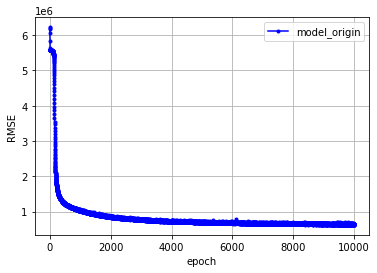

In [43]:
model1_rmse = np.sqrt(history_origin.history['loss'])

#model2_rmse = np.sqrt(history_batch.history['loss'])
#model3_rmse = np.sqrt(history_drop.history['loss'])


x_len = np.arange(len(model1_rmse))

plt.plot(x_len, model1_rmse, marker = '.', c='blue', label = 'model_origin')

#plt.plot(x_len, model3_rmse, marker = '.', c='yellow', label = 'model_drop')

plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.show()

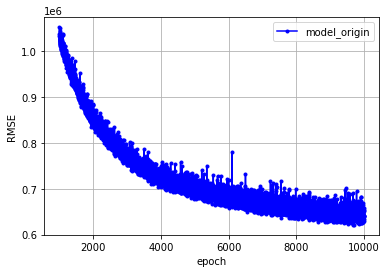

In [44]:
model1_rmse = np.sqrt(history_origin.history['loss'])
#model2_rmse = np.sqrt(history_batch.history['loss'])
#model3_rmse = np.sqrt(history_drop.history['loss'])


x_len = np.arange(len(model1_rmse))

plt.plot(x_len[1000:], model1_rmse[1000:], marker = '.', c='blue', label = 'model_origin')
#plt.plot(x_len, model2_rmse, marker = '.', c='red', label = 'model_batch)')
#plt.plot(x_len, model3_rmse, marker = '.', c='yellow', label = 'model_drop')

plt.legend(loc = 'upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.show()

In [46]:
811324735488**0.5

900735.6634929029

# 6. 성능개선